In [30]:
import numpy as np
import itertools 
import ezc3d
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
#import pysd
from pyomeca import Analogs

import dataprocesing as dp

from ezc3d import c3d
import numpy as np

def read_labels(data_path):
    c3d_to_compare= c3d(data_path)
    event = c3d_to_compare['parameters']['EVENT']['LABELS']['value']
    time = np.around(c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]*1000)
    
    return [event, time]

muscles = ["Voltage.1","Voltage.2","Voltage.3","Voltage.4","Voltage.5","Voltage.6","Voltage.7","Voltage.8","Voltage.9","Voltage.10","Voltage.11","Voltage.12","Voltage.13","Voltage.14","Voltage.15","Voltage.16"]

folder_path=r"Z:\Miecz\\"
data_path=folder_path

In [31]:
import xarray as xr

def detect_onset_new( x, threshold, n_above: int = 1, n_below: int = 0, threshold2: int = None, n_above2: int = 1):
    if x.ndim != 1:
        raise ValueError(
            f"detect_onset works only for one-dimensional vector. You have {x.ndim} dimensions."
        )
    if isinstance(threshold, xr.DataArray):
        threshold = threshold.item()
    if isinstance(threshold2, xr.DataArray):
        threshold2 = threshold2.item()

    x = np.atleast_1d(x.copy())
    x[np.isnan(x)] = -np.inf
    inds = np.nonzero(x >= threshold)[0]
    if inds.size:
        # initial and final indexes of almost continuous data
        inds = np.vstack(
            (
                inds[np.diff(np.hstack((-np.inf, inds))) > n_below + 1],
                inds[np.diff(np.hstack((inds, np.inf))) > n_below + 1],
            )
        ).T
        # indexes of almost continuous data longer than or equal to n_above
        inds = inds[inds[:, 1] - inds[:, 0] >= n_above - 1, :]
        # minimum amplitude of n_above2 values in x to detect
        if threshold2 is not None and inds.size:
            idel = np.ones(inds.shape[0], dtype=bool)
            for i in range(inds.shape[0]):
                if (
                    np.count_nonzero(x[inds[i, 0] : inds[i, 1] + 1] >= threshold2)
                    < n_above2
                ):
                    idel[i] = False
            inds = inds[idel, :]
    if not inds.size:
        inds = np.array([])
    return inds

In [32]:

def onset_offset_average_shifted(folder_path, person, exer_num):
    
    muscles_names = ["Czworoboczny grzbietu L","Trójgłowy ramienia L", "Dwugłowy ramienia L", "Prostownik nadgarstka L","Skośny brzucha L", "Pośladkowy średni L","Czworogłowy uda L", "Brzuchaty łydki L","Czworoboczny grzbietu P","Trójgłowy ramienia P", "Dwugłowy ramienia P", "Prostownik nadgarstka P","Skośny brzucha P", "Pośladkowy średni P","Czworogłowy uda P", "Brzuchaty łydki P"]
    cons1="\*\*-E0"
    cons2="-*.c3d"
    path=folder_path+person+cons1+exer_num+cons2
    freq=1000
    aver_arr_all=np.zeros((16,1000))     # średnia danych dla 16 mięśni (każdy plik zawiera 1000 jednostek czasu) 
    
    for file in glob.glob(path,recursive = True):
        if str(file).find('fail')==-1:
            print(file)
            emg_processed=dp.emg_full_preproces(file) 
            #print(type(emg_processed))

            aver_arr=np.zeros((16,1000))  #tabela średnich dla każdego mięśnia dla pojedyńczego pliku
            file_num=0

            p,d=dp.read_labels(file, 1000)  # czytnie eventów (początlki i końce eventów)

            for num in range(16):  # dla kazdego miesnia w tym pliku


                s,k=dp.nowy_czas_analog(p,d,emg_processed[num]) #nowy poczatek i koniec po przesunieciu

                for i in range(len(p)):     #dla każdego eventu robiona jest normalizacja        
                    emg_processed_event=emg_processed[num][(p[i]+s[i].astype(int)):(d[i]+k[i].astype(int))]
                    emg_processed_event2 = (
                    emg_processed_event.meca.normalize(scale=1)                
             )                                           
                    time_normalized=emg_processed_event2.meca.time_normalize(n_frames=1000)                

                    for t in range(1000):   #liczenie średniej
                        aver_arr[num][t]=aver_arr[num][t]+time_normalized.values[t]

                aver_arr[num]=aver_arr[num]/10
                time=np.linspace(1,1000,1000)

                for t2 in range(1000):  #średnia dla wszytskich plików
                    aver_arr_all[file_num][t2]=aver_arr_all[file_num][t2]+time_normalized.values[t2] # tablica zawiera wartości srednie dla wsytzkich plikow
                file_num=file_num+1;

            
    return aver_arr_all     
            
            


In [33]:
            
def print_onset_offset(aver_arr_all,freq=1000, fun="mean", mult=1 ,above=None ,below=None ):  
    if above is None:
        above=freq/2
    if below is None:
        below=freq/2
    
    muscles_names = ["Czworoboczny grzbietu L","Trójgłowy ramienia L", "Dwugłowy ramienia L", "Prostownik nadgarstka L","Skośny brzucha L", "Pośladkowy średni L","Czworogłowy uda L", "Brzuchaty łydki L","Czworoboczny grzbietu P","Trójgłowy ramienia P", "Dwugłowy ramienia P", "Prostownik nadgarstka P","Skośny brzucha P", "Pośladkowy średni P","Czworogłowy uda P", "Brzuchaty łydki P"]
    time=np.linspace(1,1000,1000)
    freq=1000
    for num in range(16):
        
        
        #onsets=detect_onset_new(aver_arr_all[num],threshold= aver_arr_all[num].mean(), n_above=freq / 4,n_below=freq / 4 )
        #print(onsets)
        if fun == "mean":
            onsets=detect_onset_new(aver_arr_all[num],threshold= aver_arr_all[num].mean()*mult, n_above=above,n_below=below )
        if fun == "std":
            onsets=detect_onset_new(aver_arr_all[num],threshold= aver_arr_all[num].std()*mult, n_above=above,n_below=below )

        
#         onsets =  aver_arr_all[num].meca.detect_onset(
#         threshold= aver_arr_all[num].mean(),   # mean of the signal 
            
#         #threshold2= emg[i].std(),
            
#         n_above=freq / 4,                     # we want at least 1/2 second above the threshold
#         n_below=freq / 4,                     # we accept point below threshold for 1/2 second
#         ) 
        subplot(1, 1, 1)
        for (start, end) in onsets:   
            plt.axvspan(start, end, color="b")           
         
        
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.25, 
                    wspace=0.25, 
                    hspace=0.35)
        aver_arr_all[num]=aver_arr_all[num]/5
        plt.plot(time,aver_arr_all[num], color="r")     
        plt.title(muscles_names[num])
        plt.show()

In [34]:
aver_arr_all=onset_offset_average_shifted(data_path, "B0446","1")

Z:\Miecz\\B0446\2020-08-06-B0446-S01\2020-08-06-B0446-S01-E01-T01.c3d
Z:\Miecz\\B0446\2020-08-06-B0446-S01\2020-08-06-B0446-S01-E01-T02.c3d
Z:\Miecz\\B0446\2020-08-06-B0446-S01\2020-08-06-B0446-S01-E01-T03.c3d
Z:\Miecz\\B0446\2020-08-06-B0446-S01\2020-08-06-B0446-S01-E01-T04.c3d
Z:\Miecz\\B0446\2020-08-06-B0446-S01\2020-08-06-B0446-S01-E01-T05.c3d
Z:\Miecz\\B0446\2020-08-06-B0446-S01\2020-08-06-B0446-S01-E01-T06.c3d


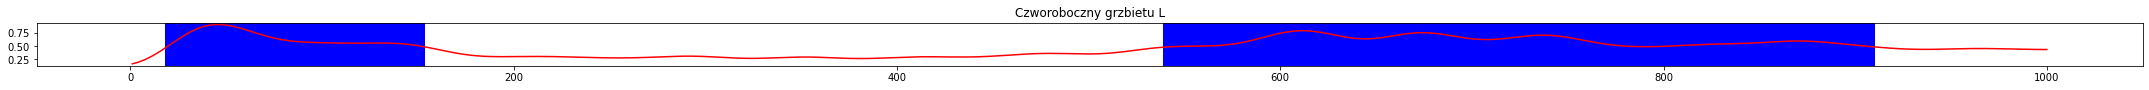

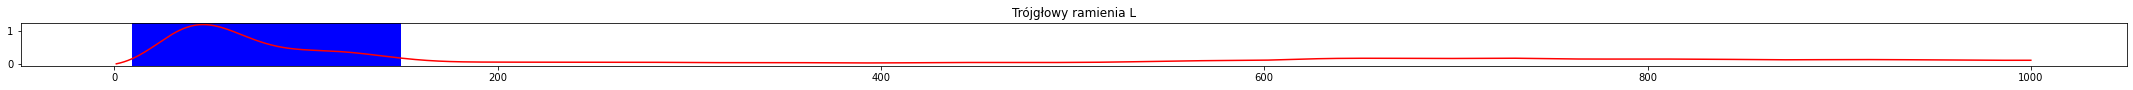

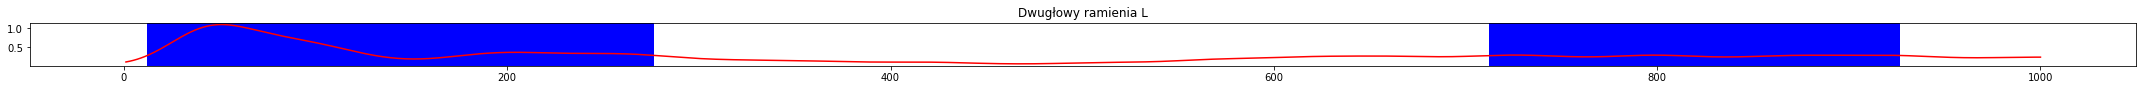

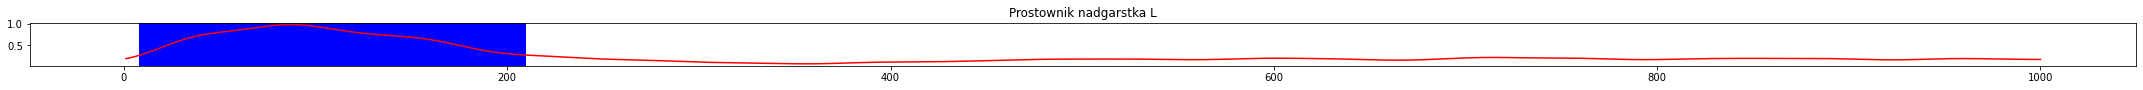

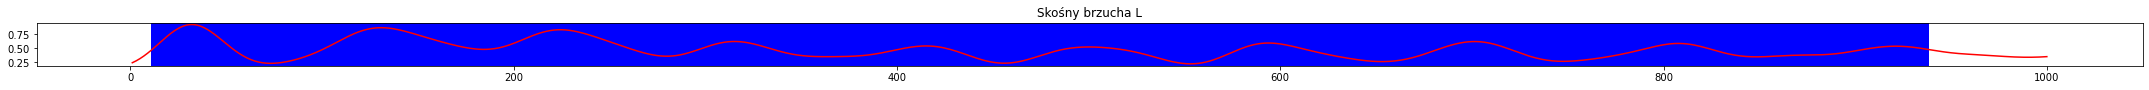

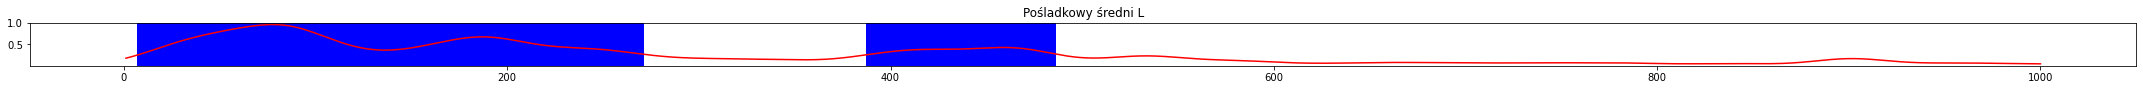

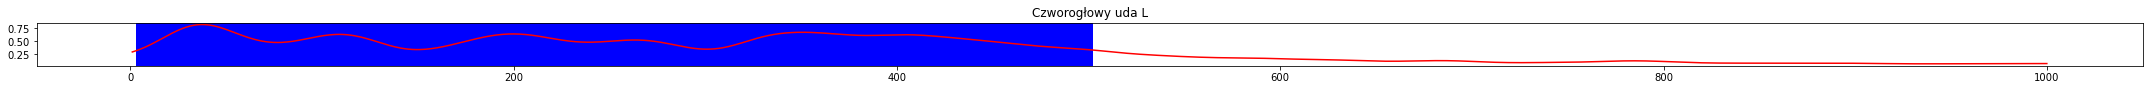

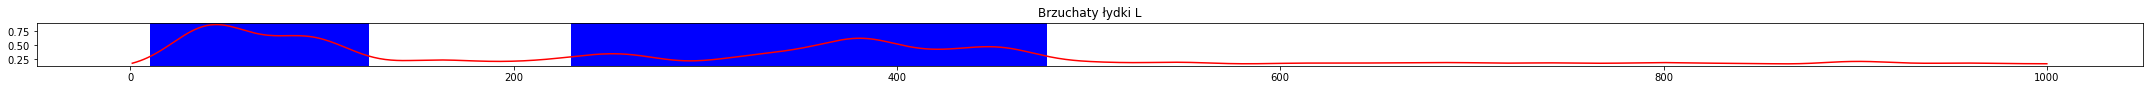

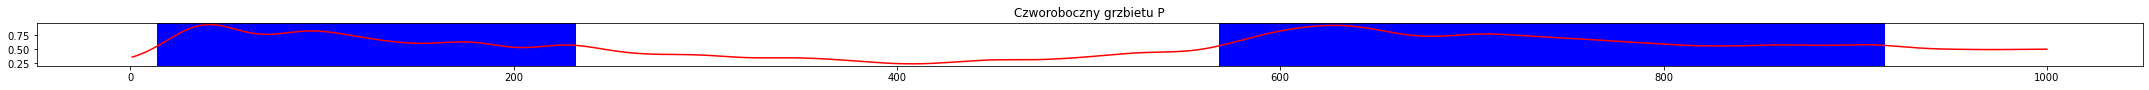

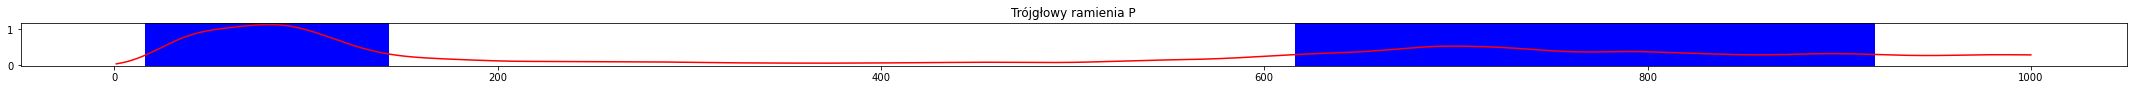

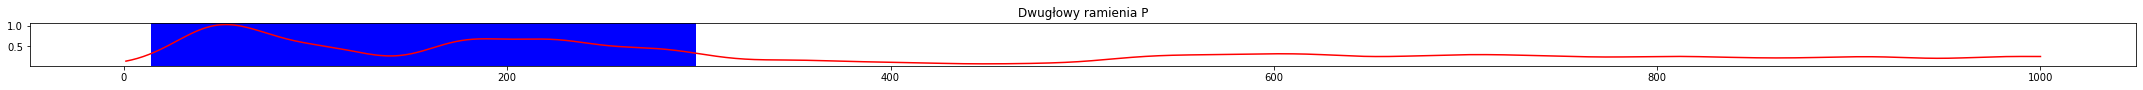

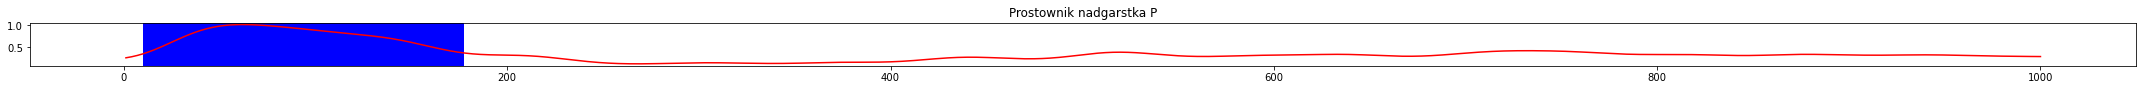

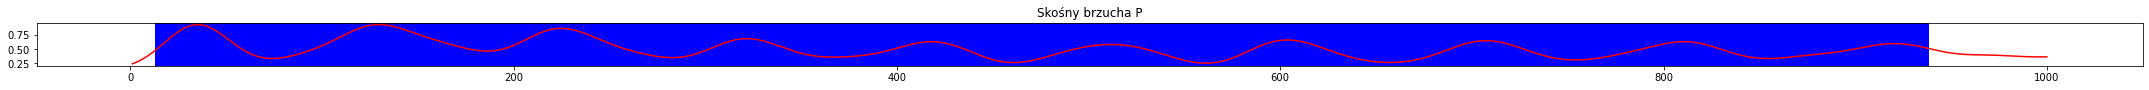

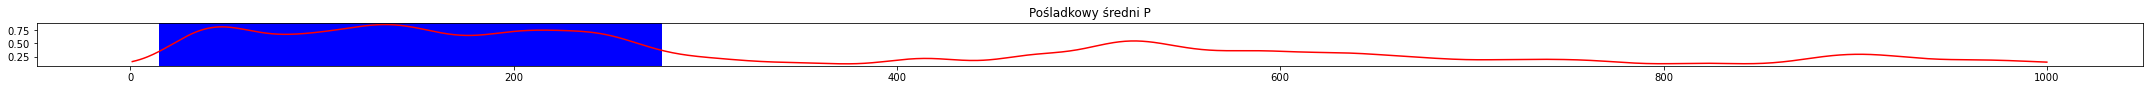

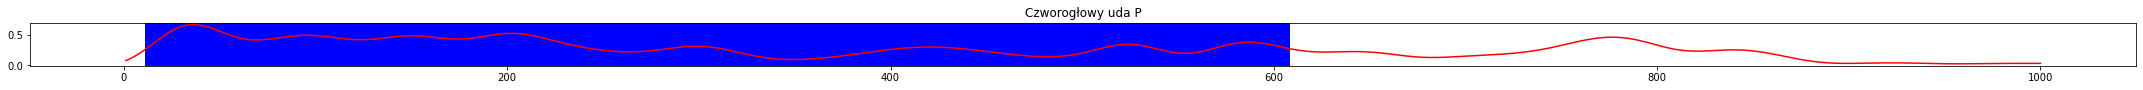

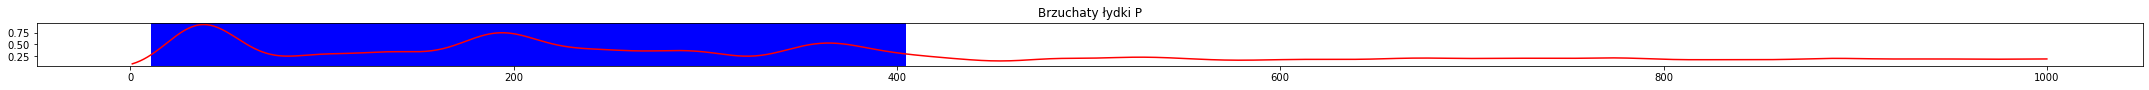

In [35]:
print_onset_offset(aver_arr_all,1000, "mean", 1. , 1000/10 , 1000/10)


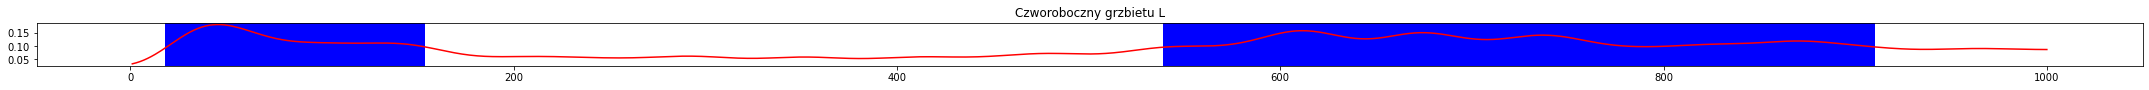

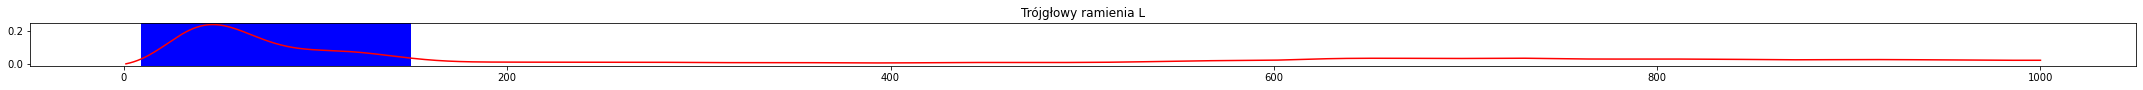

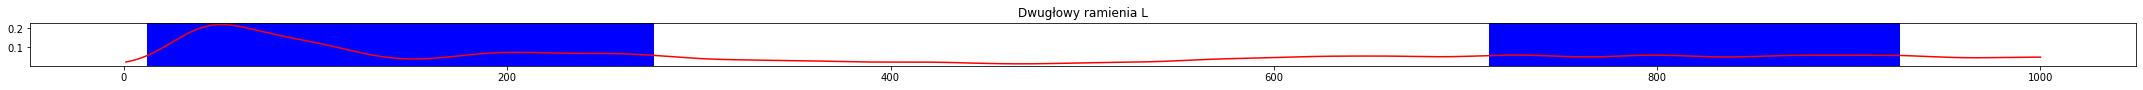

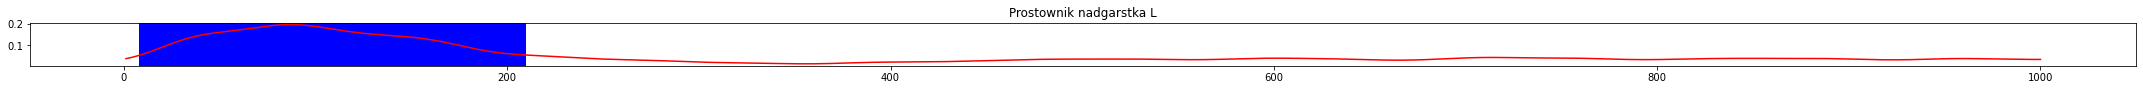

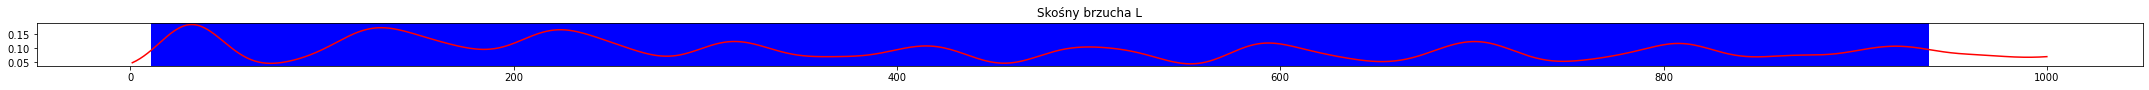

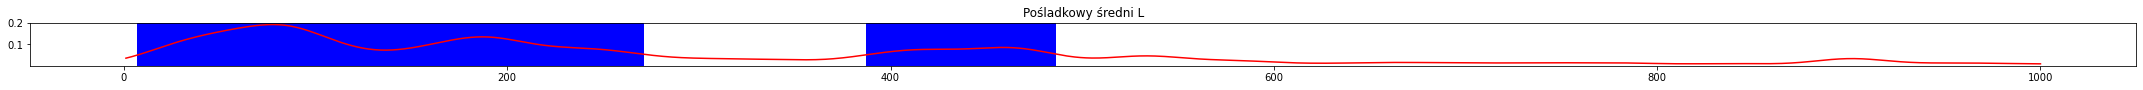

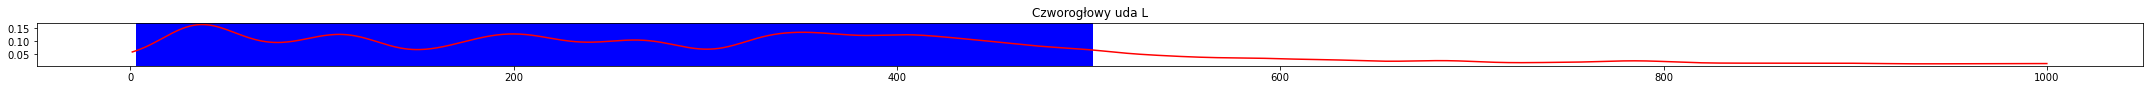

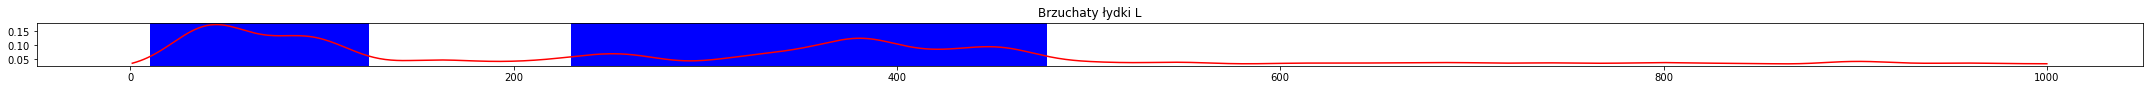

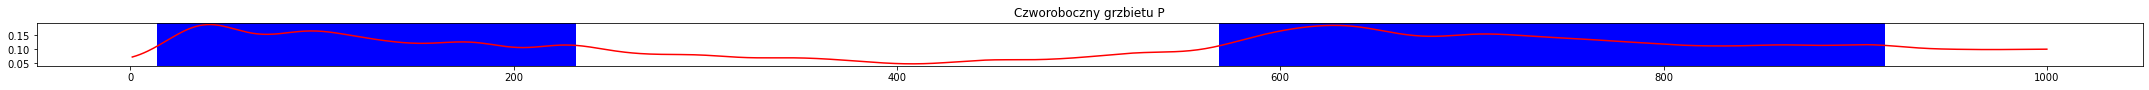

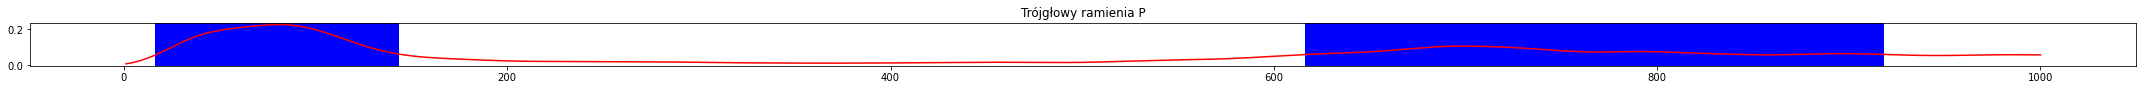

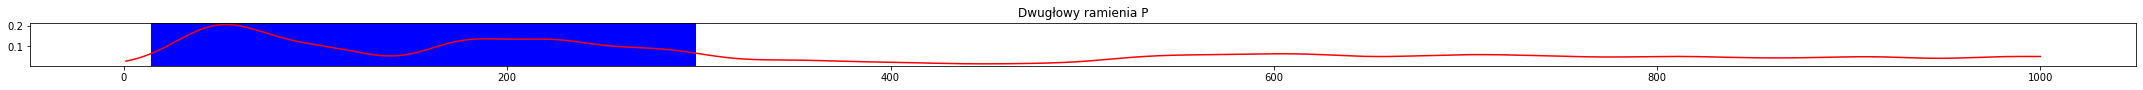

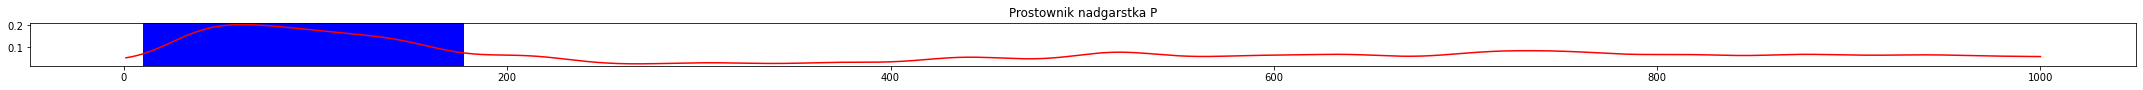

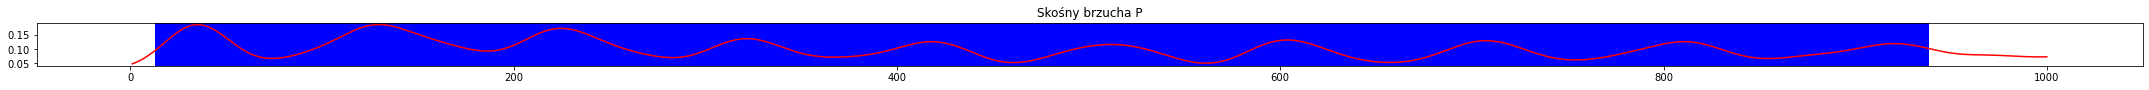

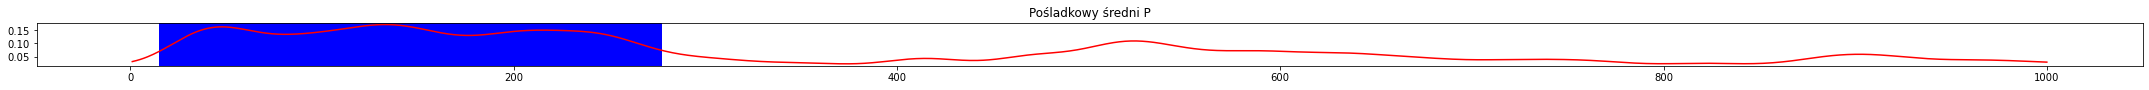

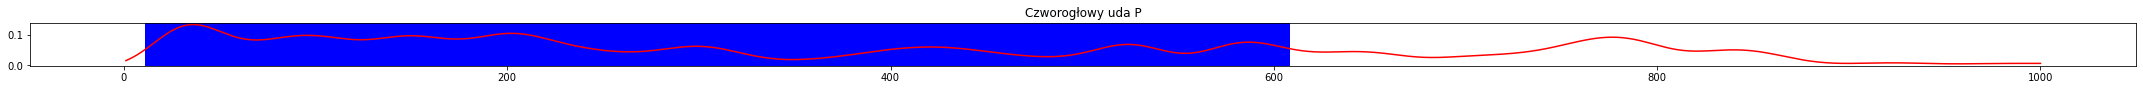

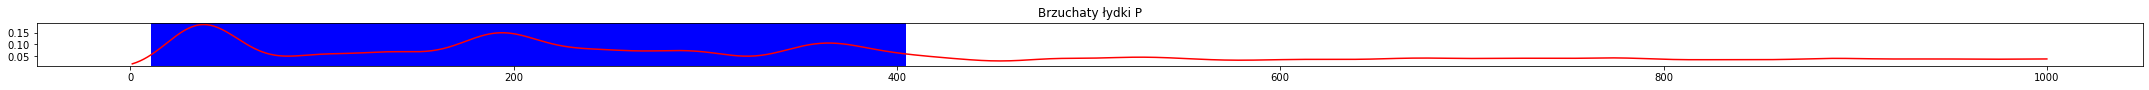

In [36]:
print_onset_offset(aver_arr_all,1000, "mean", 1 , 1000/10 , 1000/10)


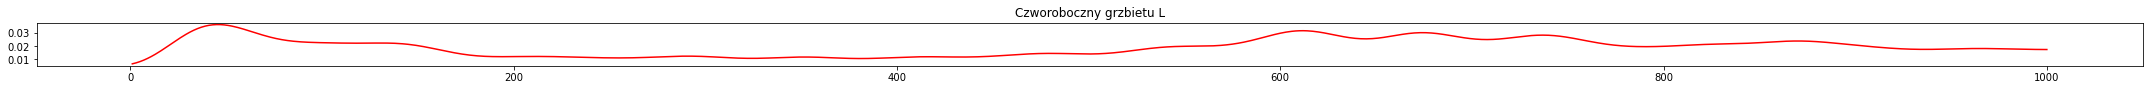

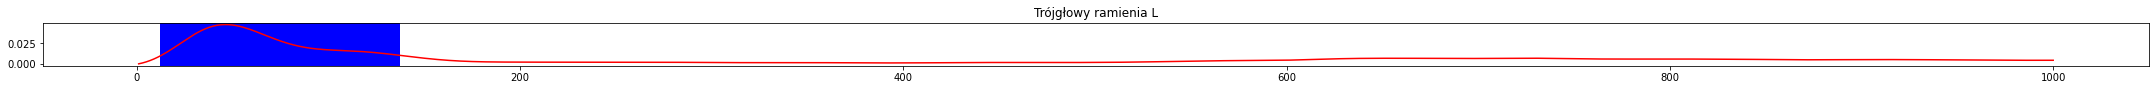

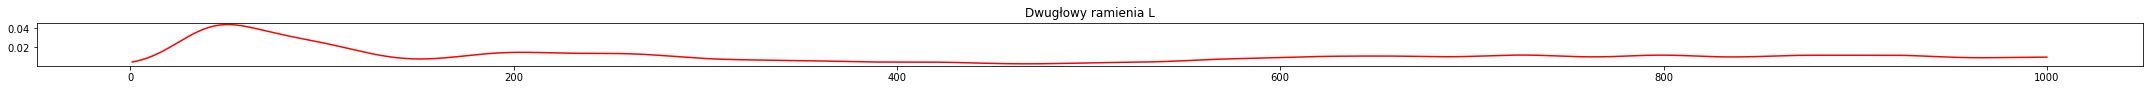

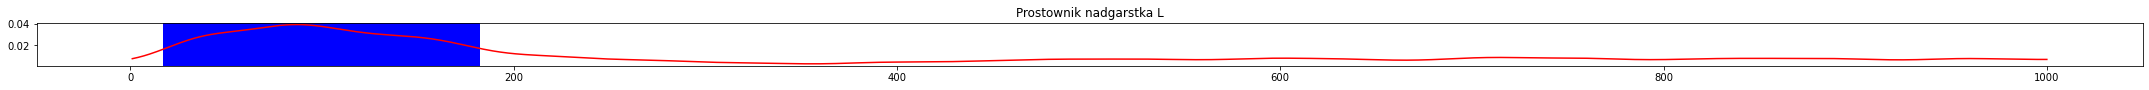

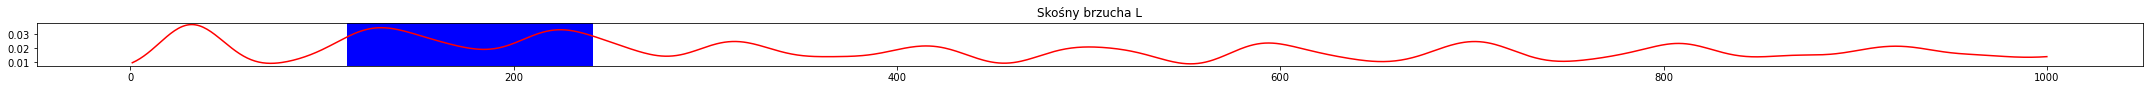

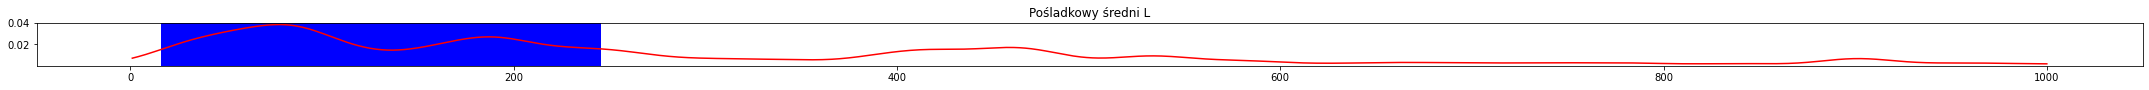

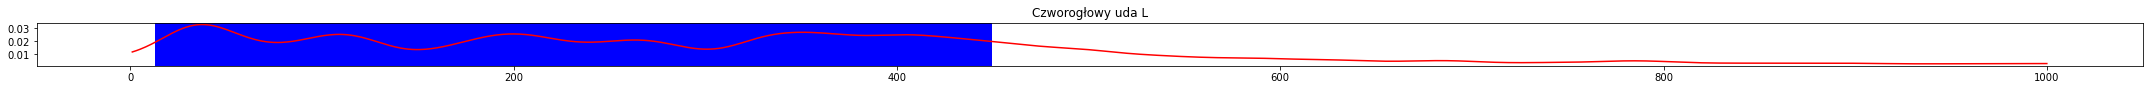

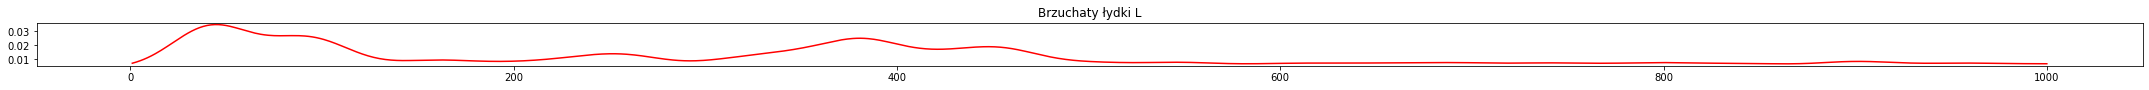

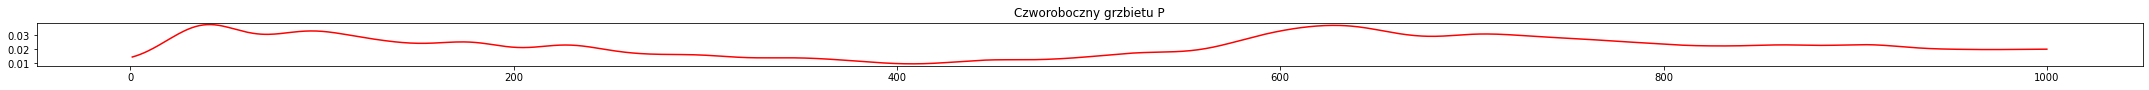

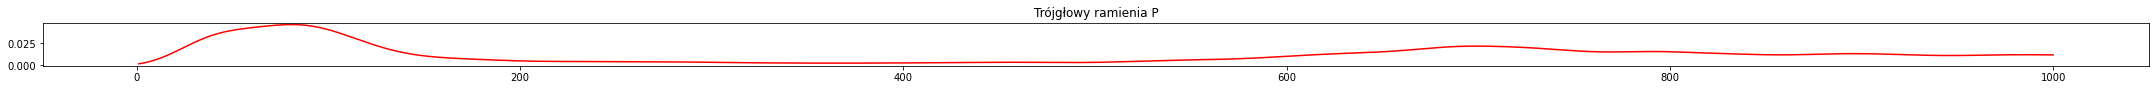

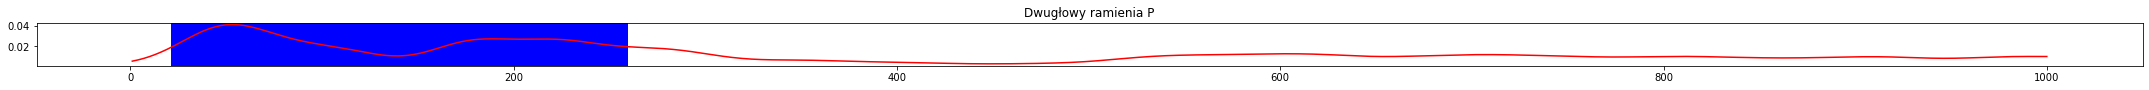

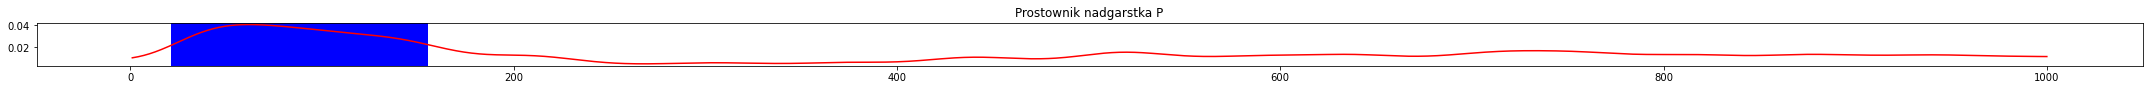

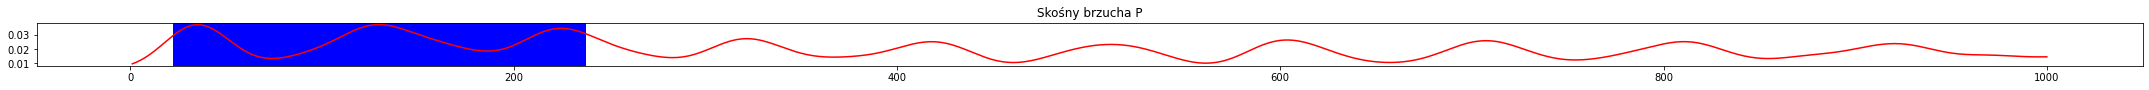

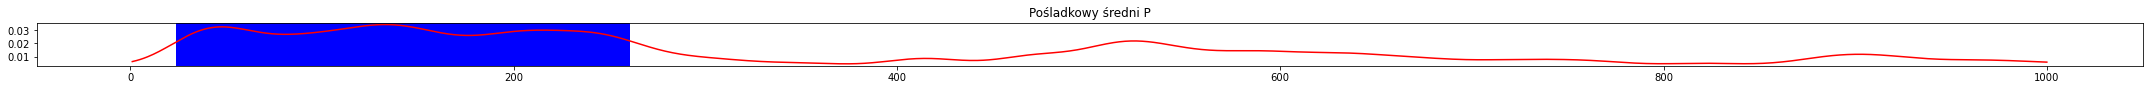

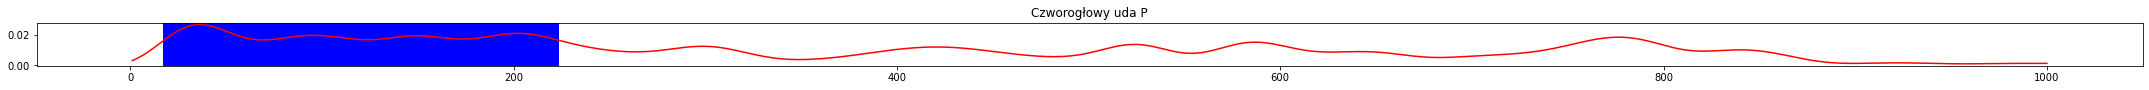

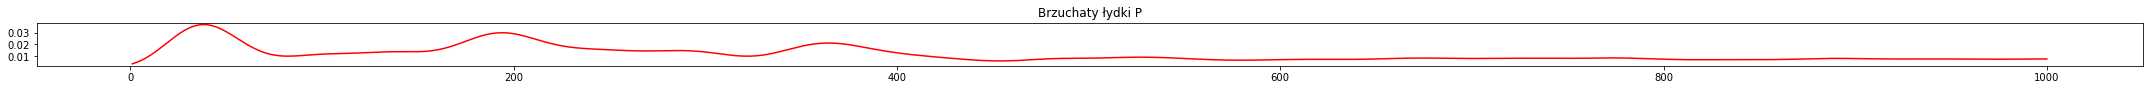

In [37]:
print_onset_offset(aver_arr_all,1000, "mean", 1.5 , 1000/8 , 1000/15)

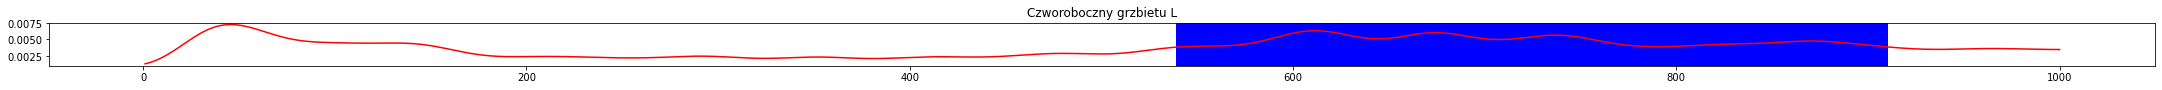

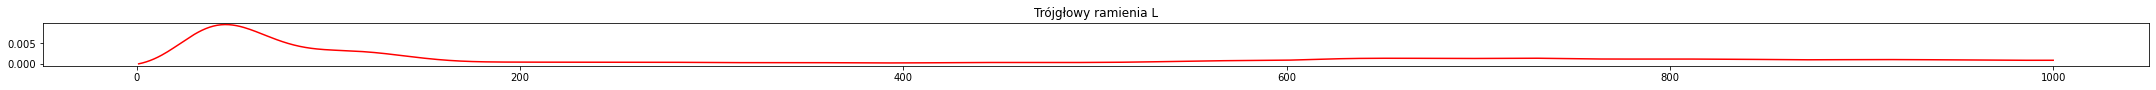

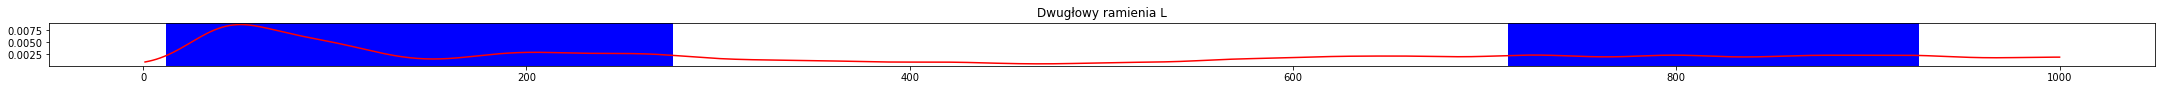

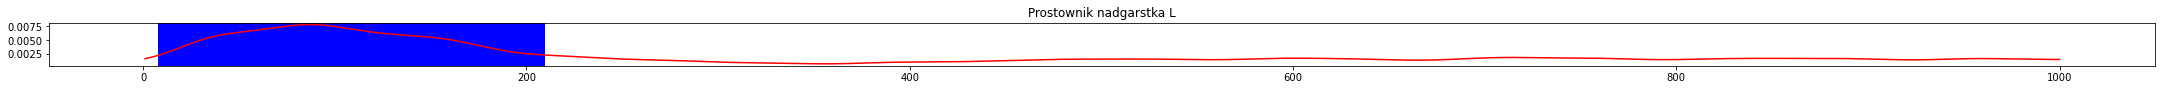

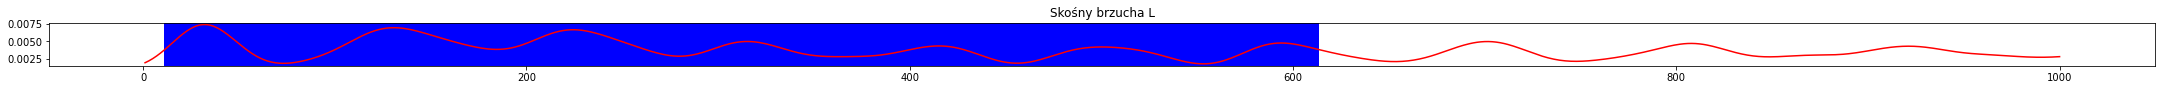

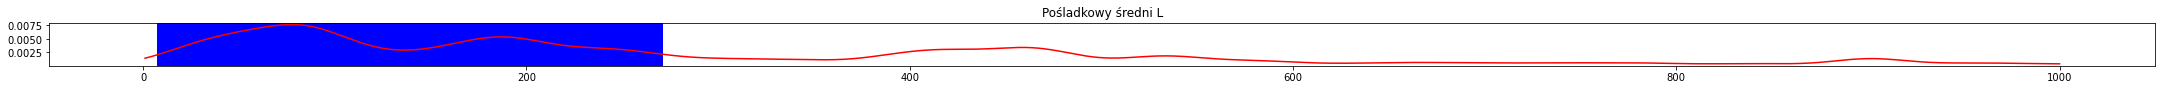

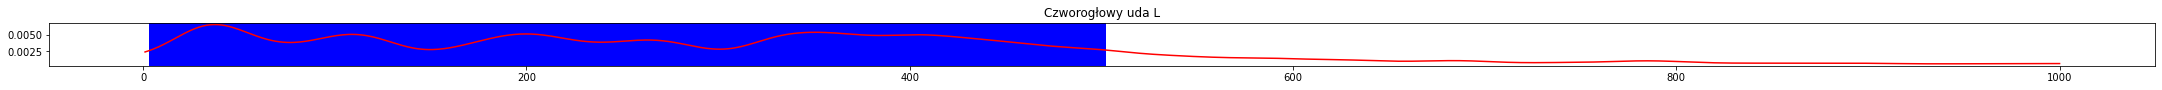

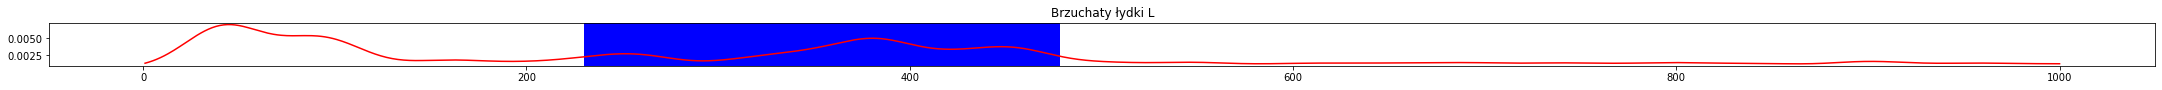

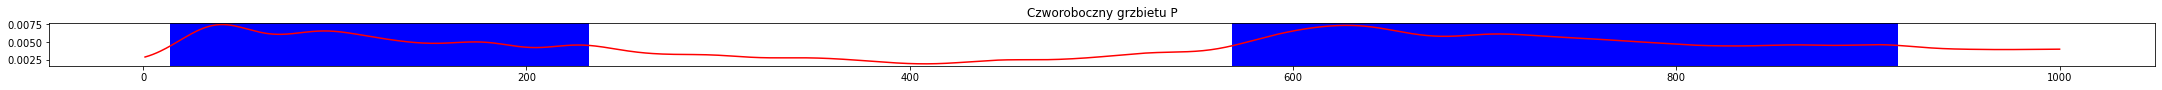

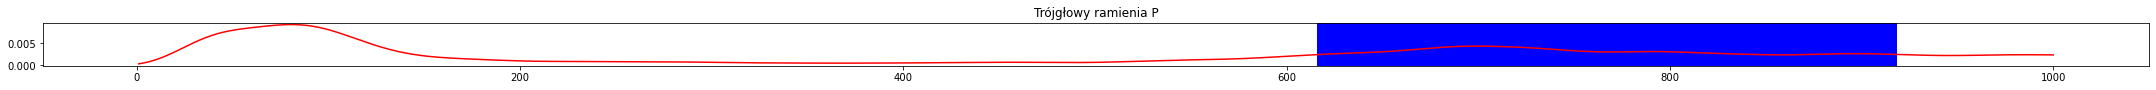

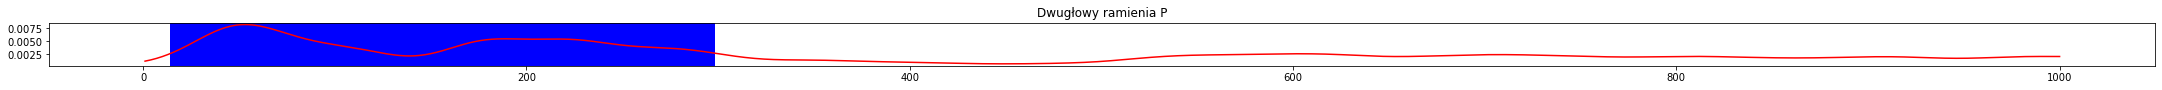

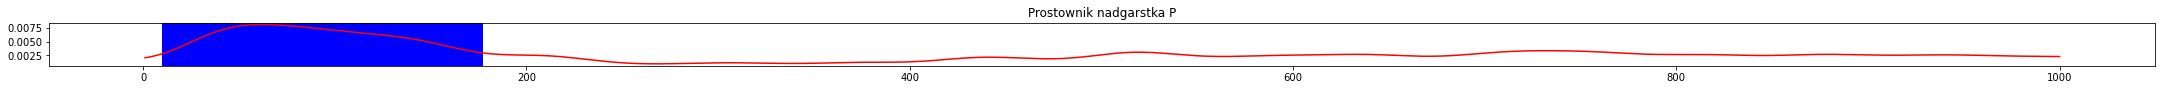

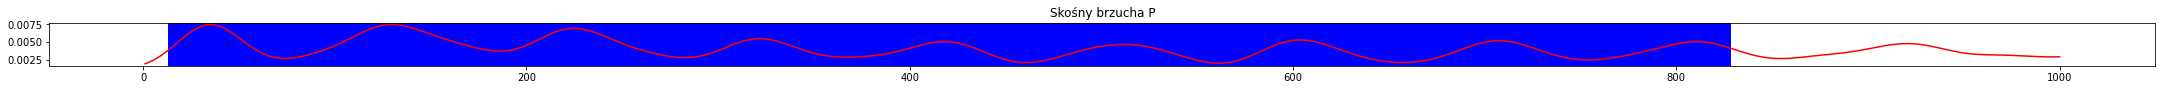

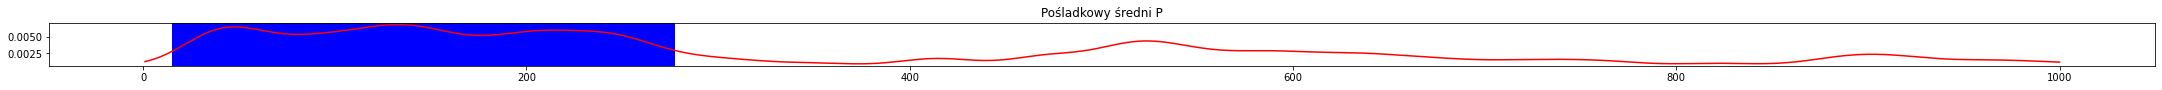

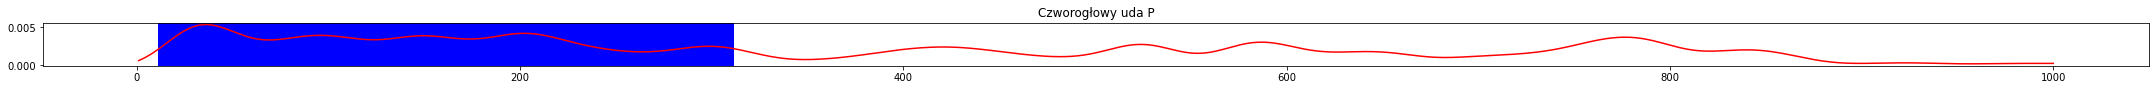

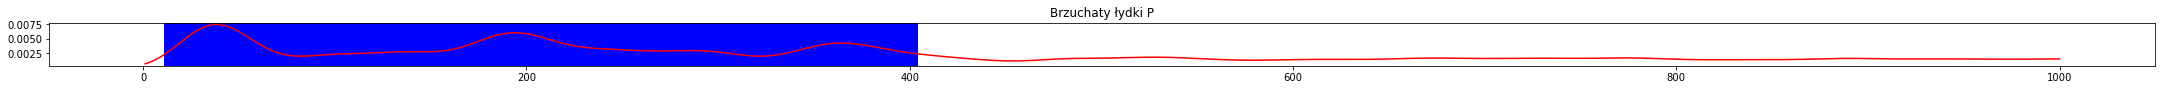

In [38]:
print_onset_offset(aver_arr_all,1000, "mean", 1 , 1000/6 , 1000/15)

In [39]:
help(print_onset_offset)

Help on function print_onset_offset in module __main__:

print_onset_offset(aver_arr_all, freq=1000, fun='mean', mult=1, above=None, below=None)



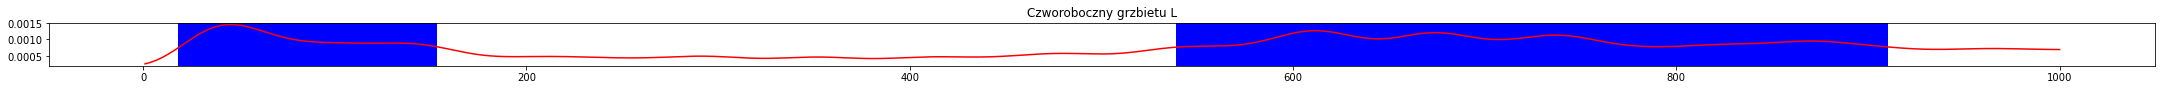

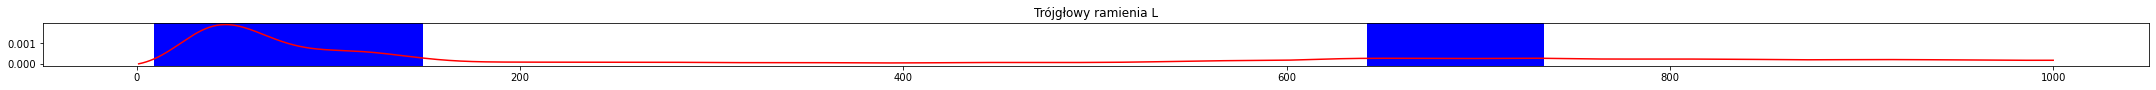

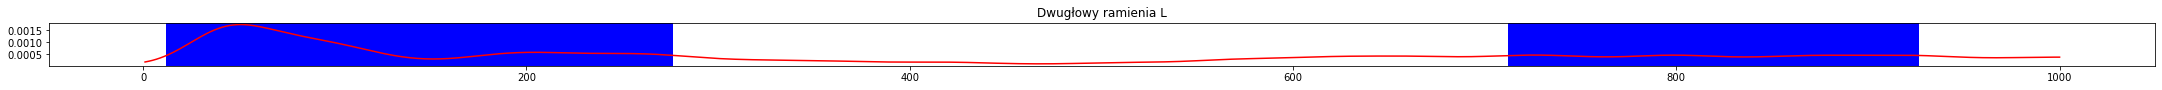

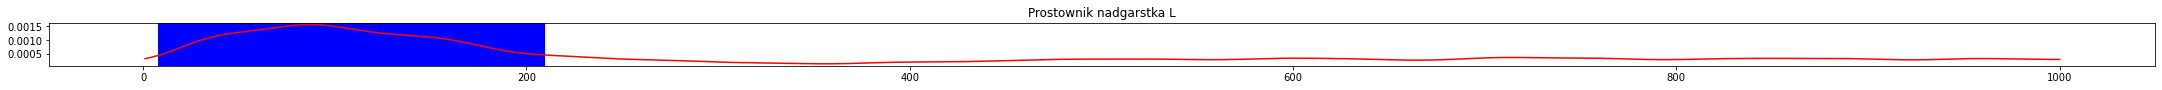

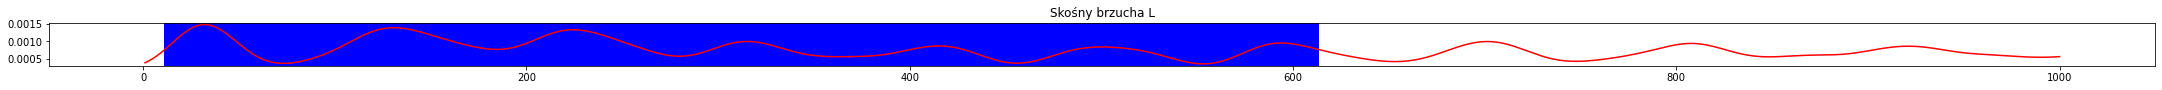

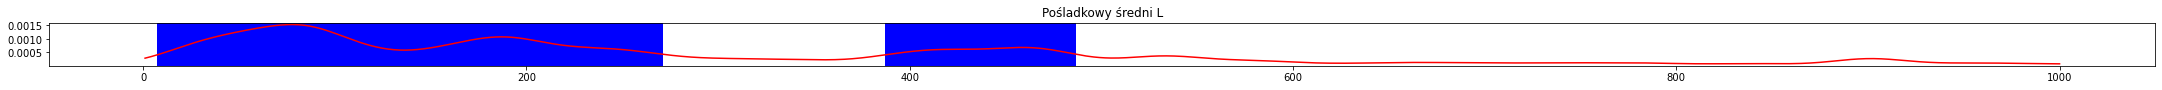

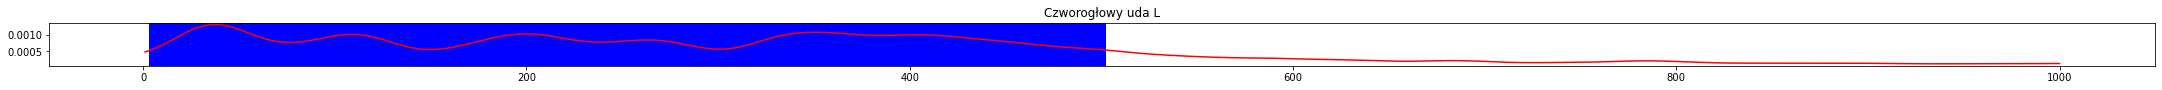

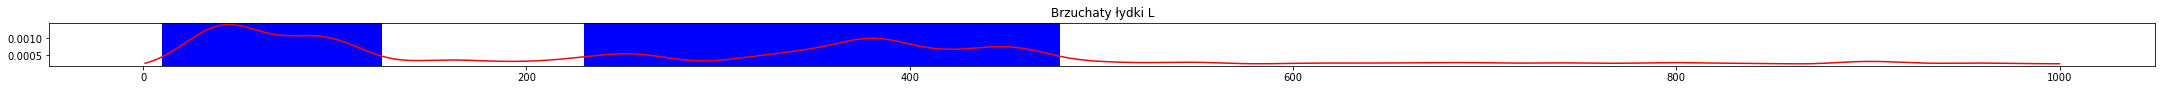

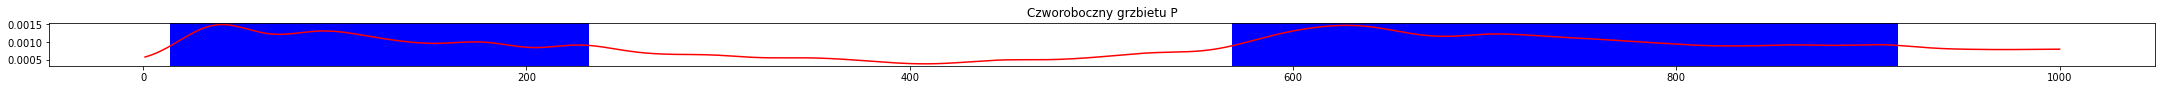

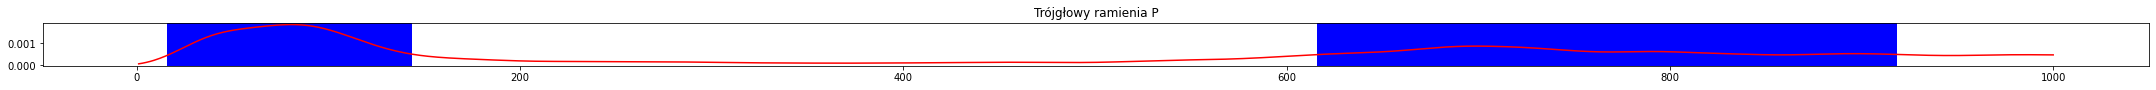

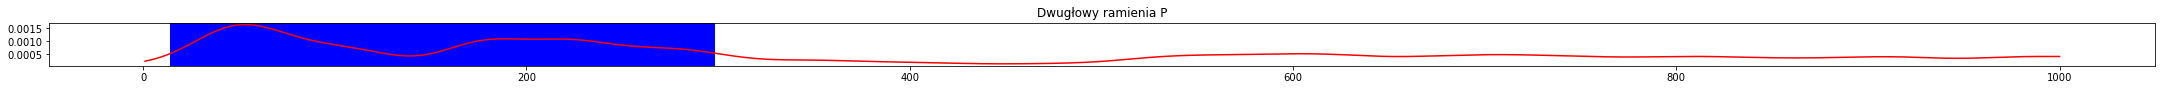

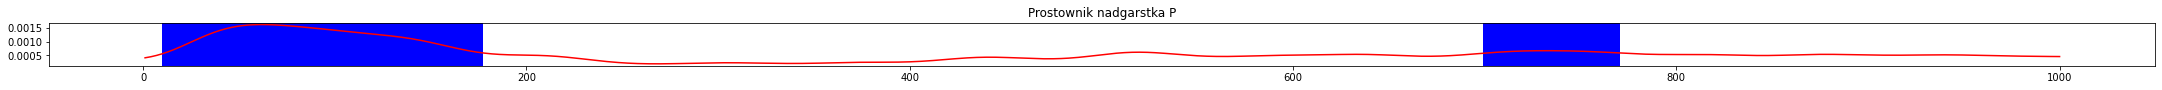

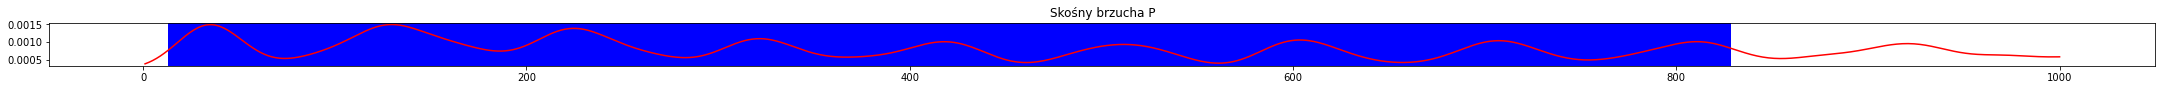

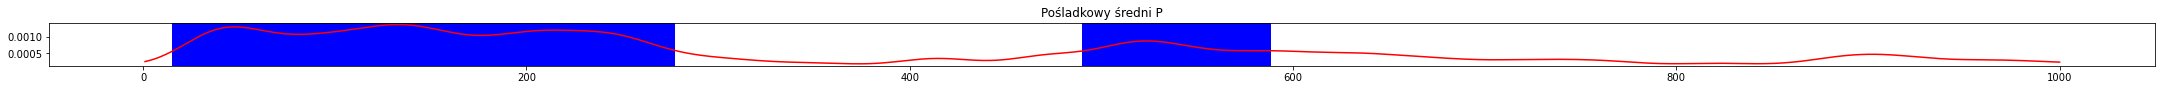

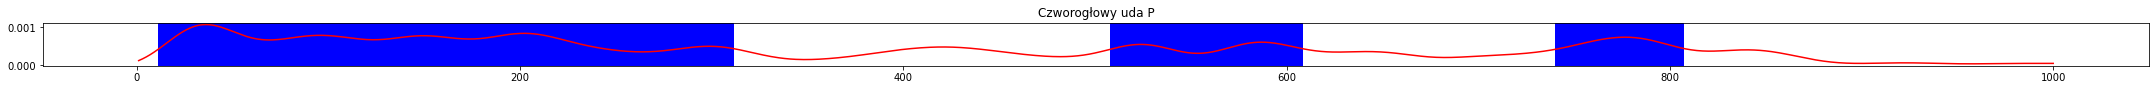

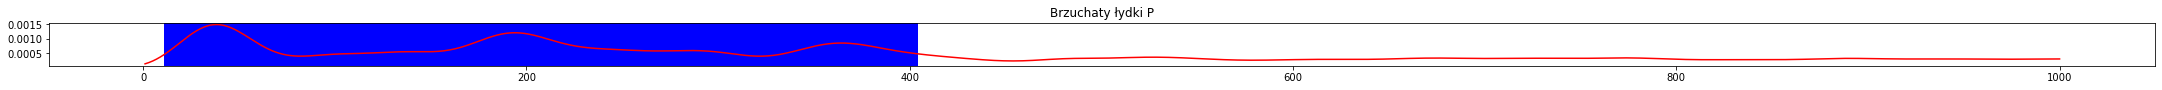

In [40]:
print_onset_offset(aver_arr_all,1000, "mean", 1 , 1000/15 , 1000/15)

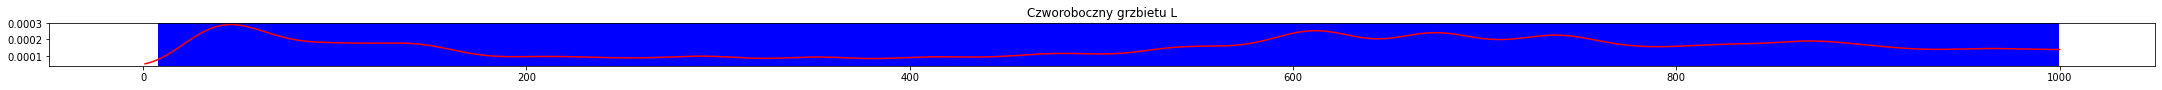

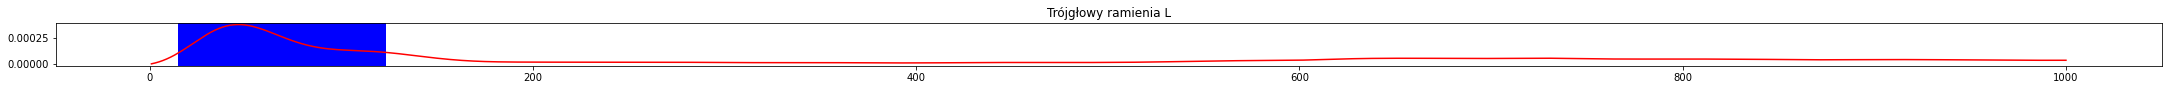

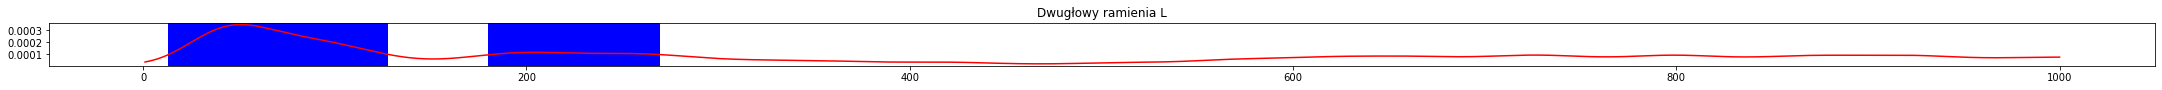

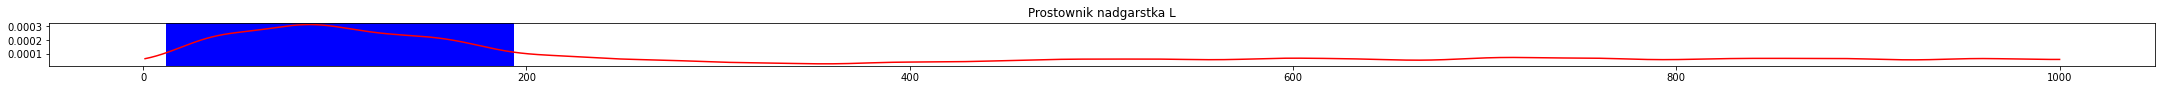

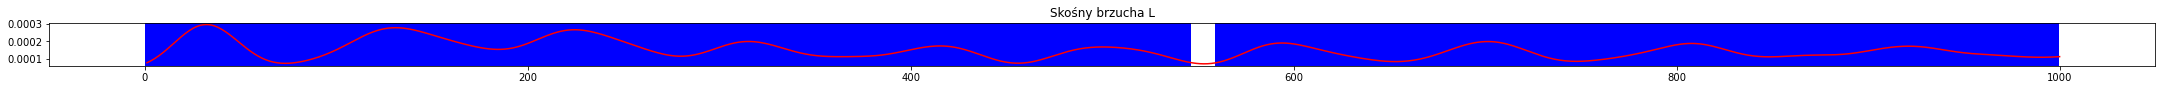

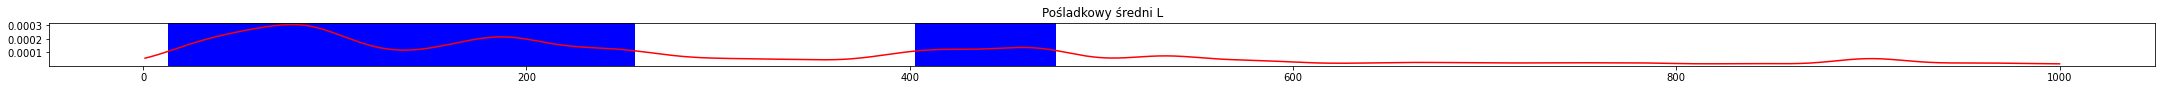

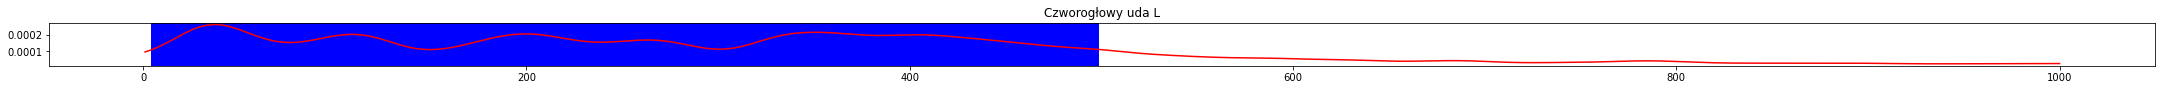

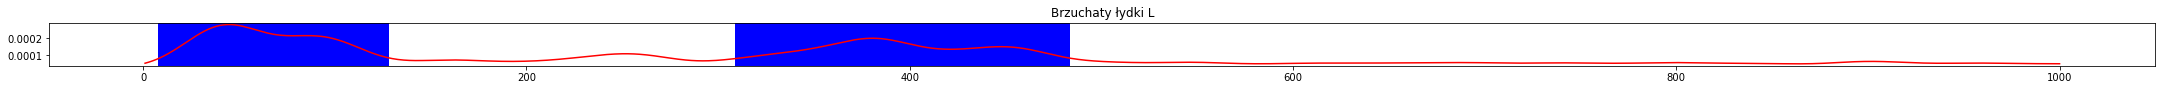

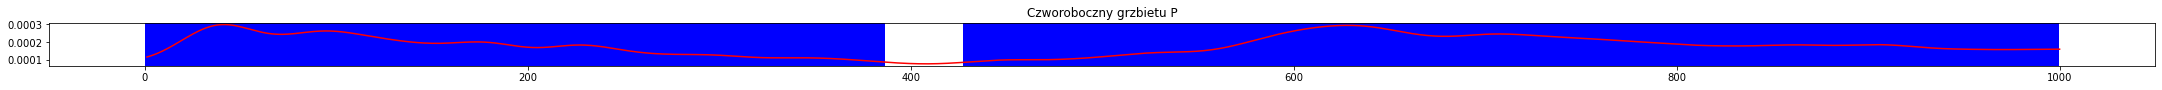

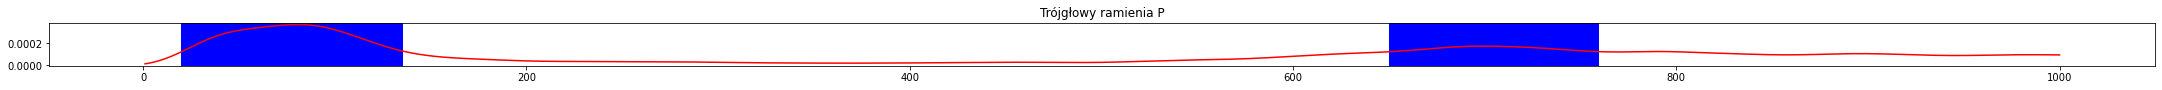

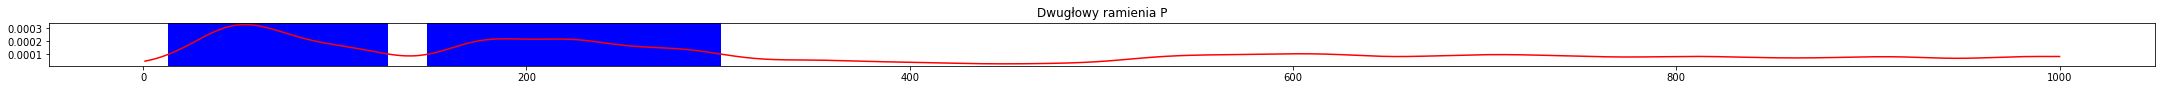

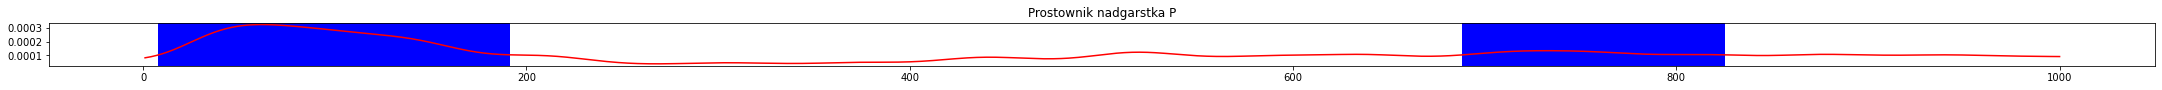

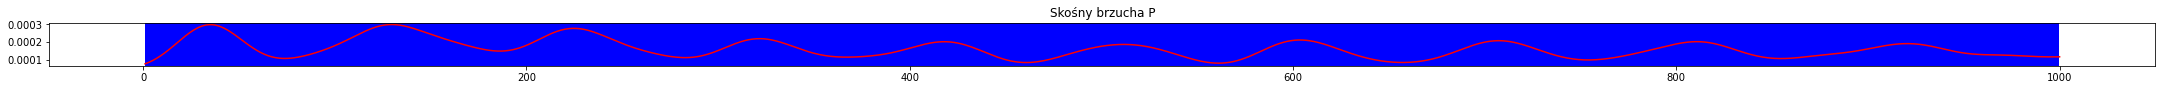

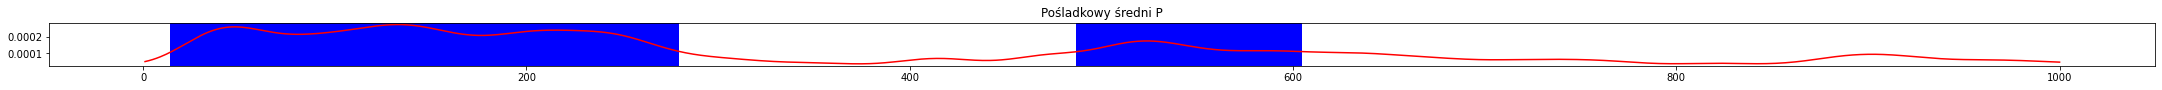

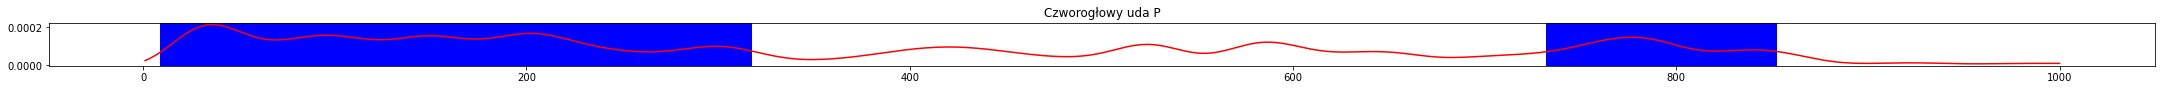

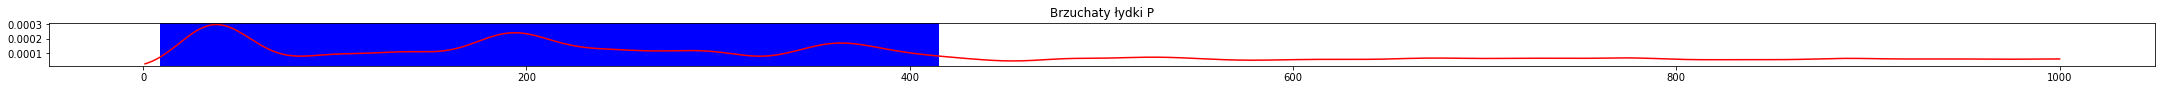

In [41]:
print_onset_offset(aver_arr_all,1000, "std", 1.5 , 1000/15 , 1000/100)

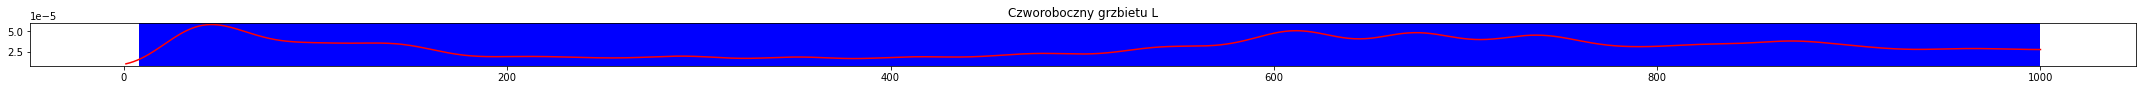

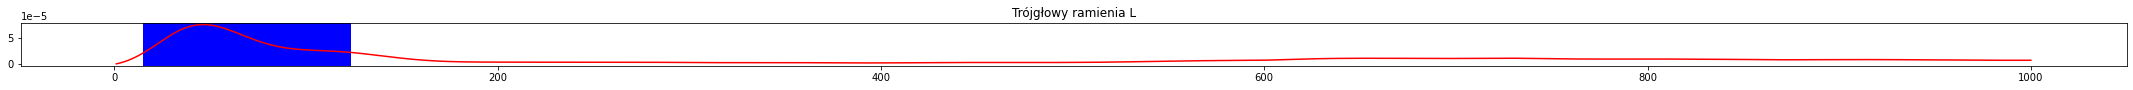

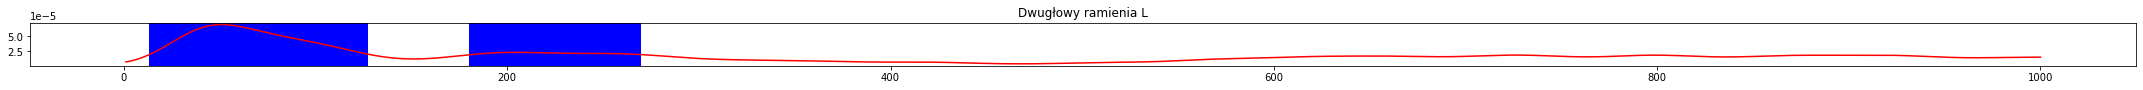

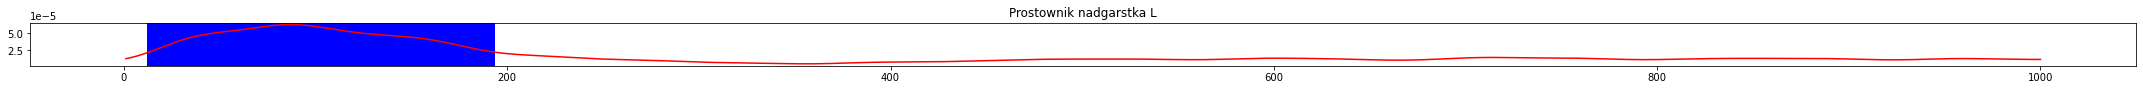

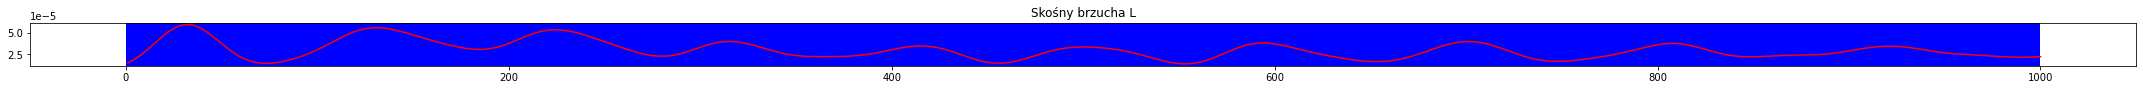

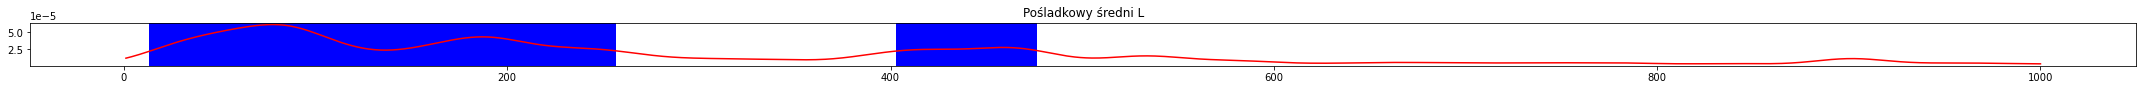

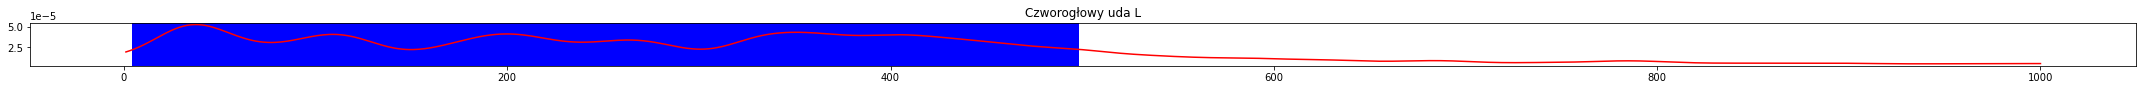

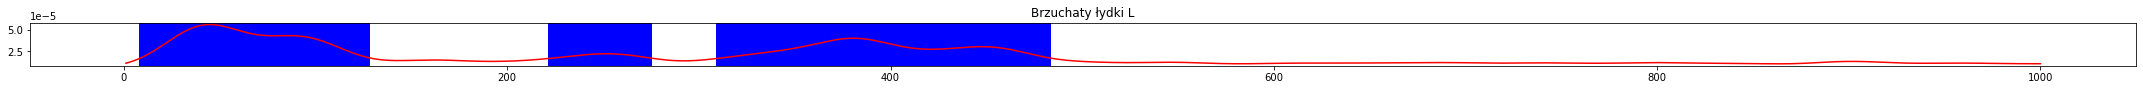

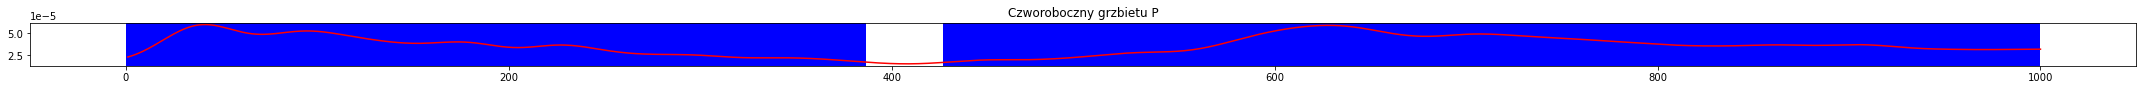

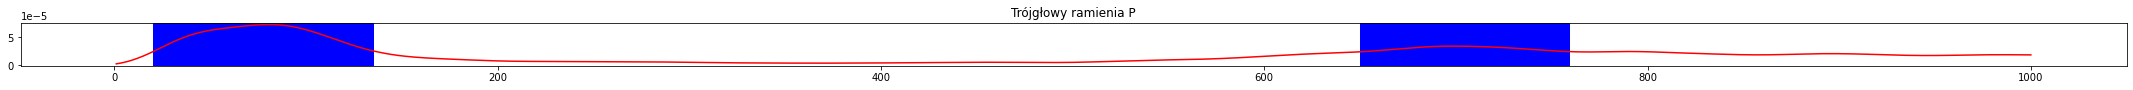

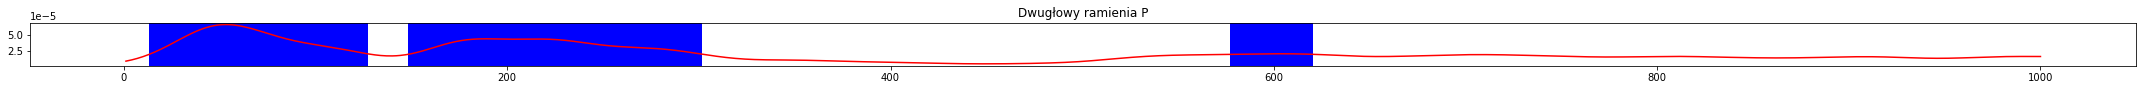

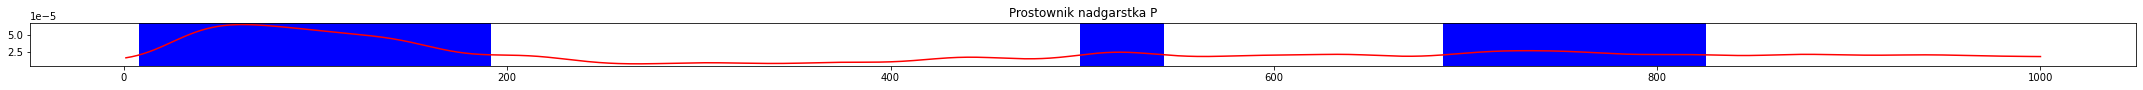

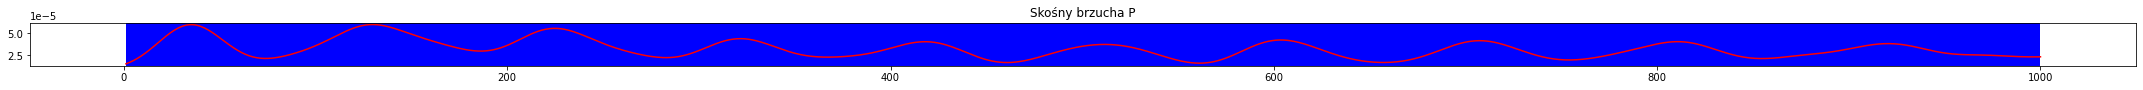

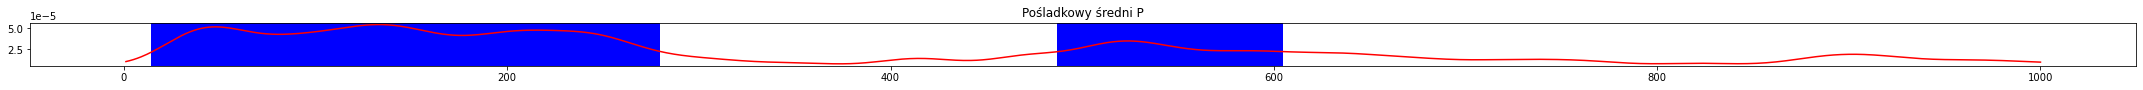

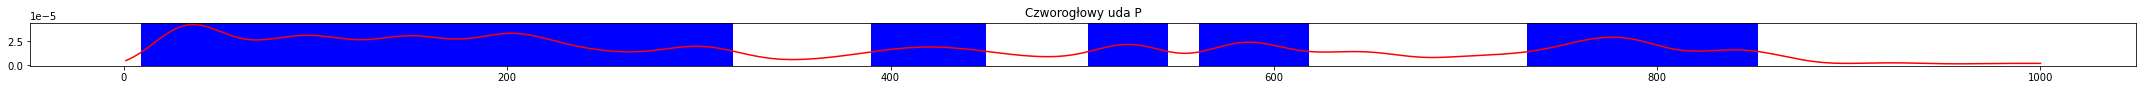

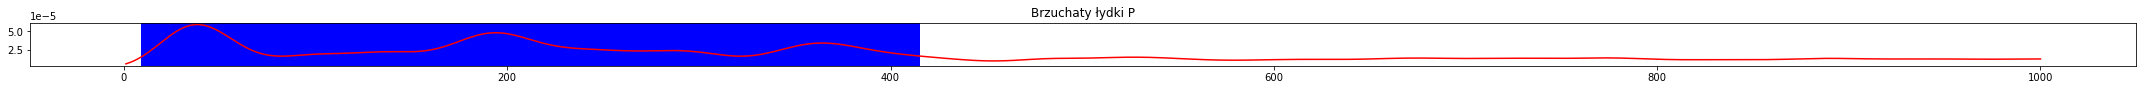

In [42]:
print_onset_offset(aver_arr_all,1000, "std", 1.5 , 1000/25 , 1000/80)

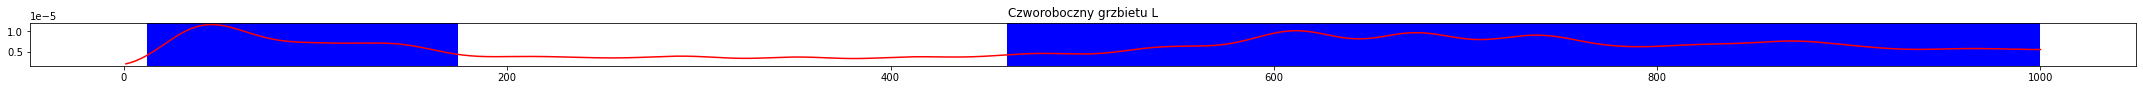

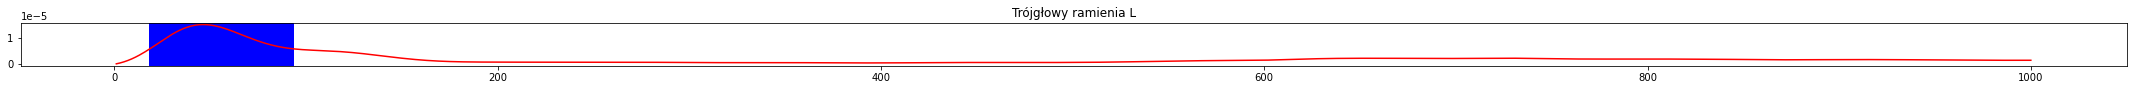

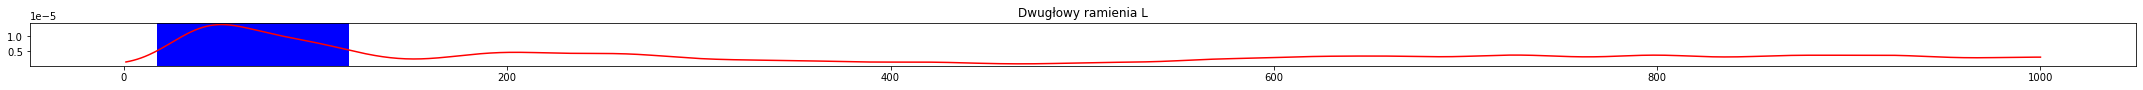

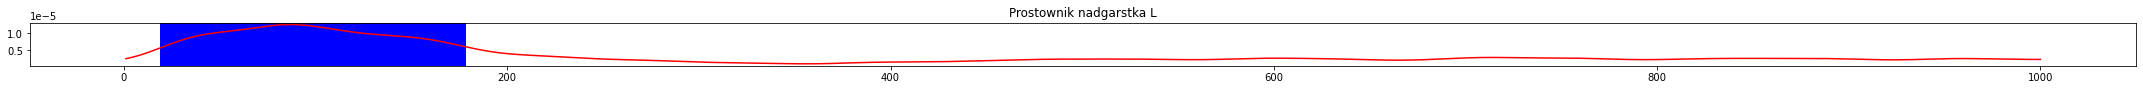

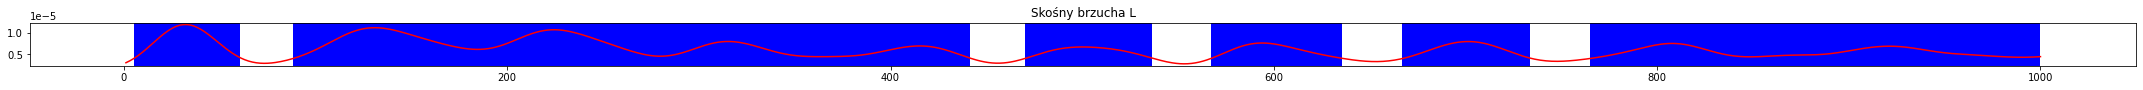

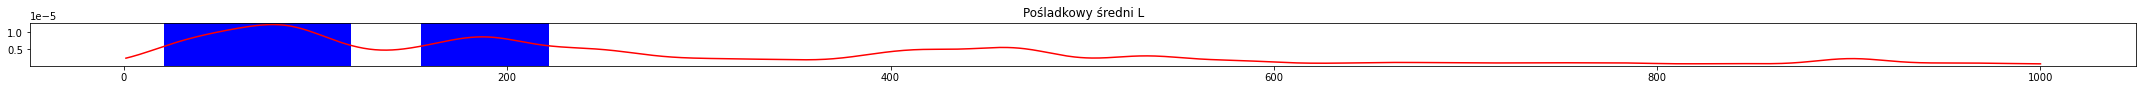

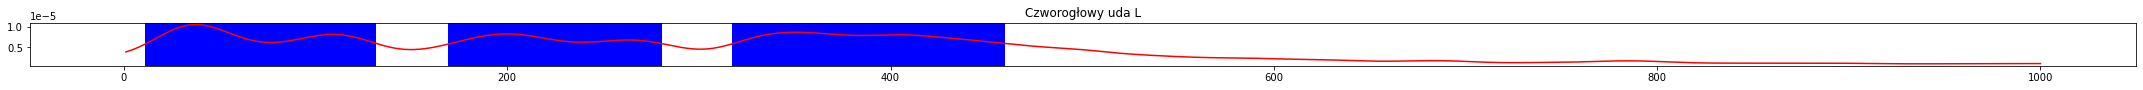

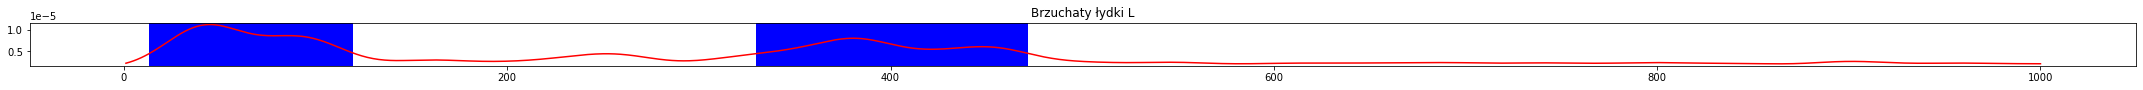

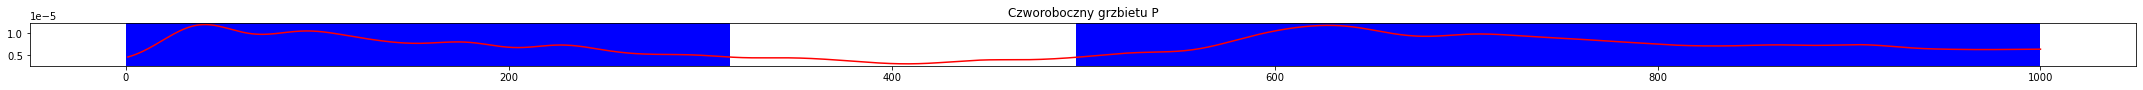

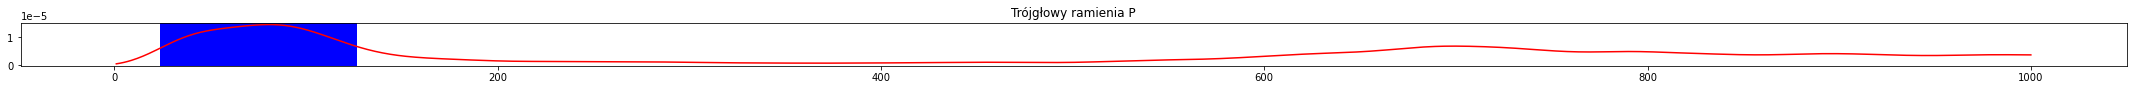

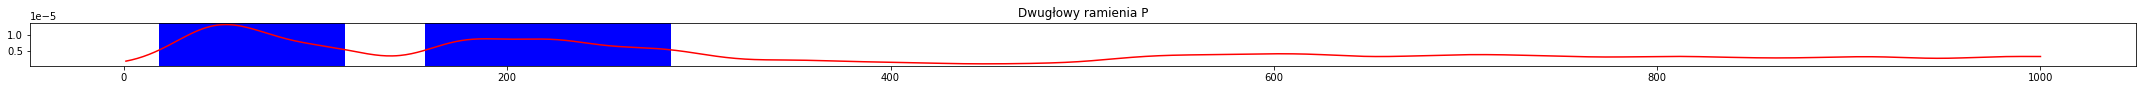

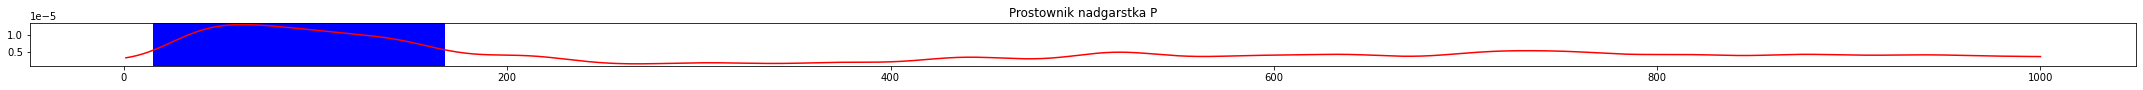

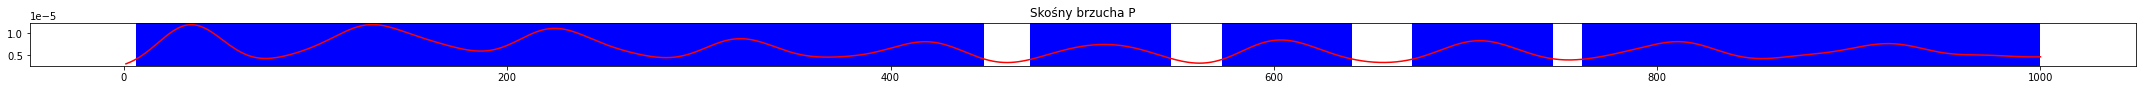

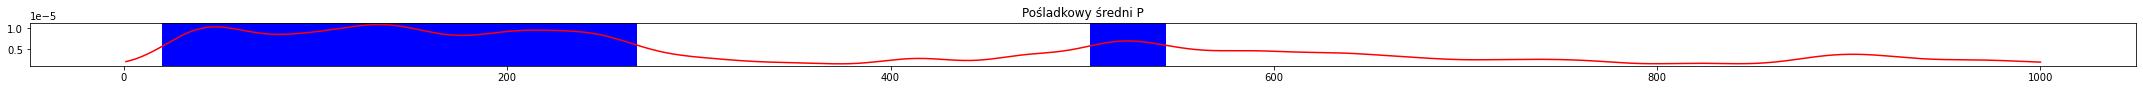

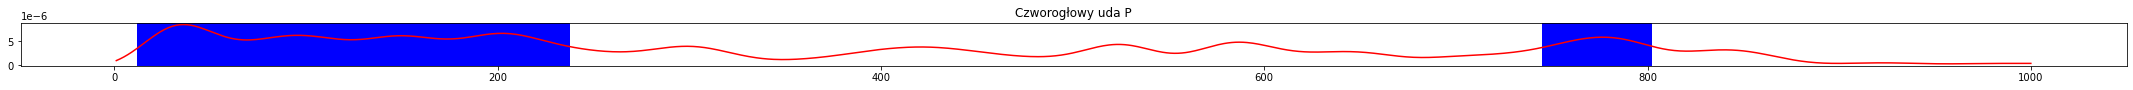

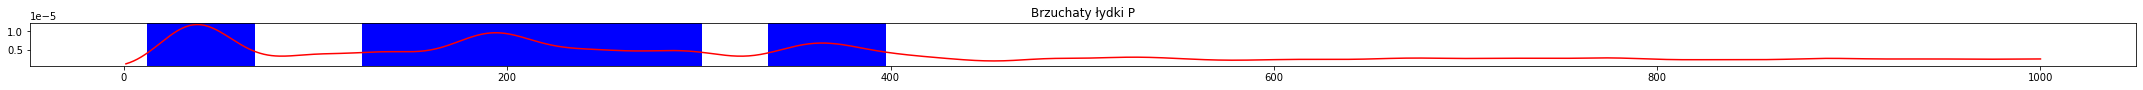

In [43]:
print_onset_offset(aver_arr_all,1000, "std", 2 , 1000/25 , 1000/80)

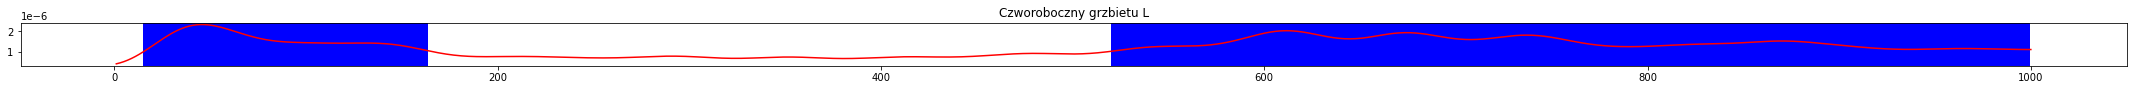

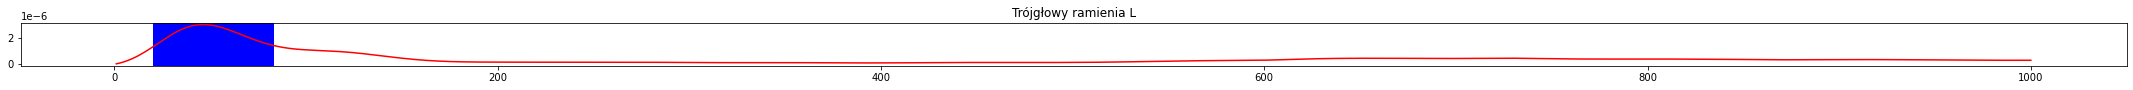

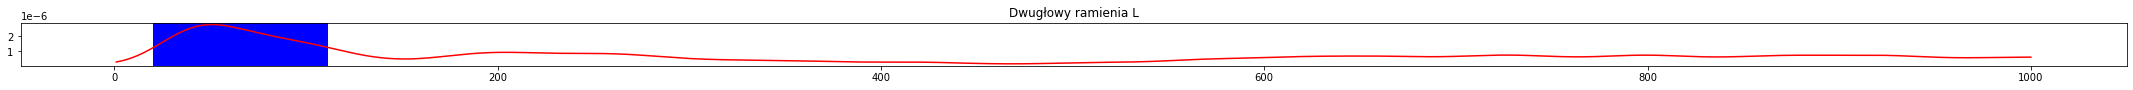

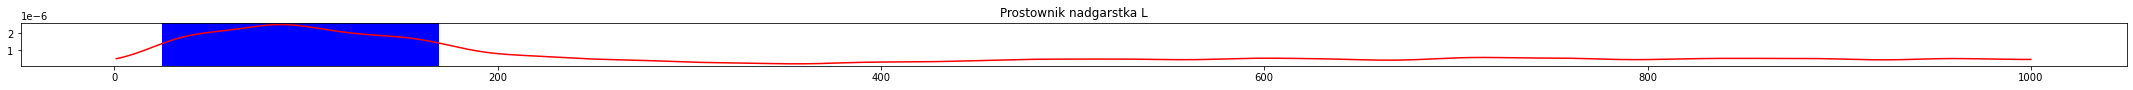

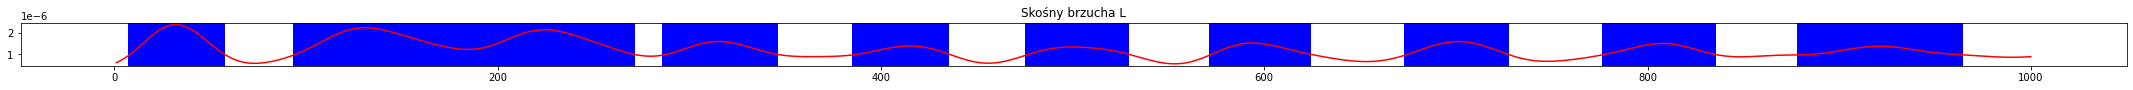

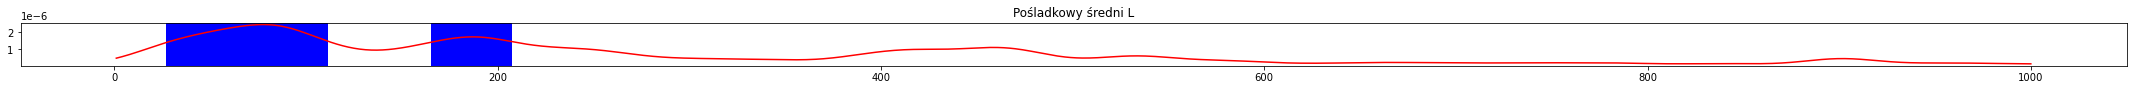

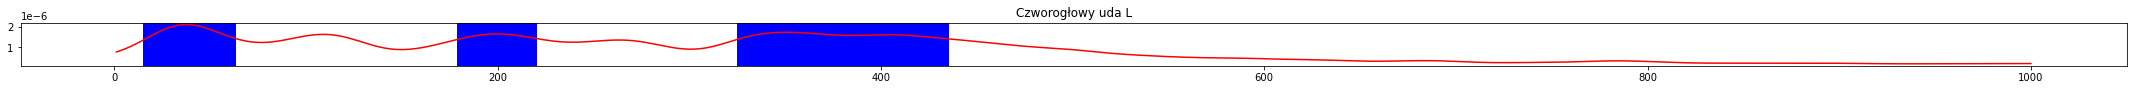

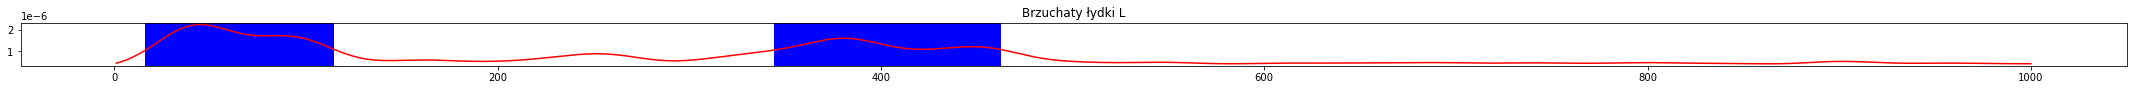

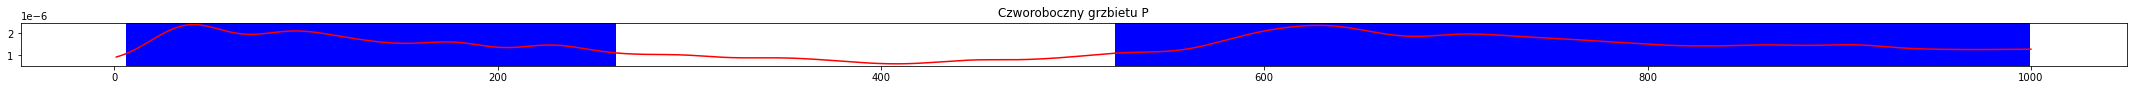

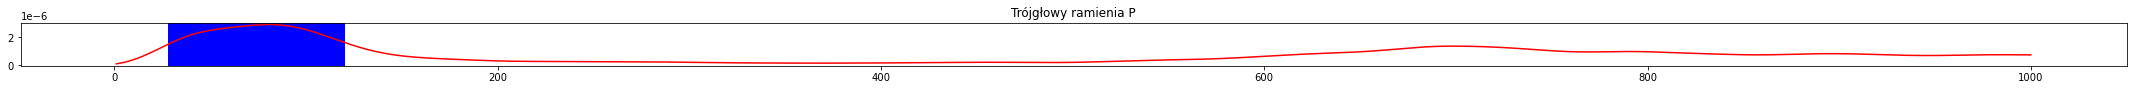

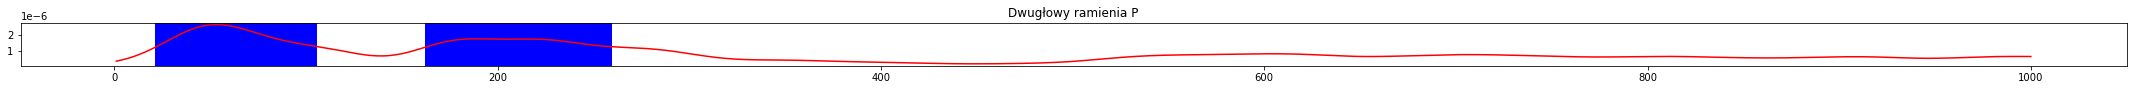

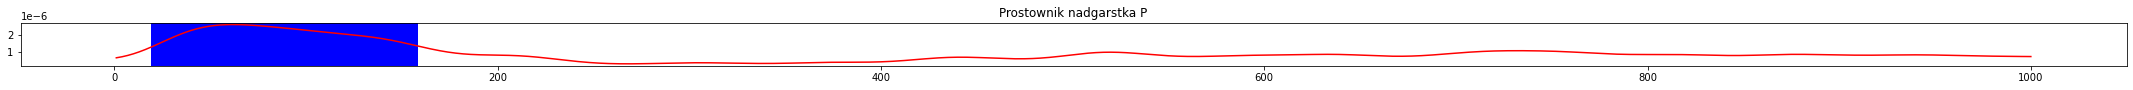

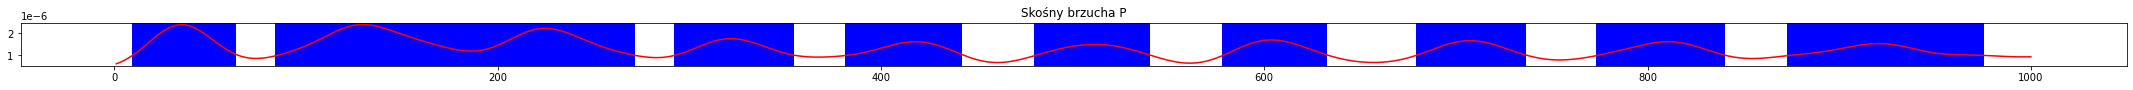

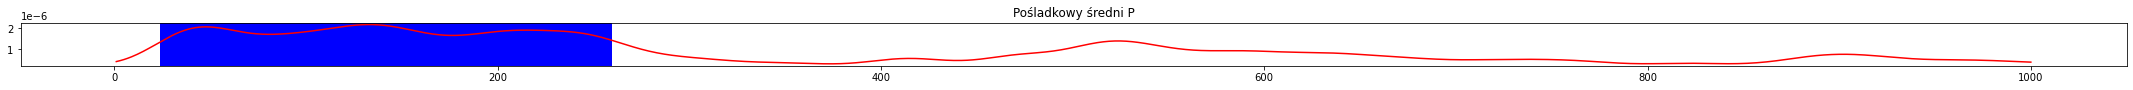

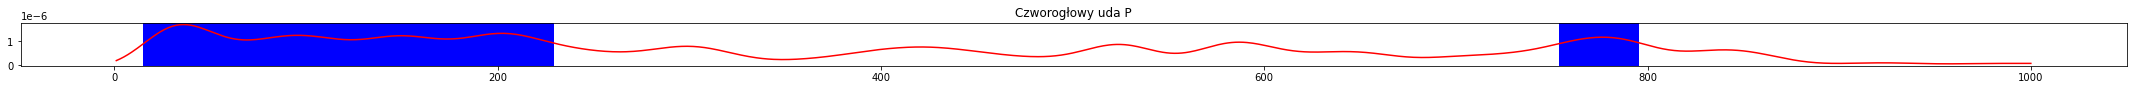

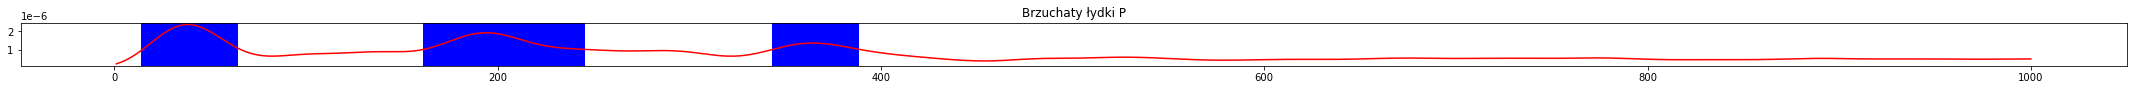

In [44]:
print_onset_offset(aver_arr_all,1000, "std", 2.4 , 1000/25 , 1000/80)

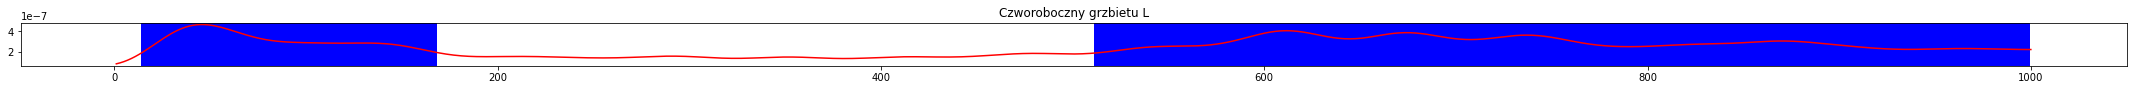

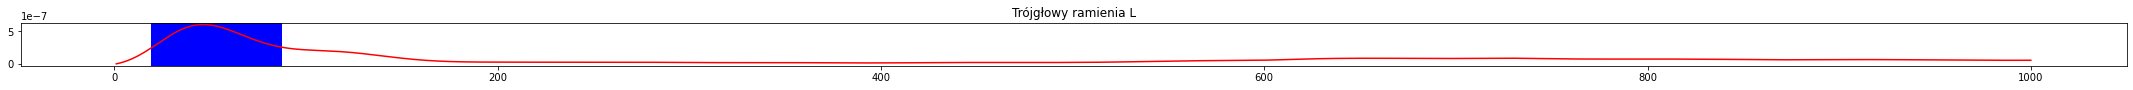

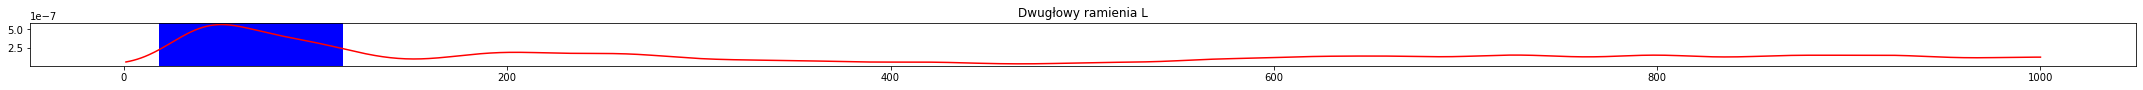

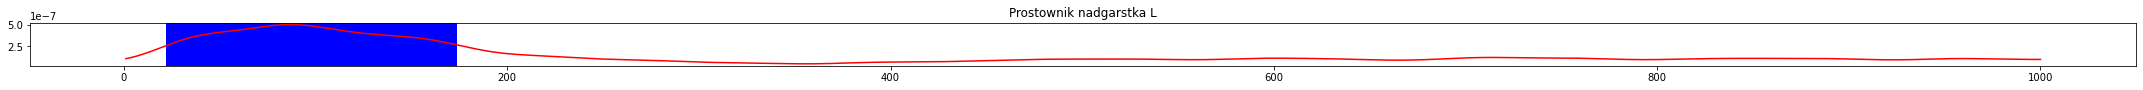

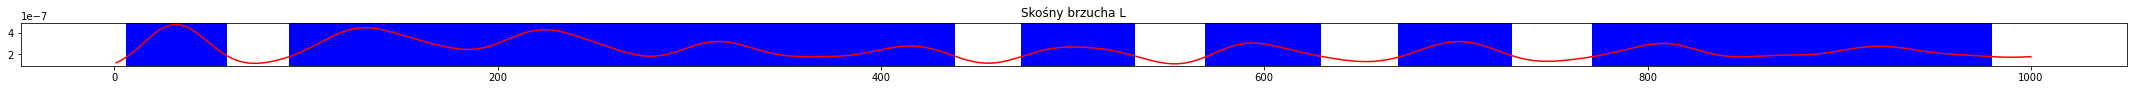

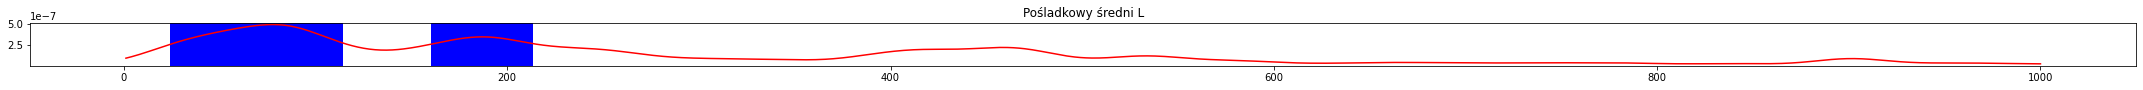

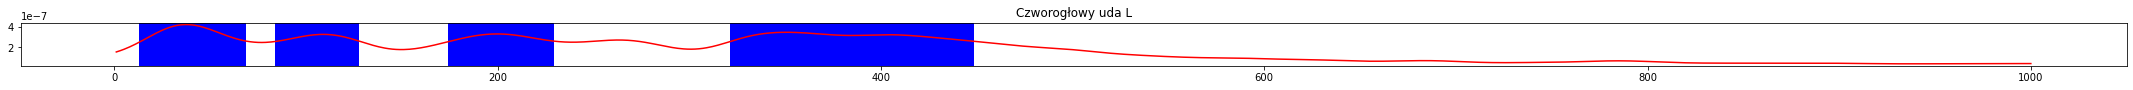

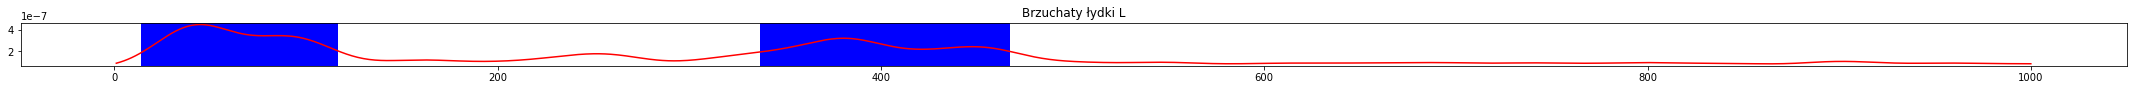

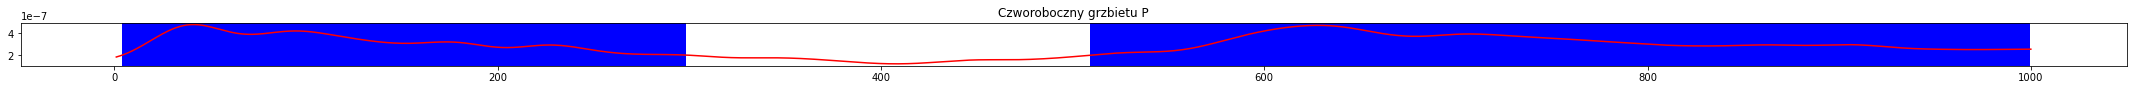

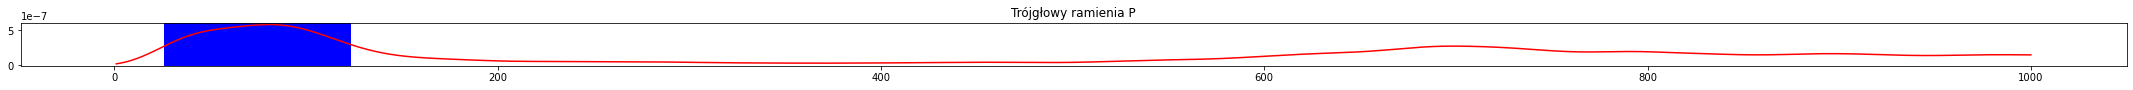

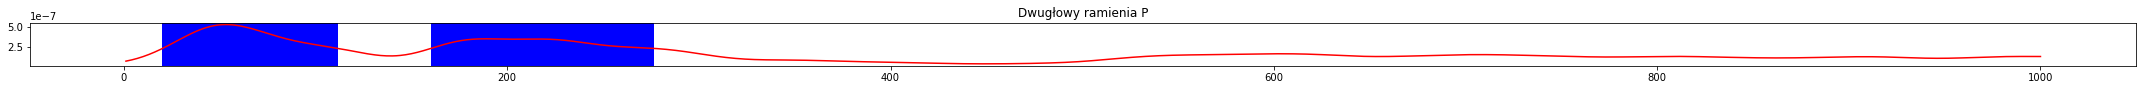

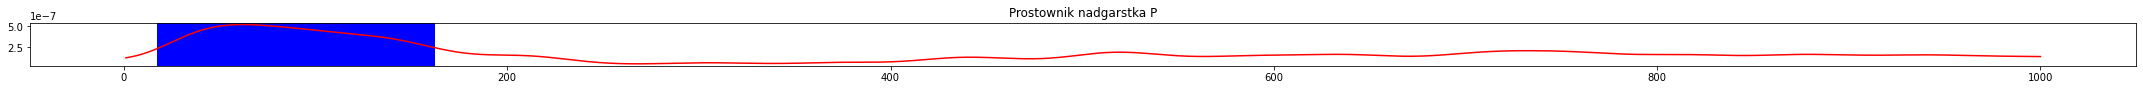

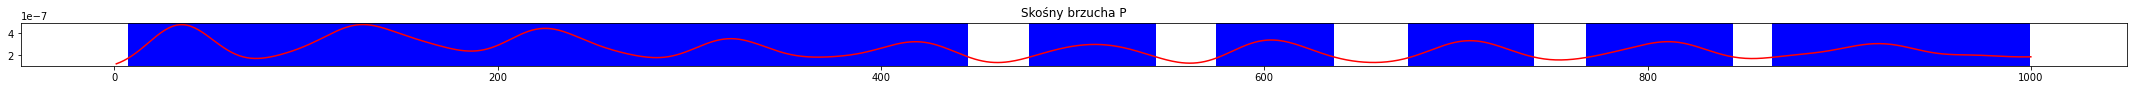

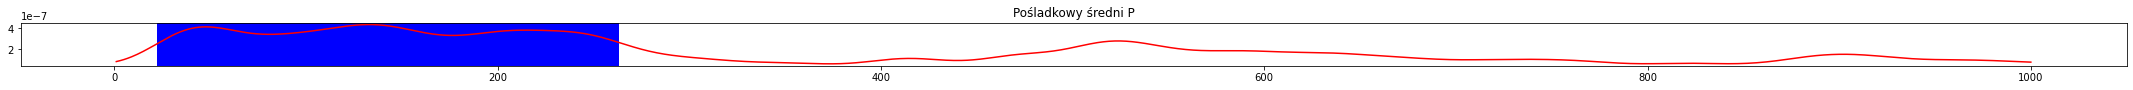

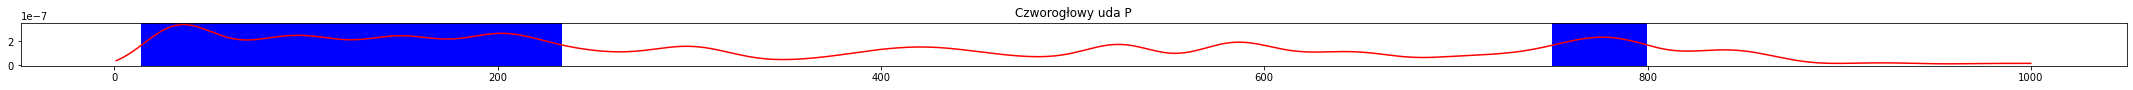

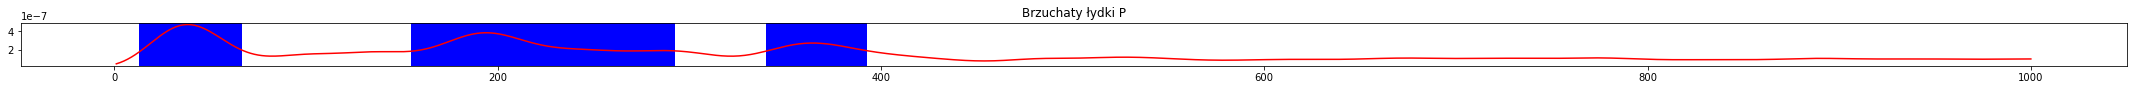

In [45]:
print_onset_offset(aver_arr_all,1000, "std", 2.2 , 1000/25 , 1000/80)

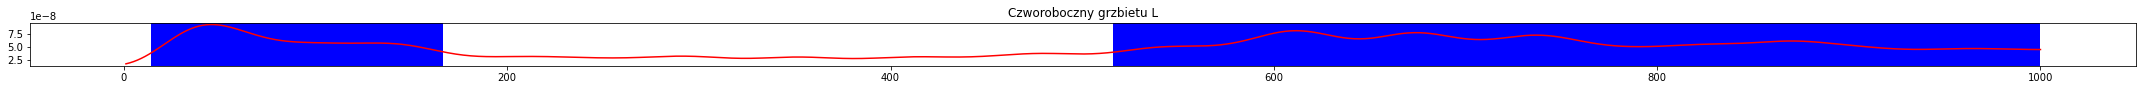

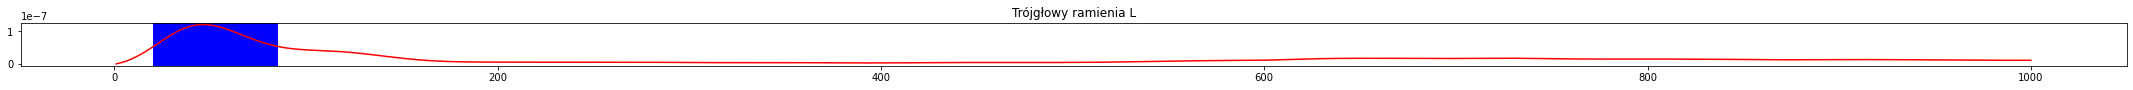

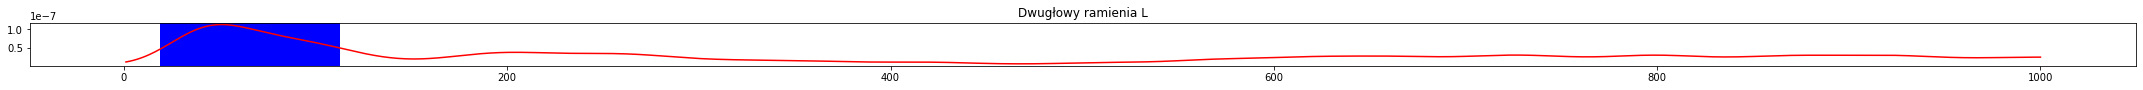

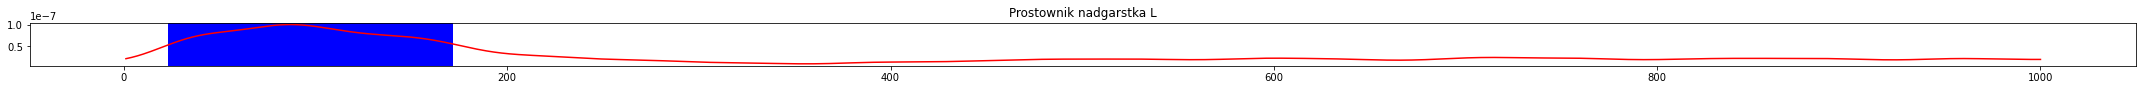

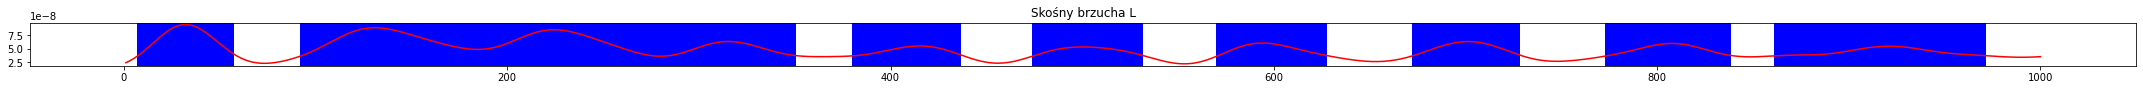

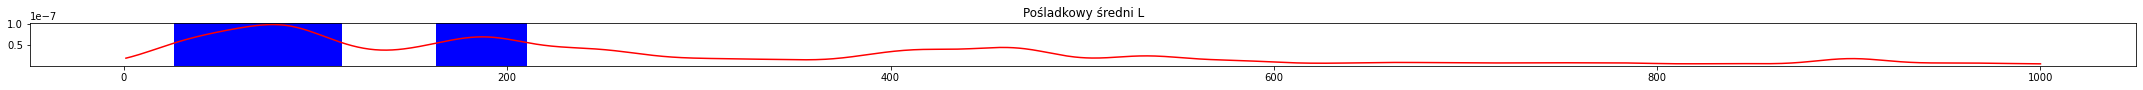

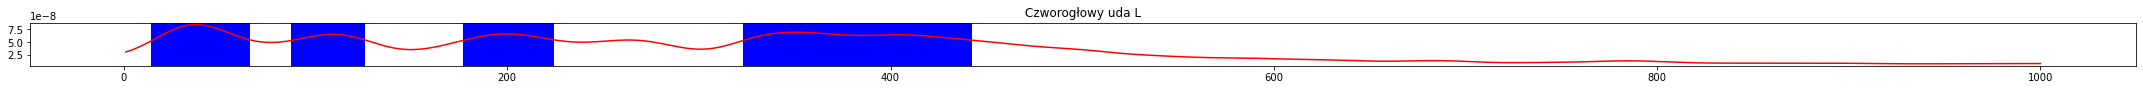

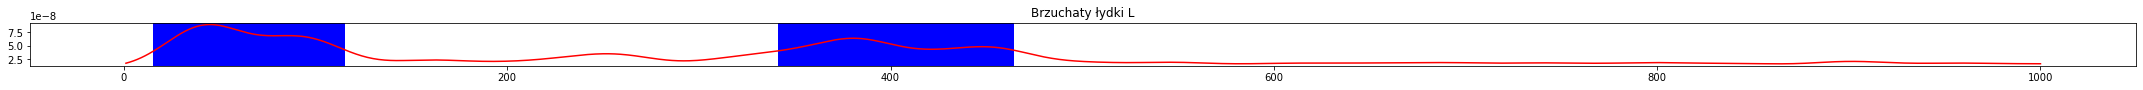

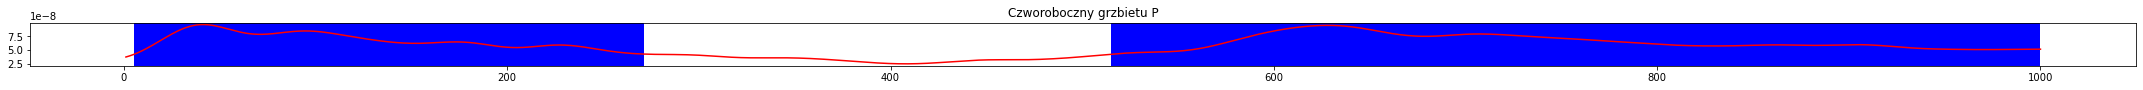

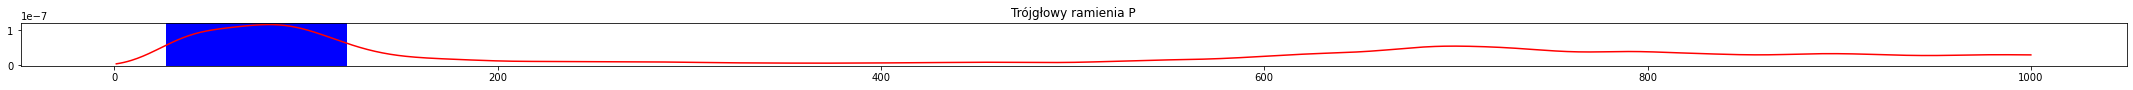

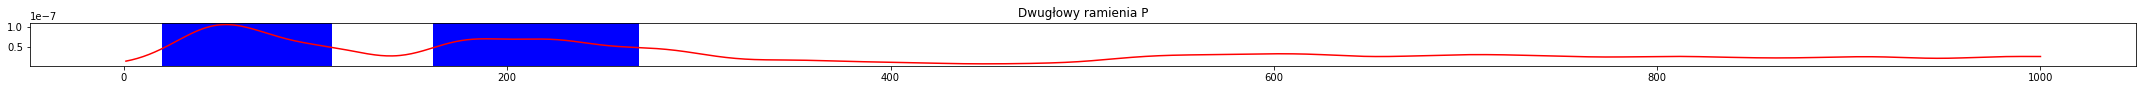

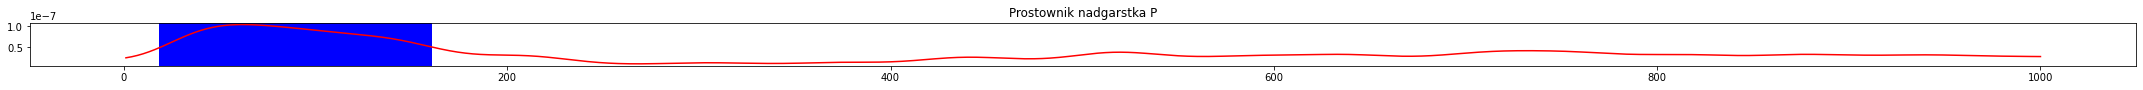

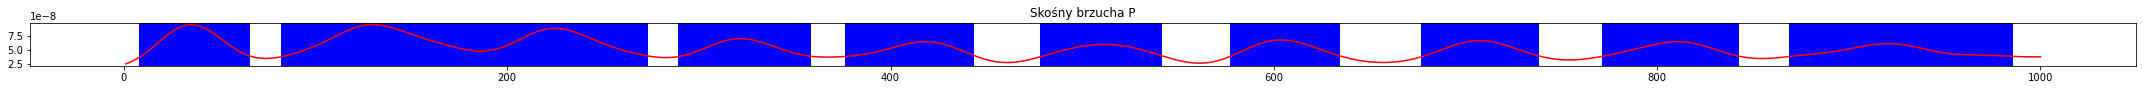

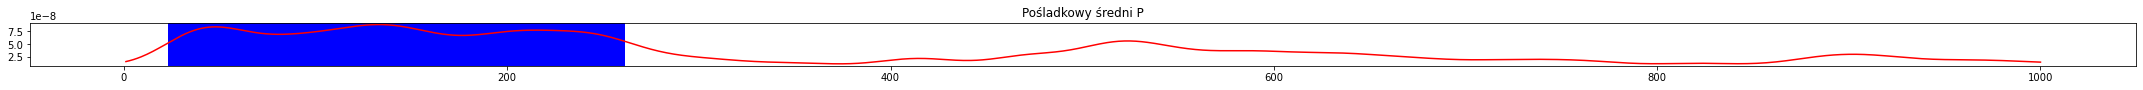

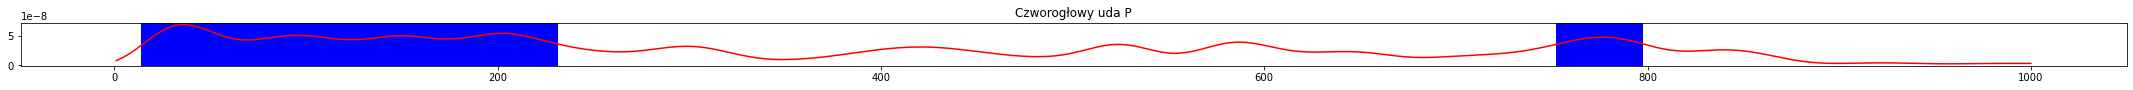

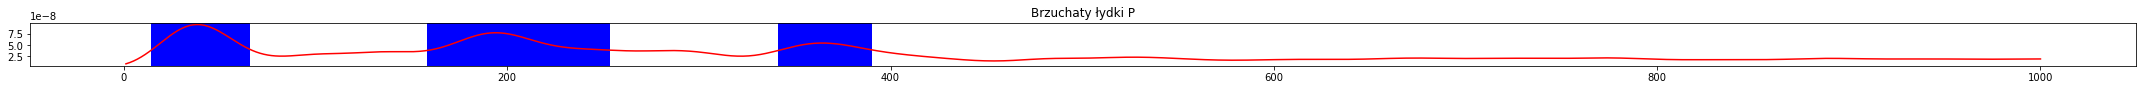

In [46]:
print_onset_offset(aver_arr_all,1000, "std", 2.3 , 1000/35 , 1000/80)

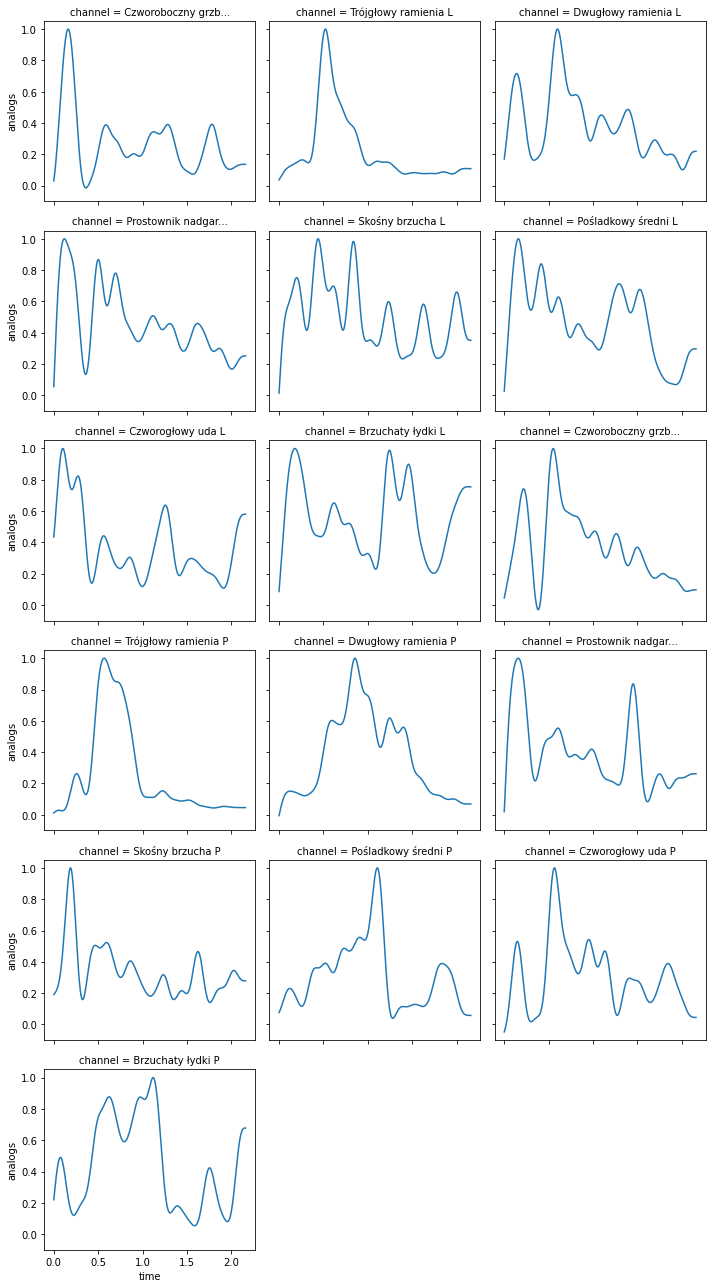

In [47]:
datapath_fullmove = r"Z:\Miecz\B0445\2020-08-06-B0445-S01\2020-08-06-B0445-S01-E02-T05.c3d"
datapath_fullmove  =r"Z:\baza\2020-08-05-B0445-S01-E02-T05-K1.c3d"
datapath_fullmove  = r"Z:\baza\2020-08-06-B0445-S01-E01-T05-K01.c3d"
emg_data = dp.read_analog_allmuscles(datapath_fullmove)
emg_data=dp.normalize_emg(emg_data)
emg_data = dp.rename_emg(emg_data)
dp.show_emg_data(emg_data )

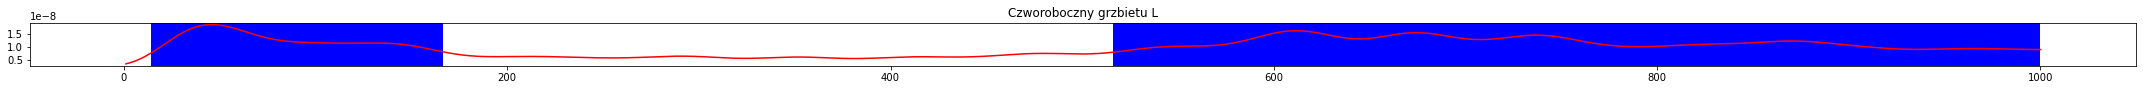

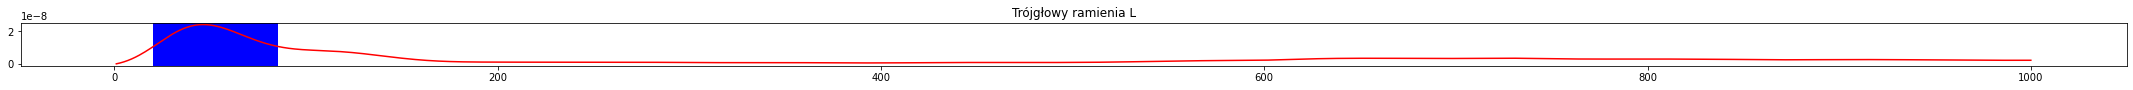

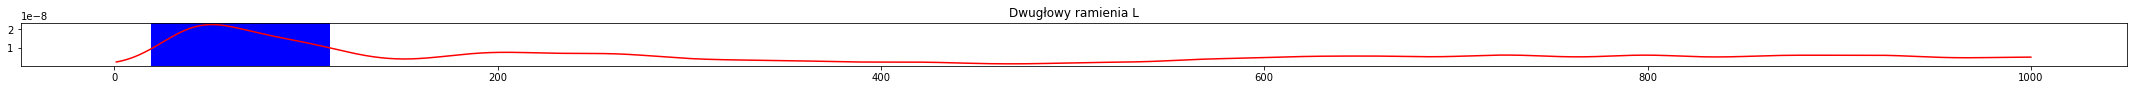

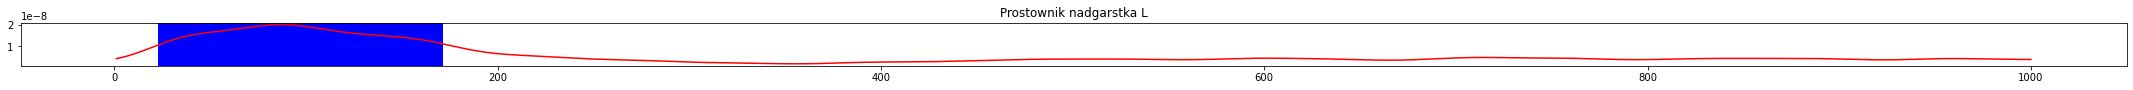

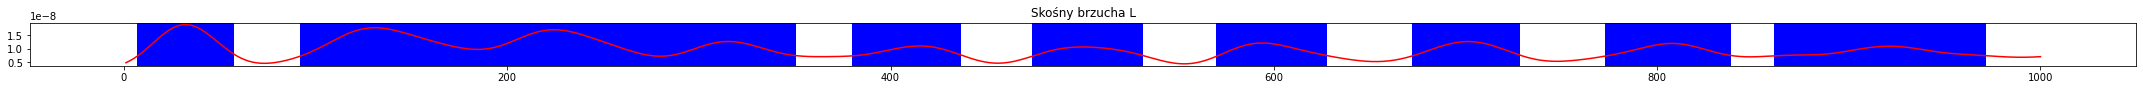

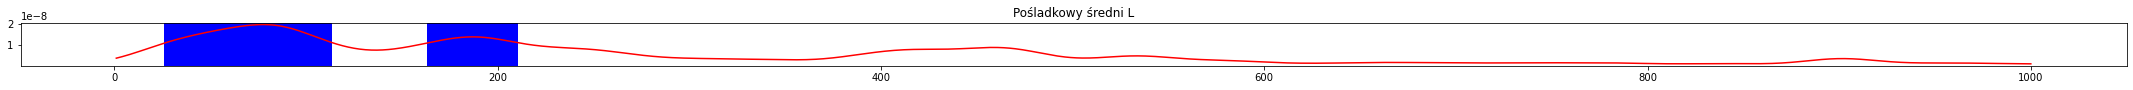

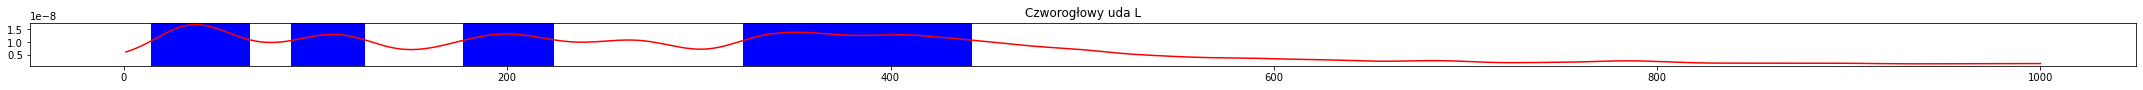

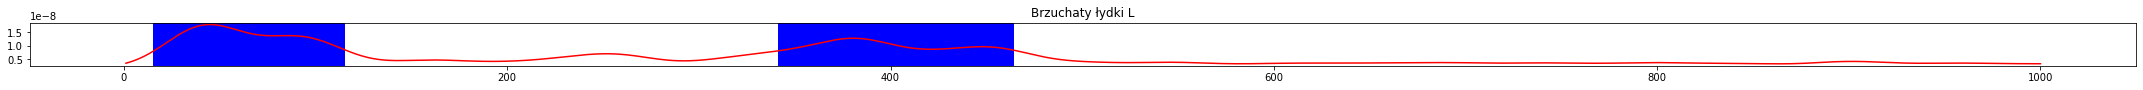

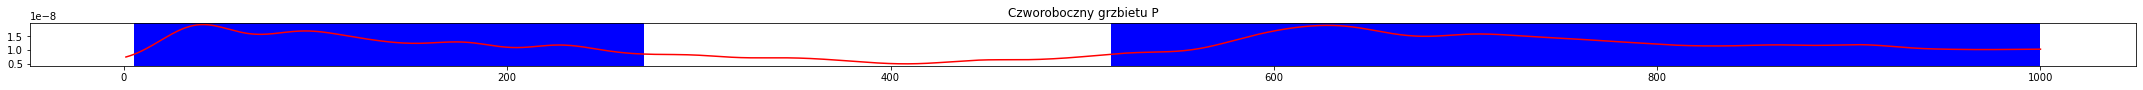

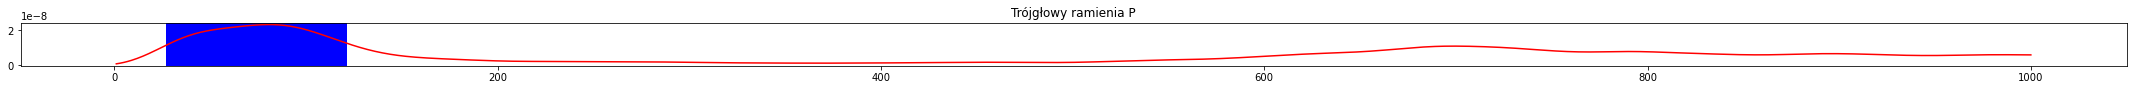

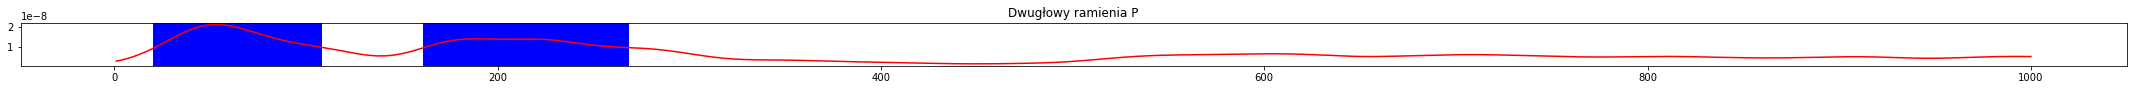

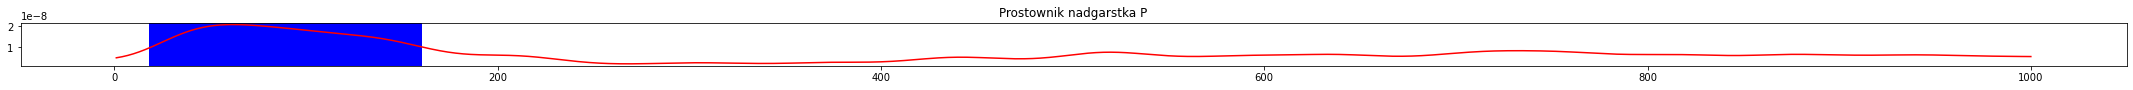

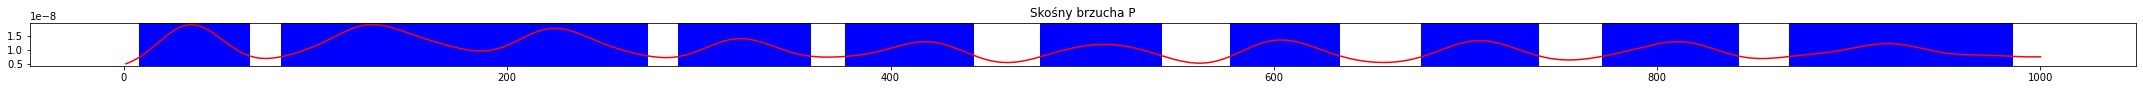

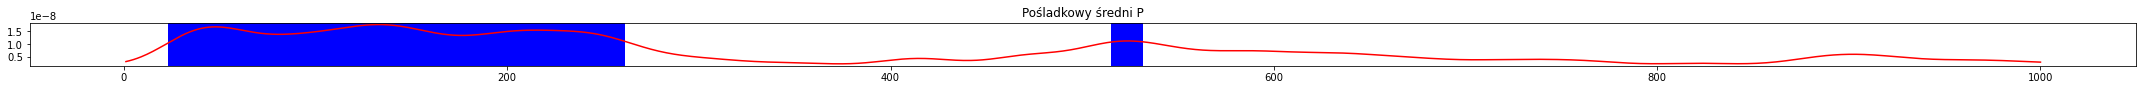

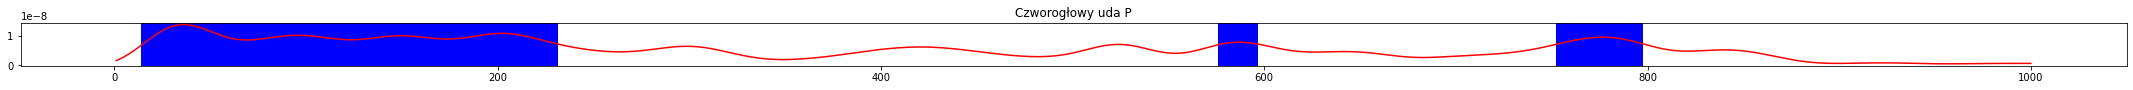

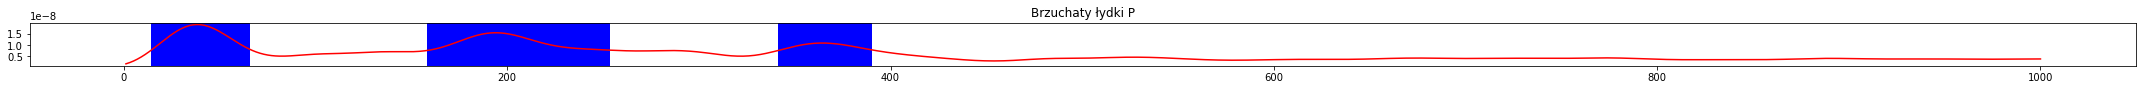

In [48]:
print_onset_offset(aver_arr_all,1000, "std", 2.3 , 1000/70 , 1000/70)

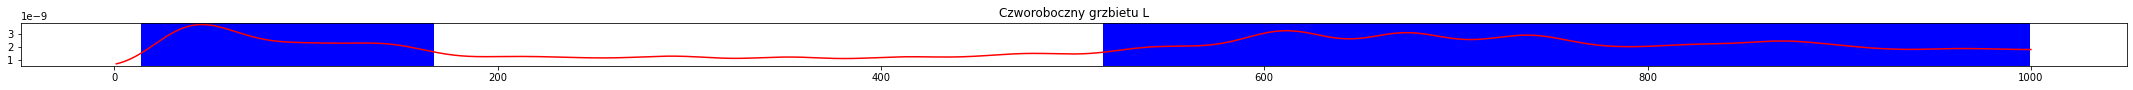

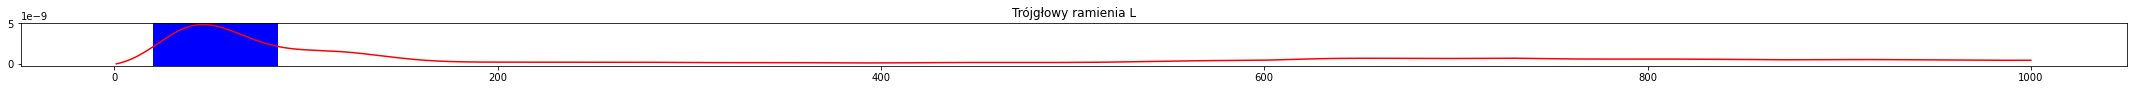

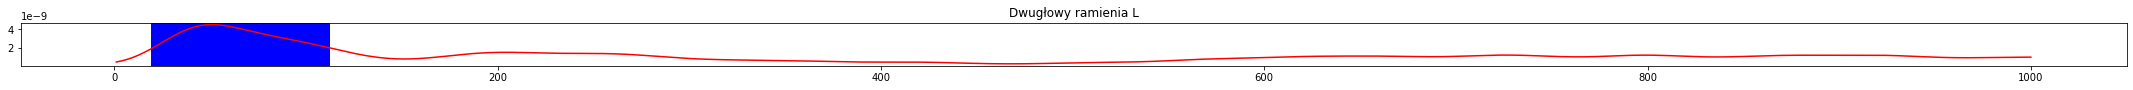

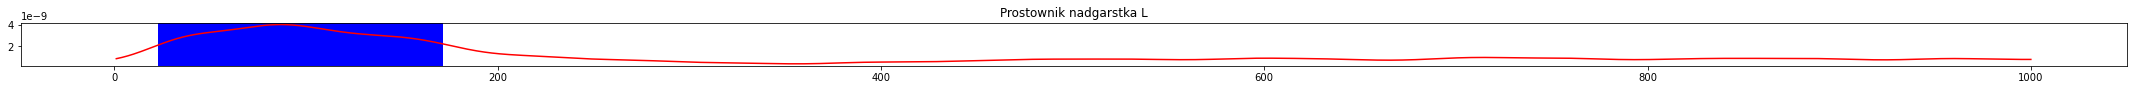

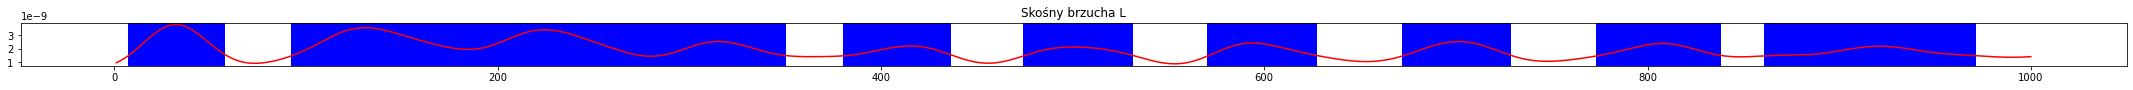

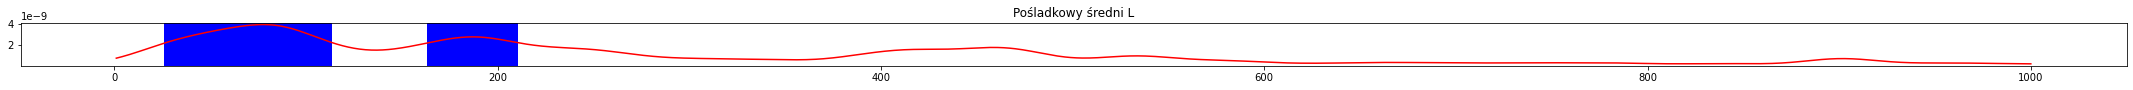

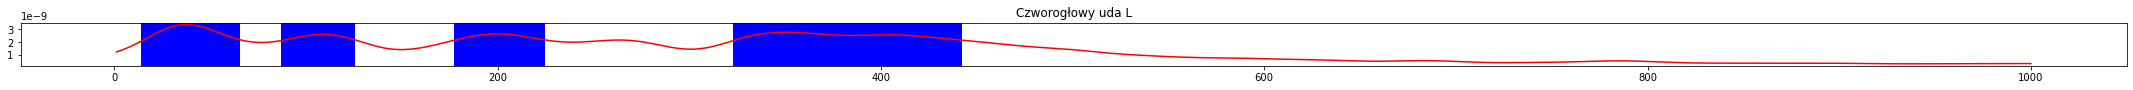

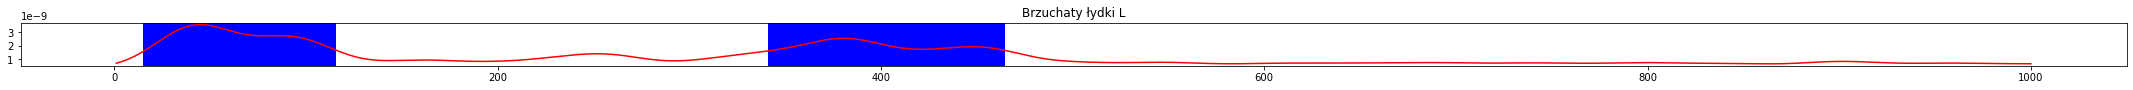

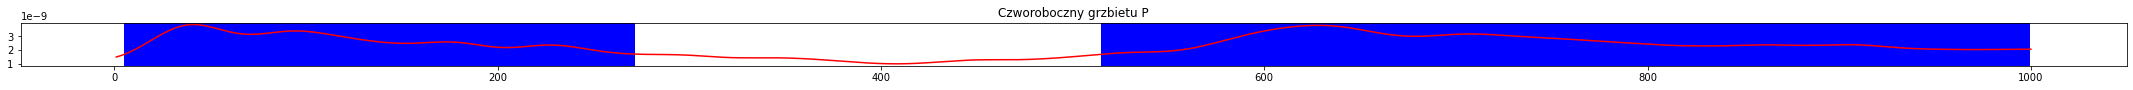

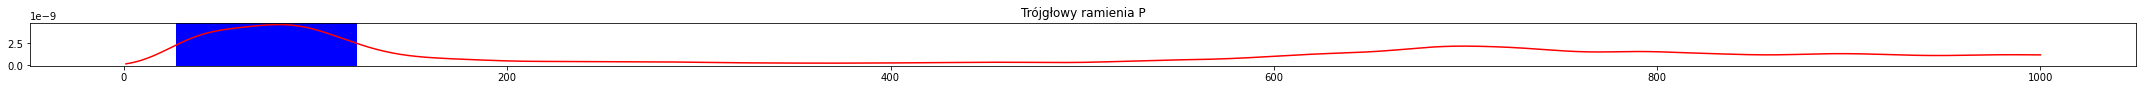

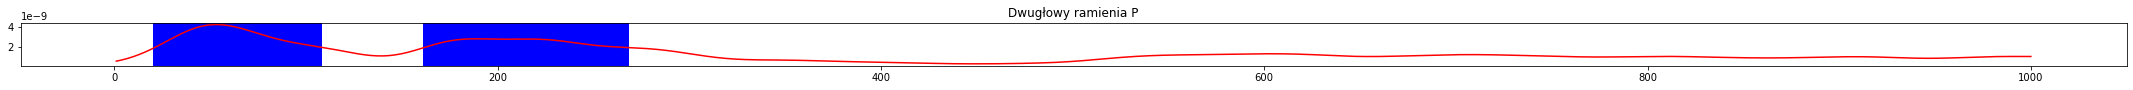

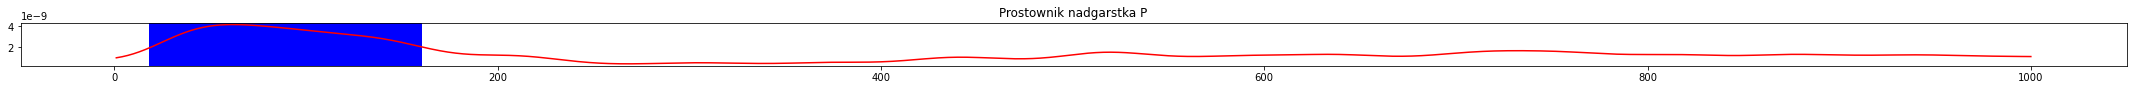

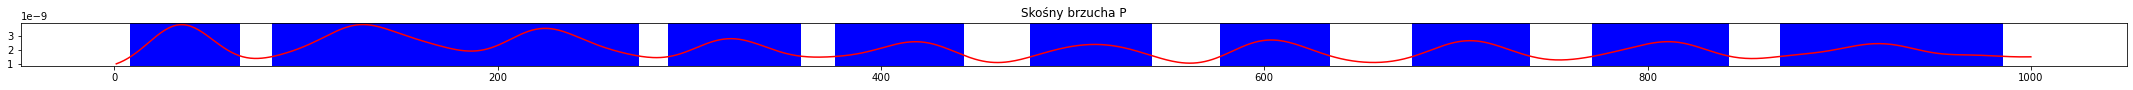

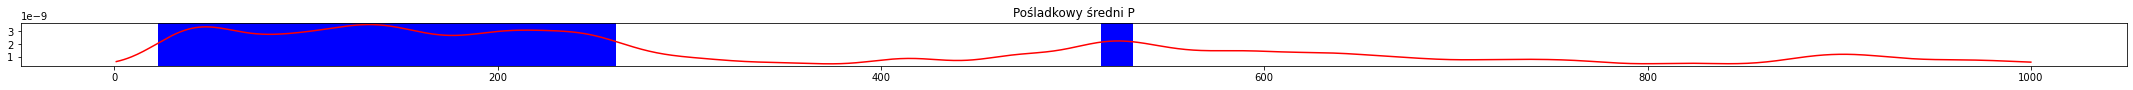

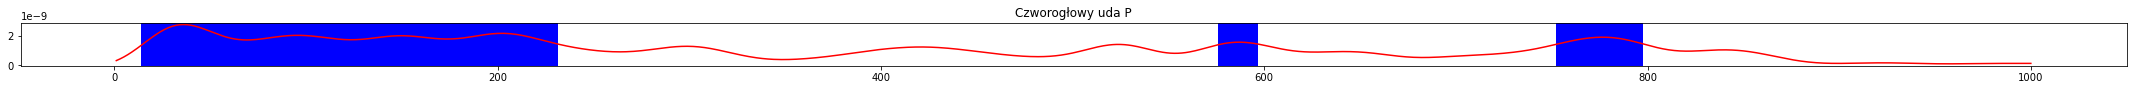

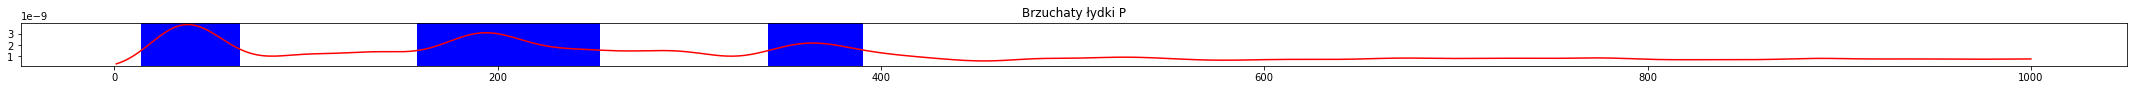

In [49]:
print_onset_offset(aver_arr_all,1000, "std", 2.3 , 1000/80 , 1000/70)

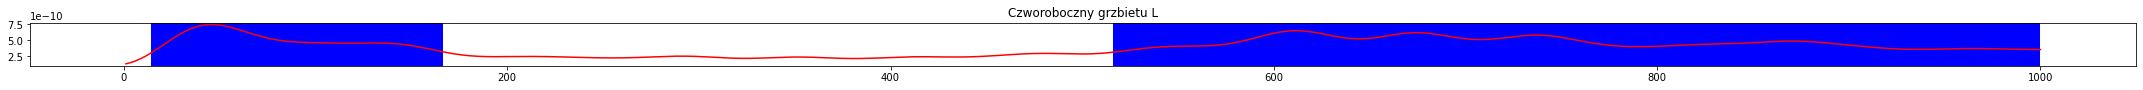

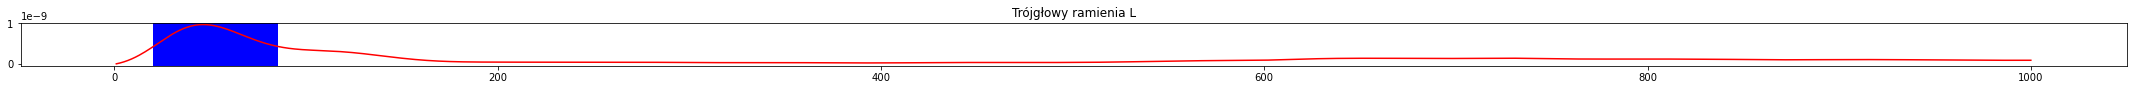

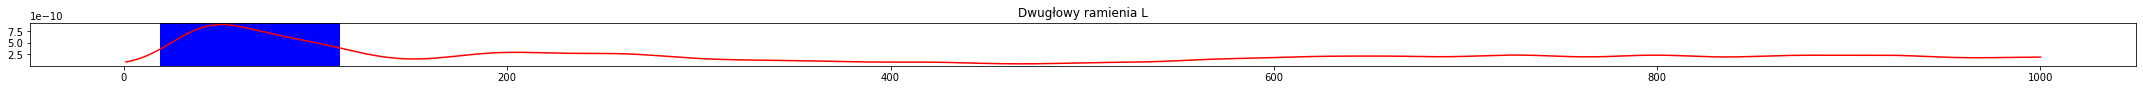

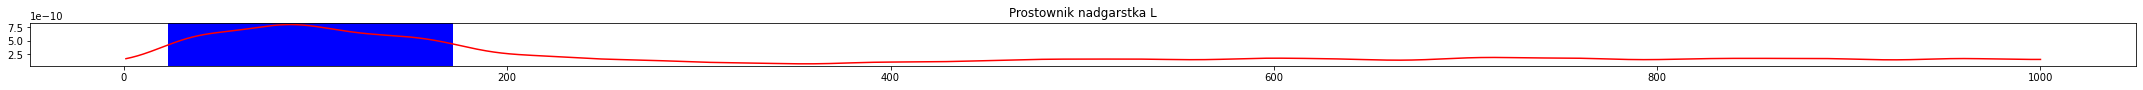

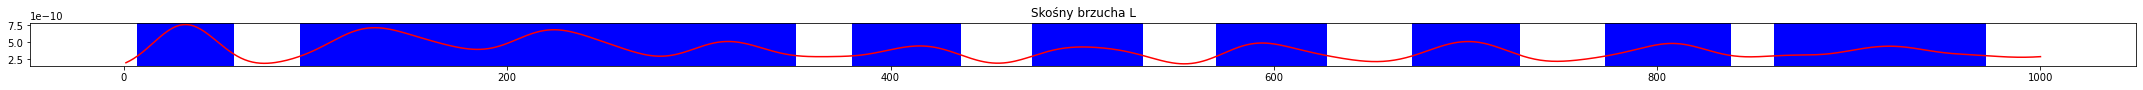

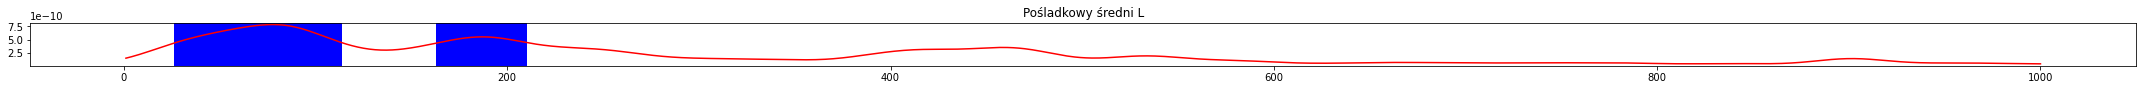

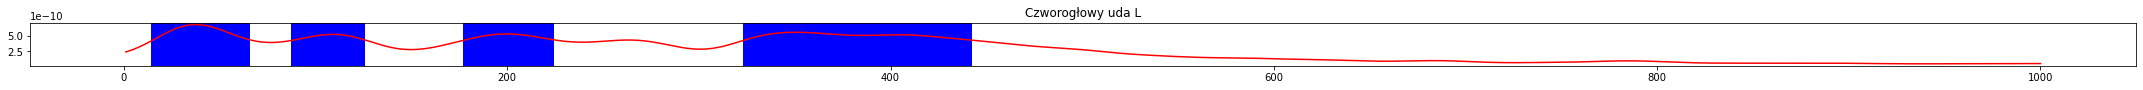

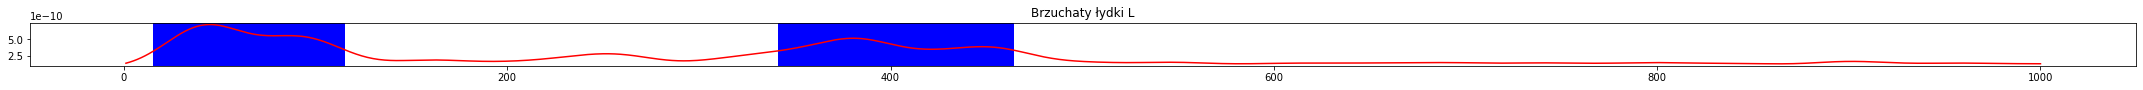

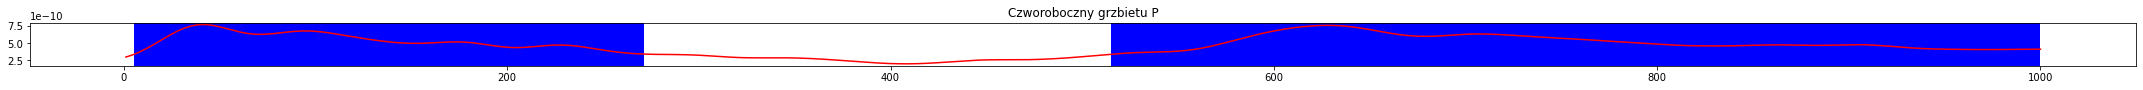

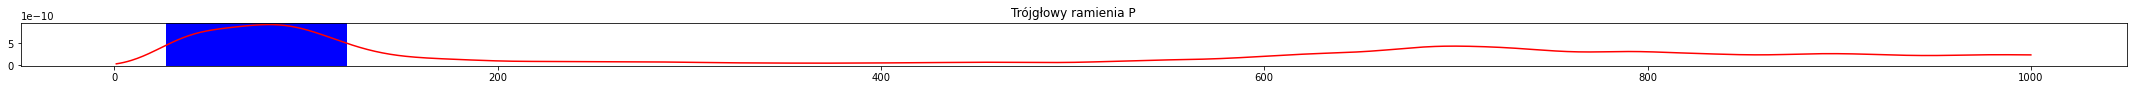

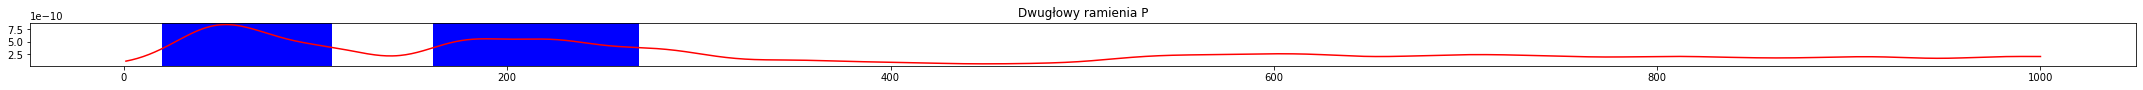

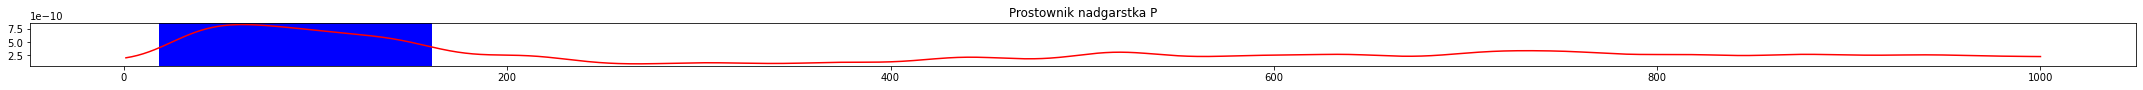

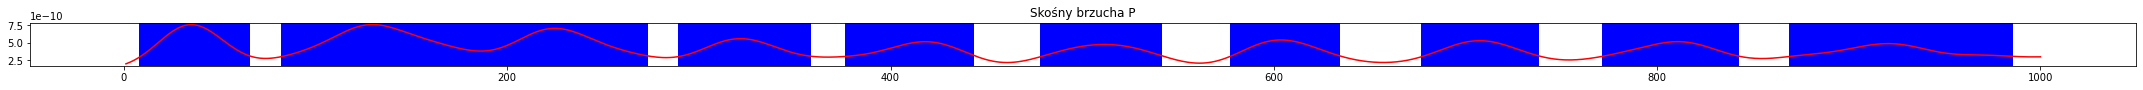

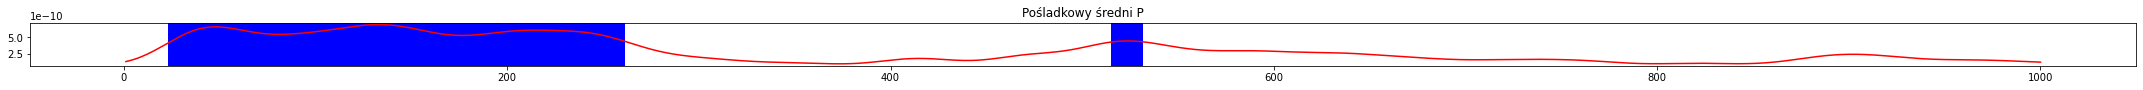

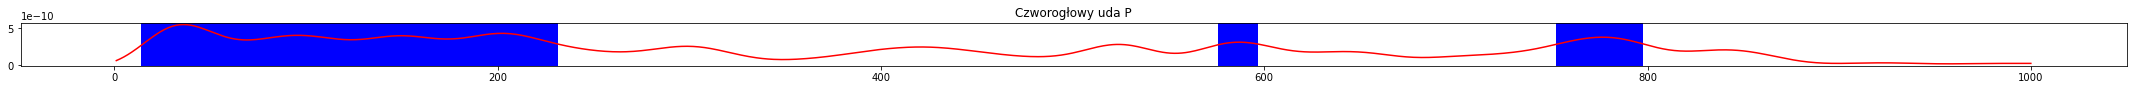

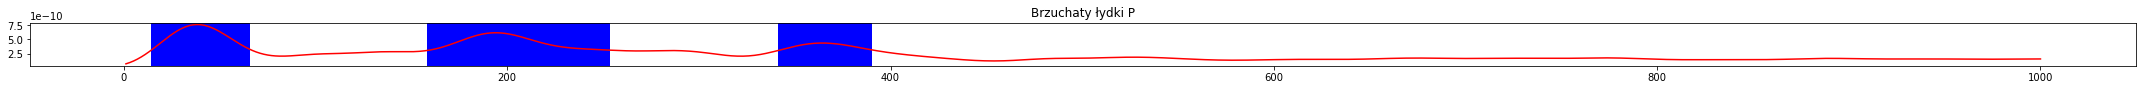

In [50]:
print_onset_offset(aver_arr_all,1000, "std", 2.3 , 1000/90 , 1000/80)

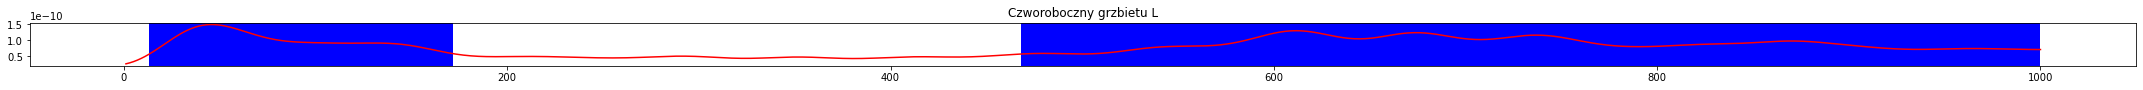

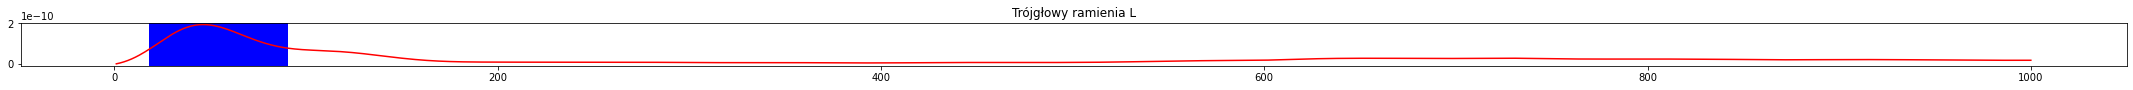

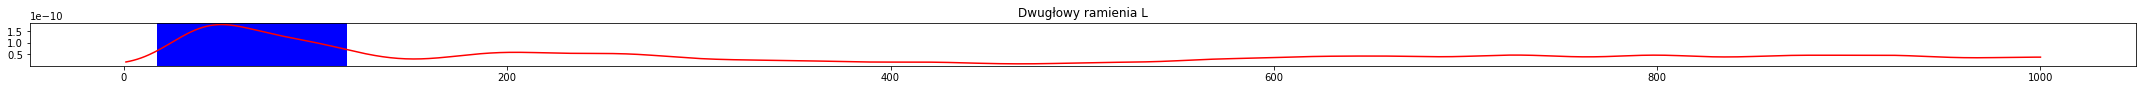

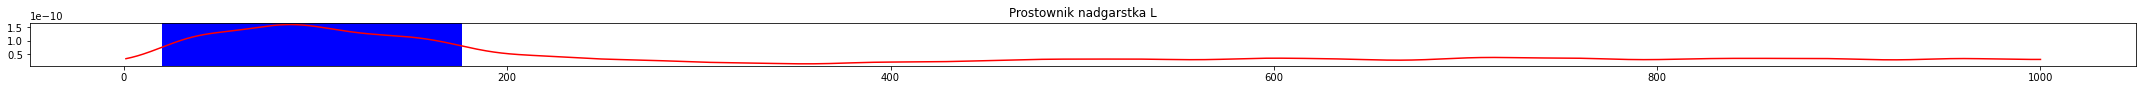

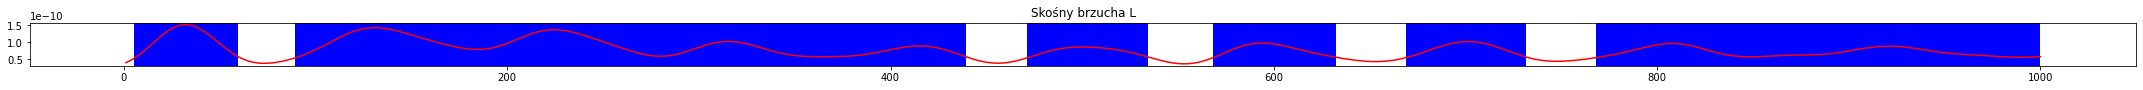

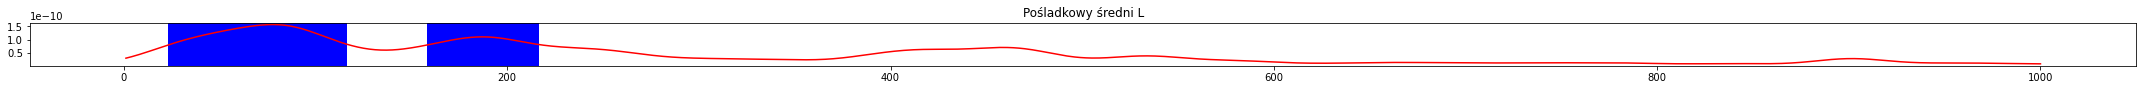

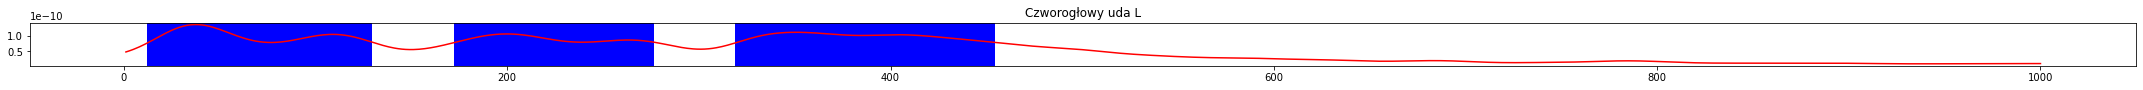

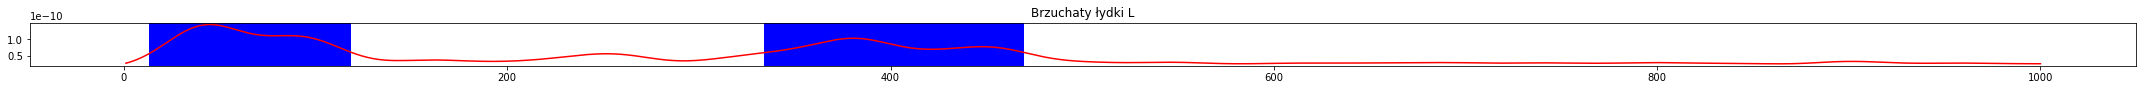

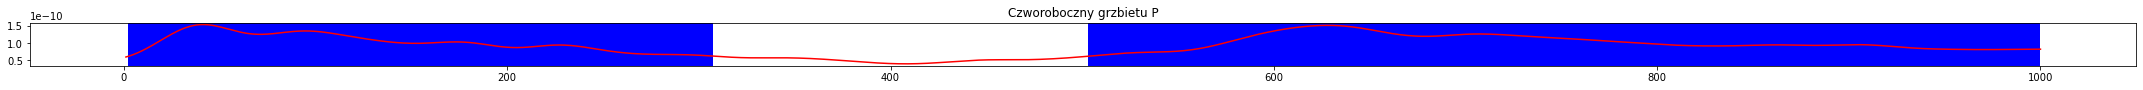

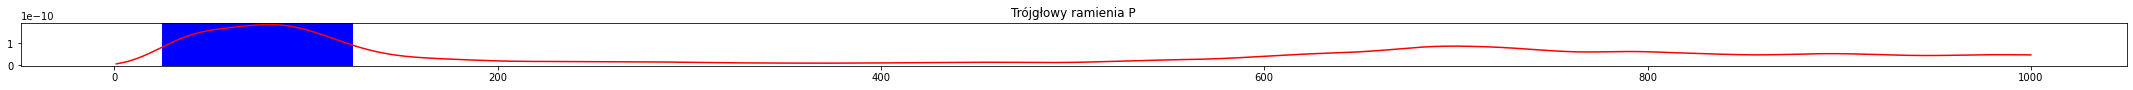

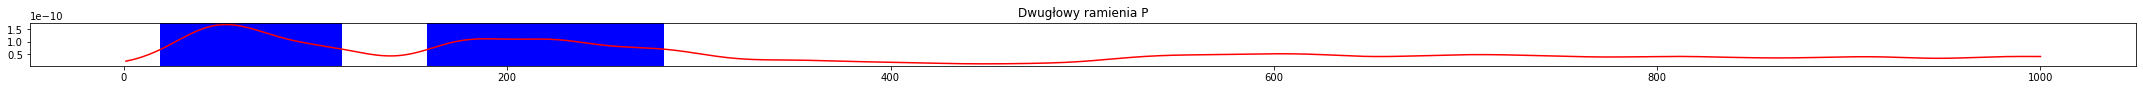

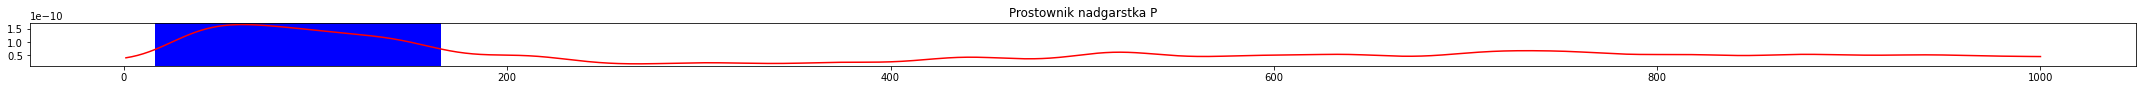

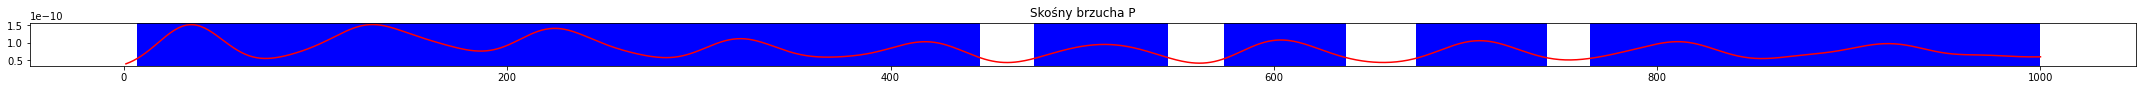

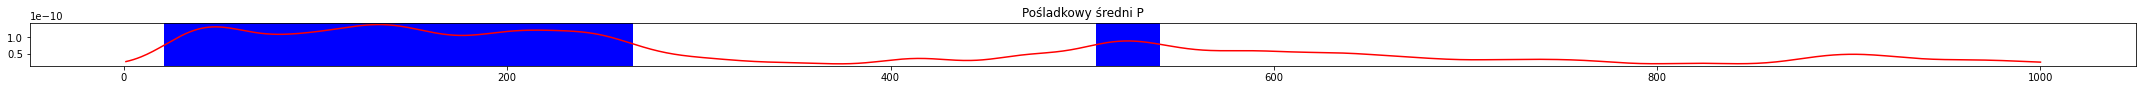

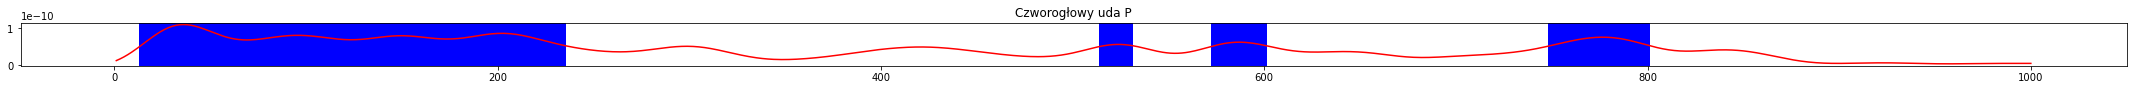

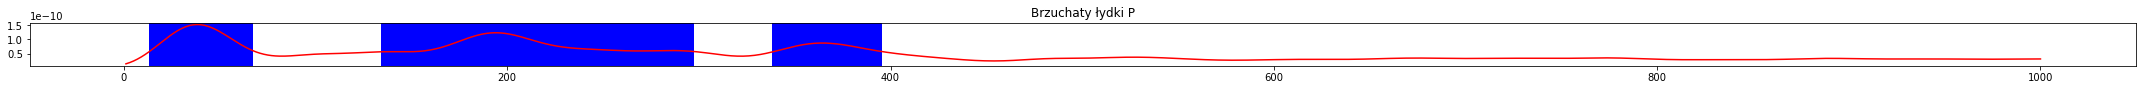

In [51]:
print_onset_offset(aver_arr_all,1000, "std", 2.1 , 1000/90 , 1000/80)

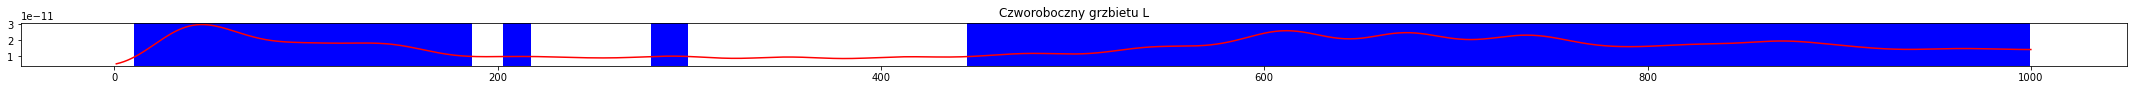

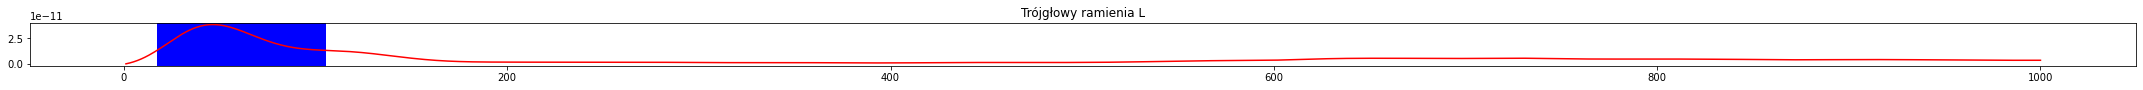

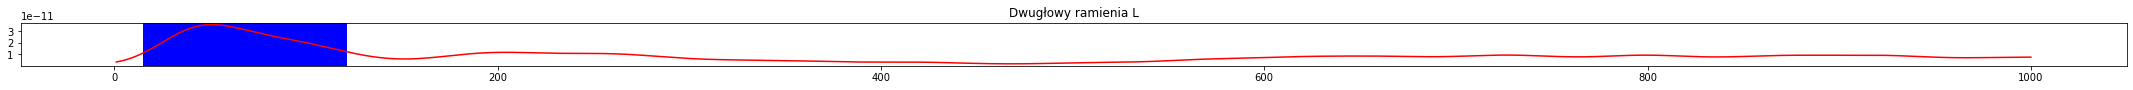

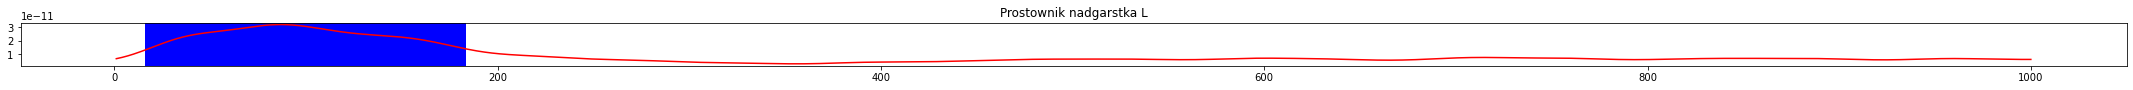

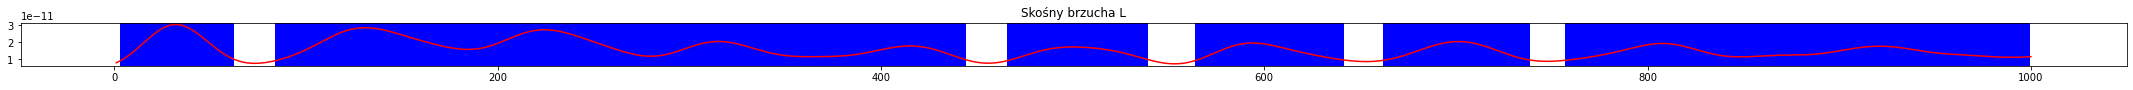

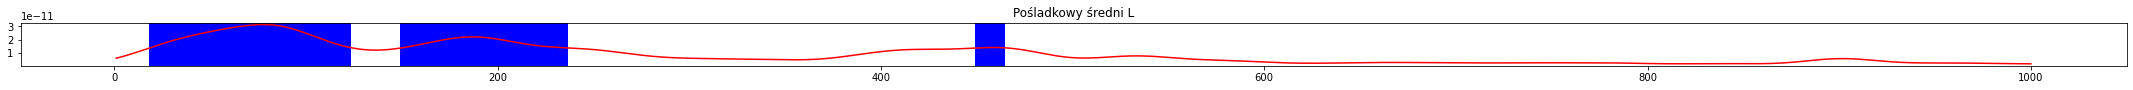

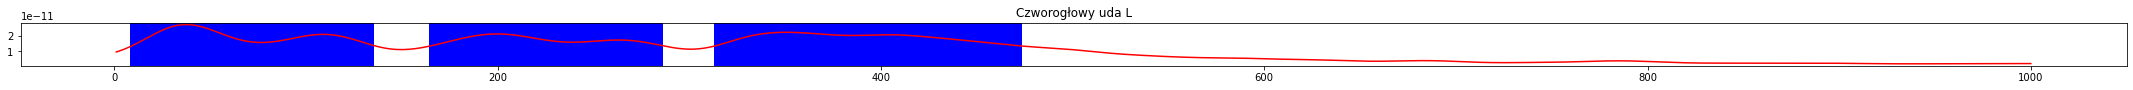

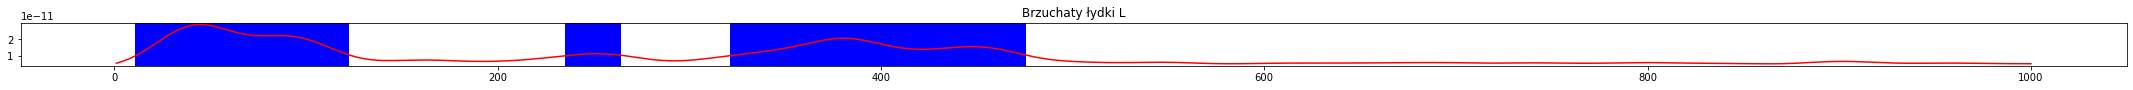

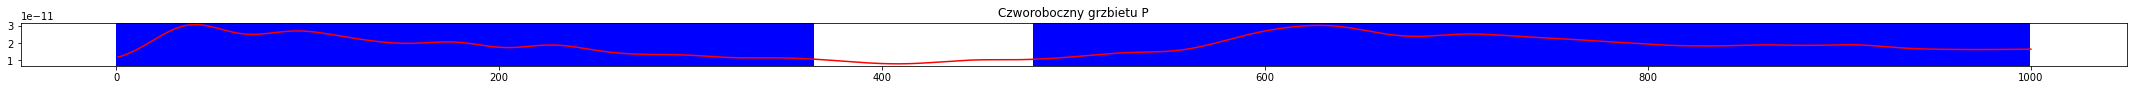

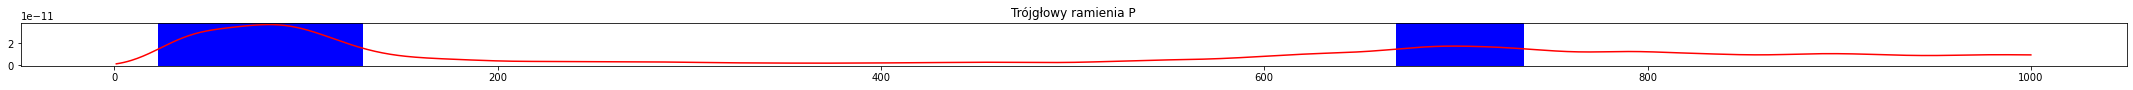

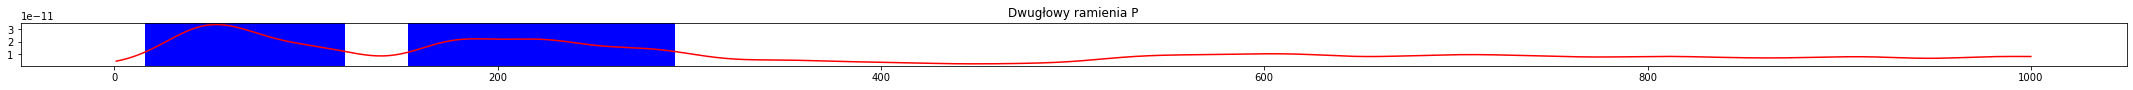

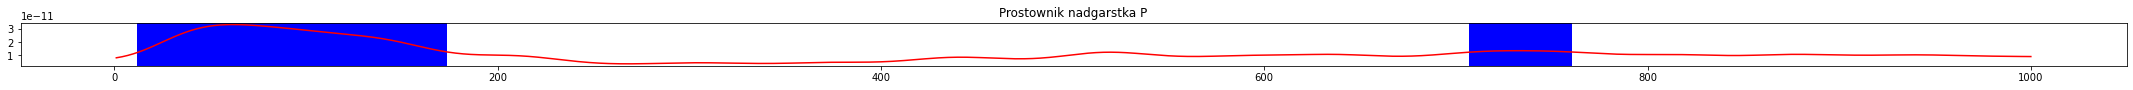

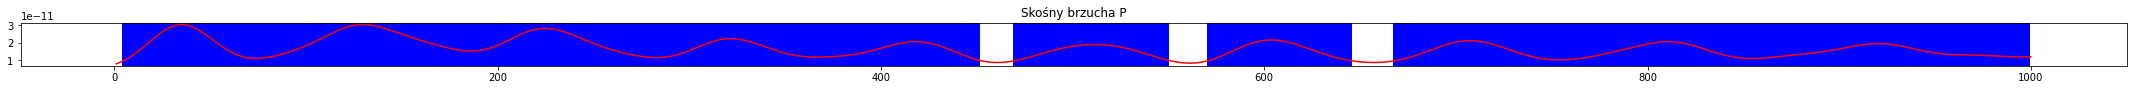

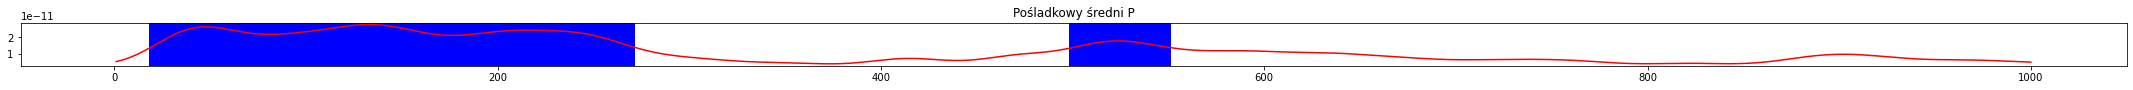

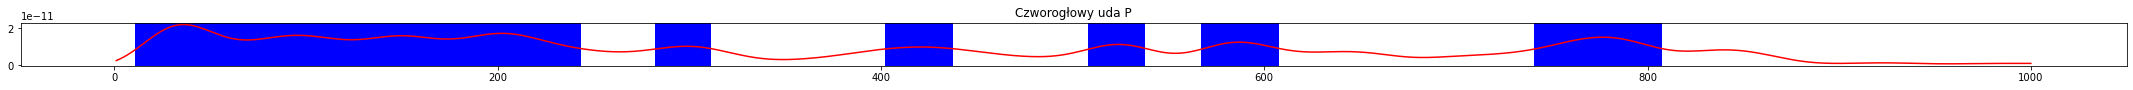

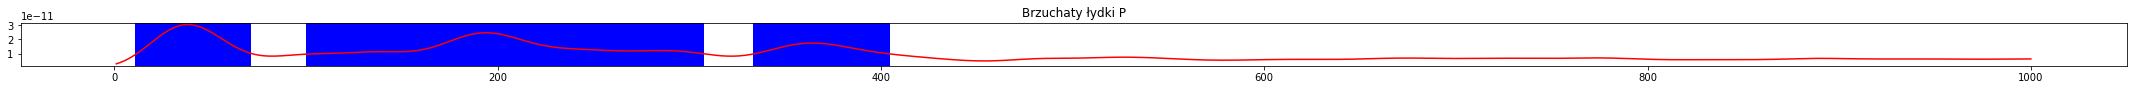

In [52]:
print_onset_offset(aver_arr_all,1000, "std", 1.8 , 1000/90 , 1000/80)

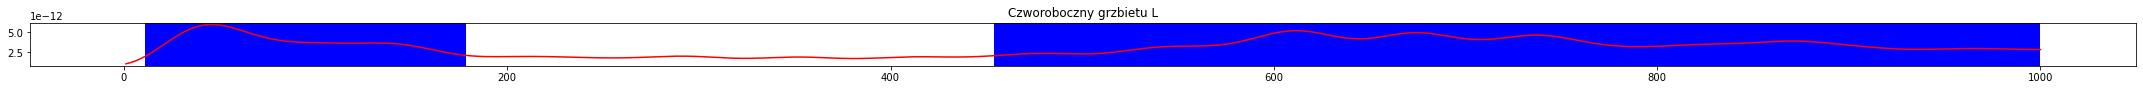

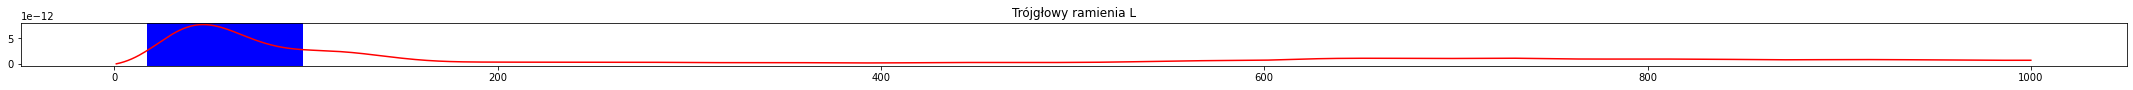

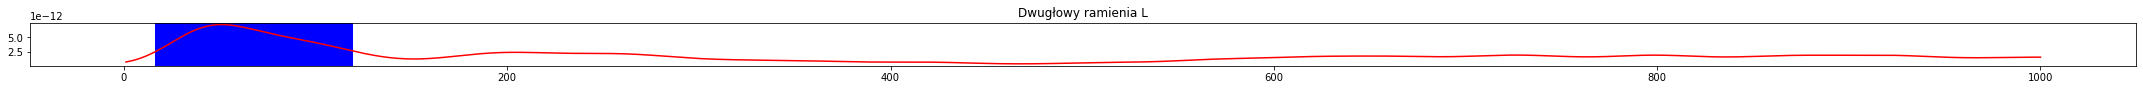

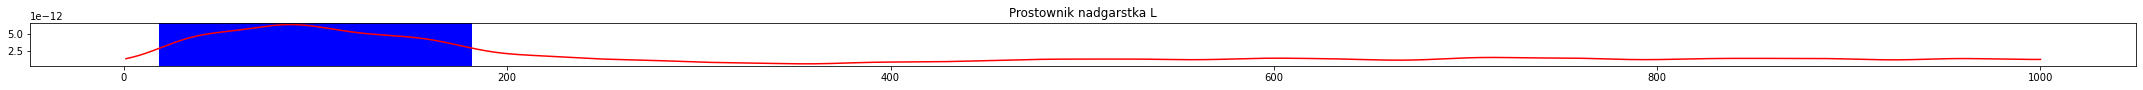

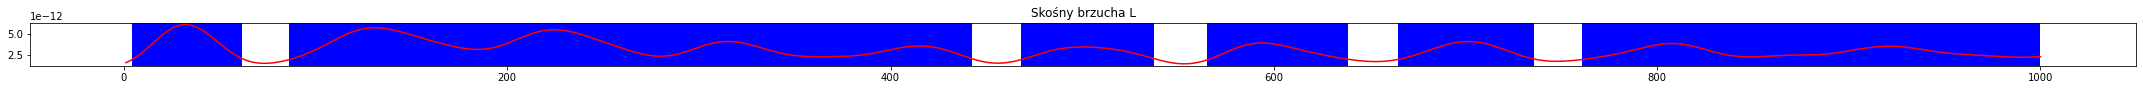

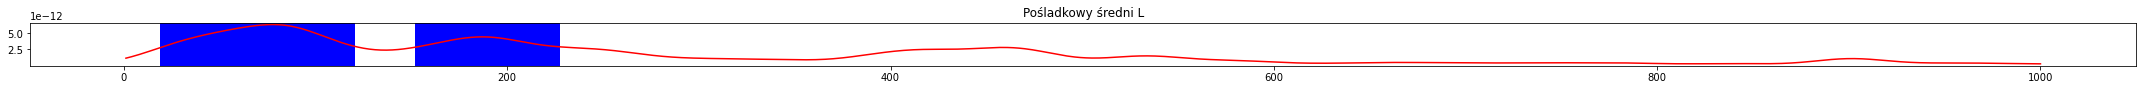

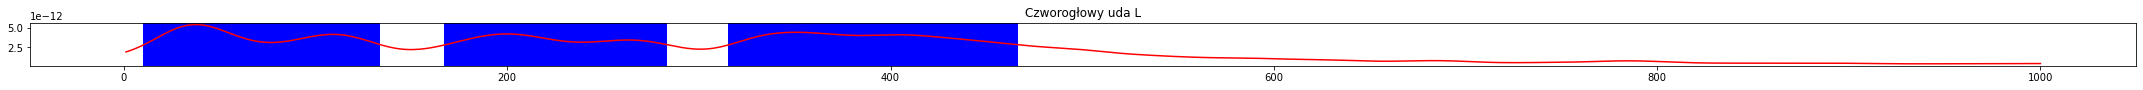

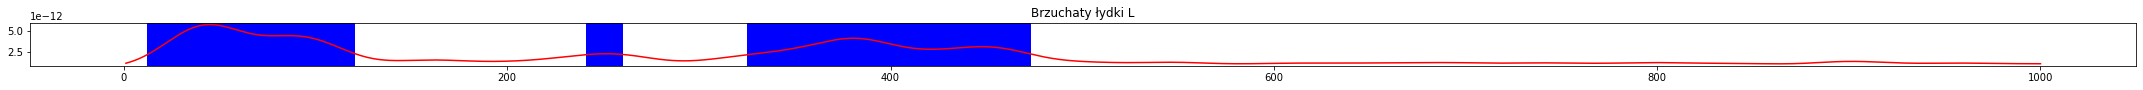

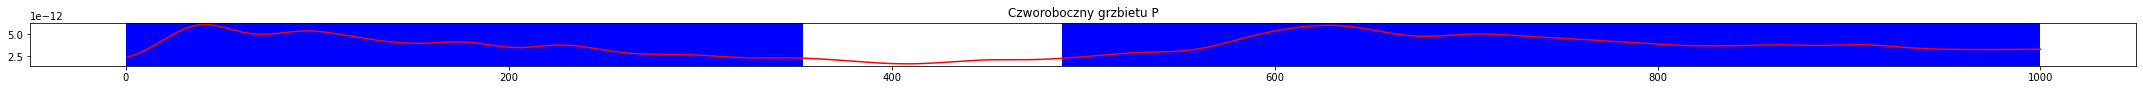

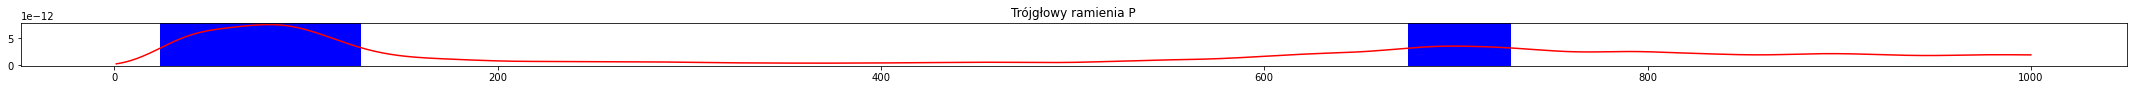

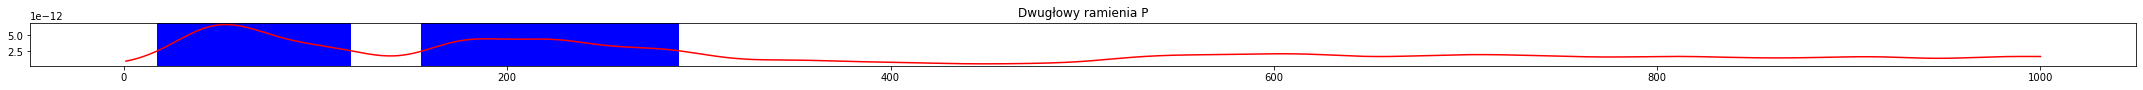

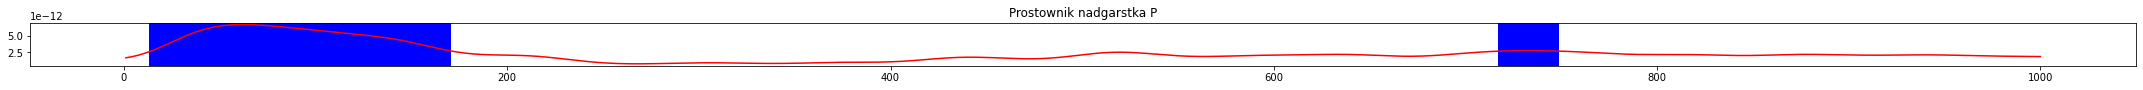

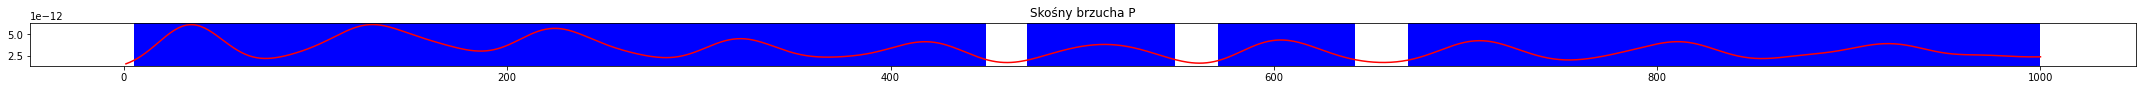

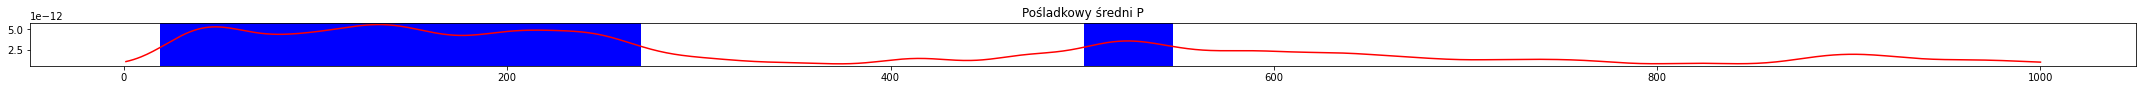

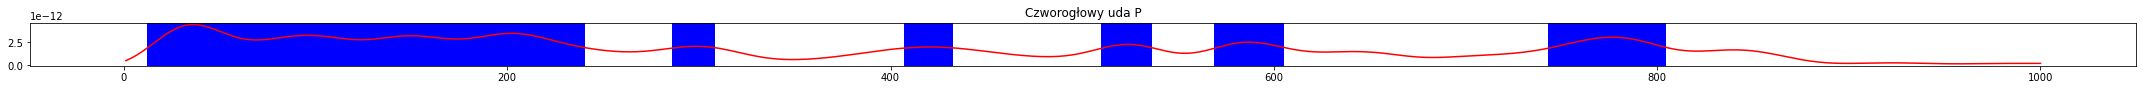

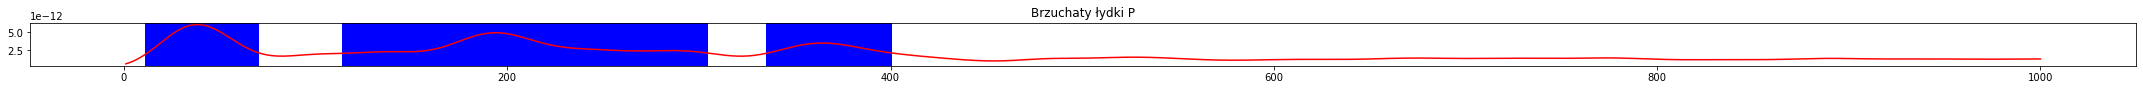

In [53]:
print_onset_offset(aver_arr_all,1000, "std", 1.9 , 1000/90 , 1000/80)

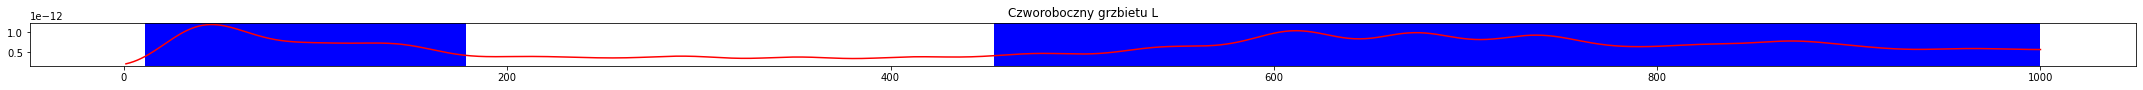

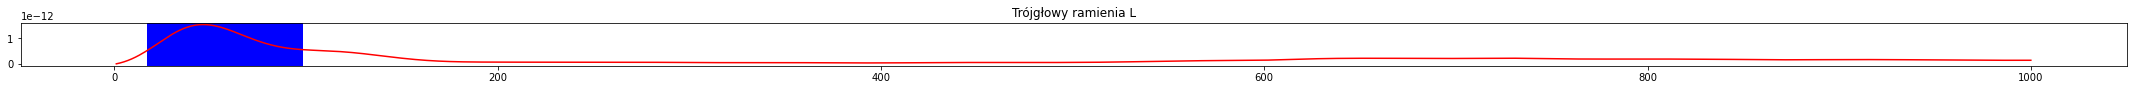

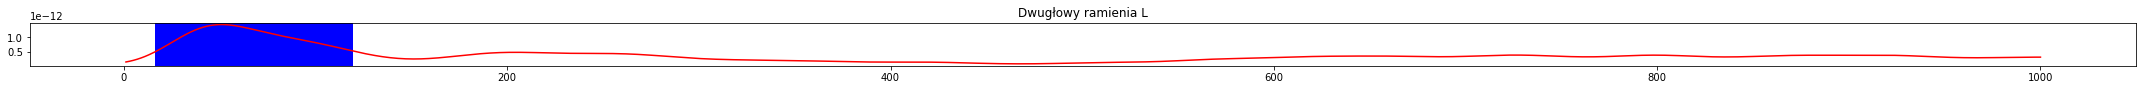

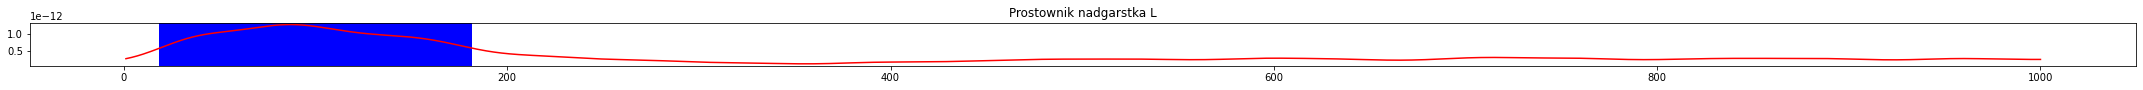

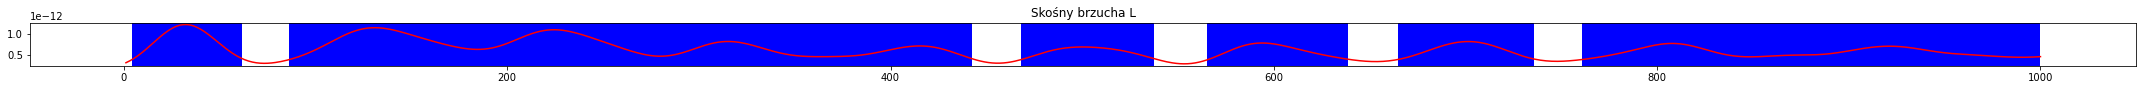

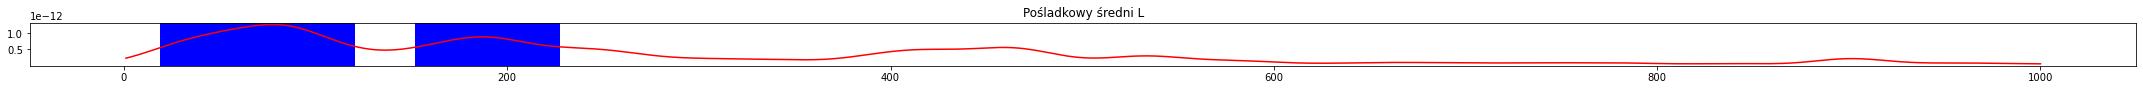

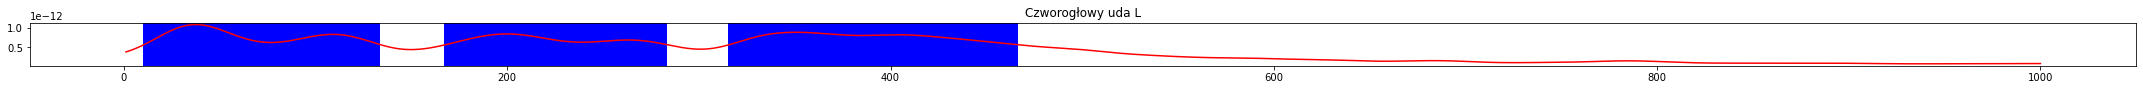

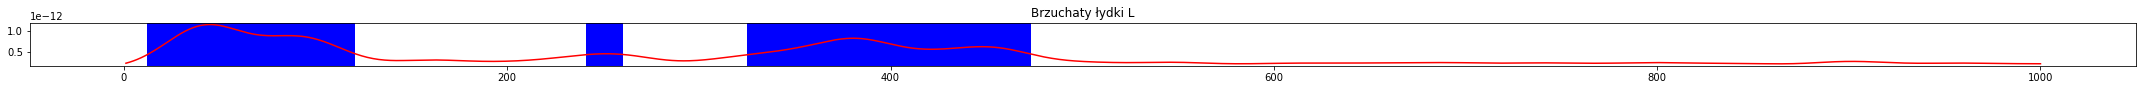

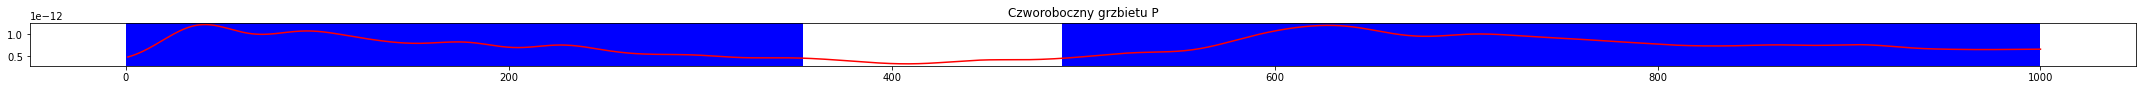

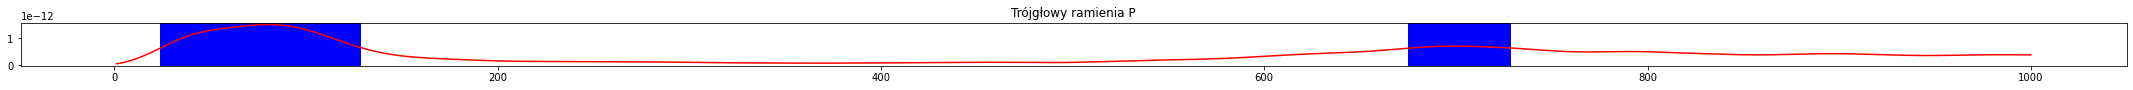

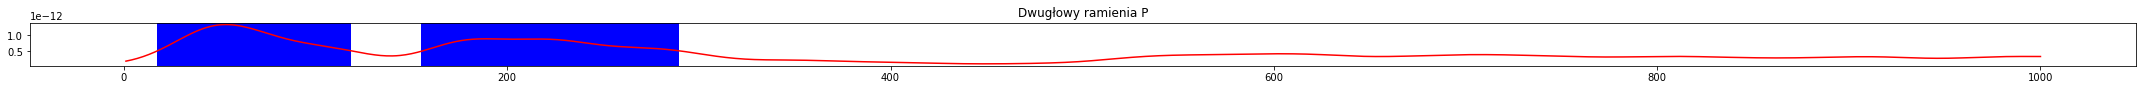

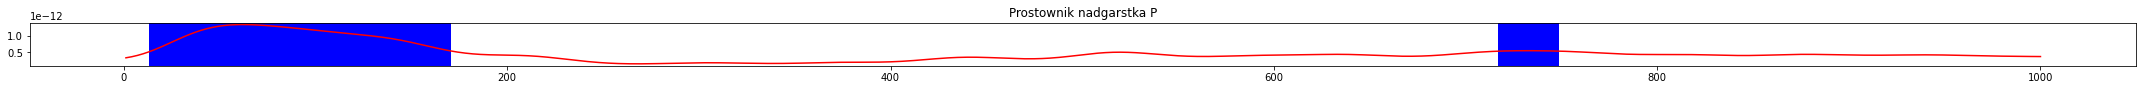

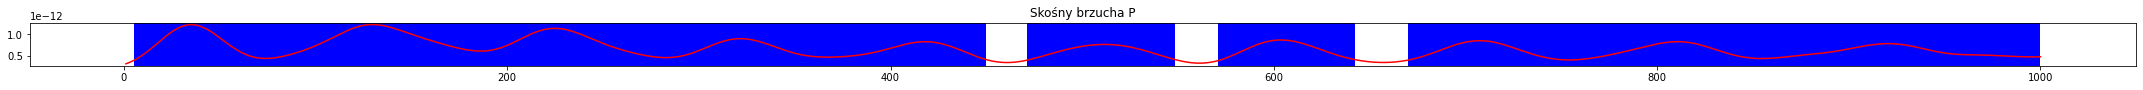

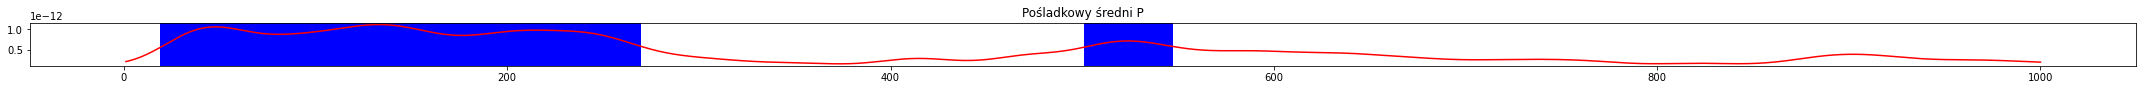

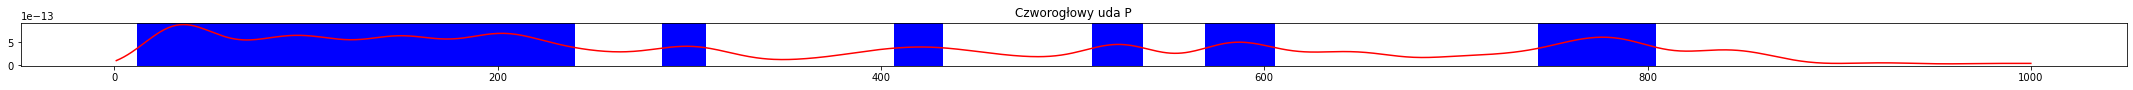

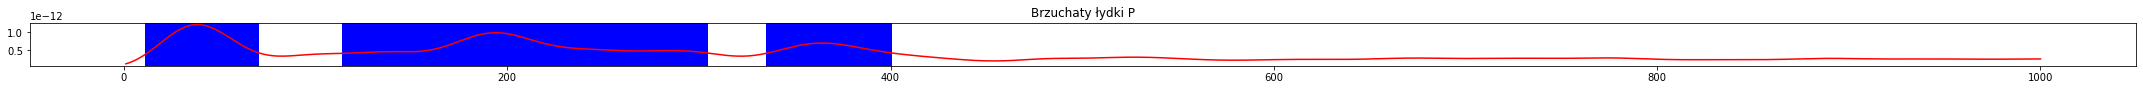

In [54]:
print_onset_offset(aver_arr_all,1000, "std", 1.9 , 1000/90 , 1000/80)

Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T01.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T02.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T03.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T04.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T05.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T06.c3d


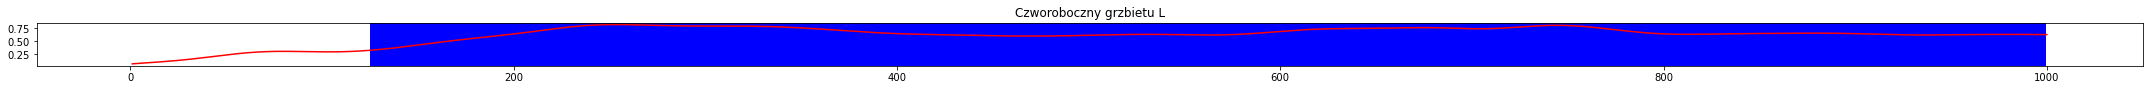

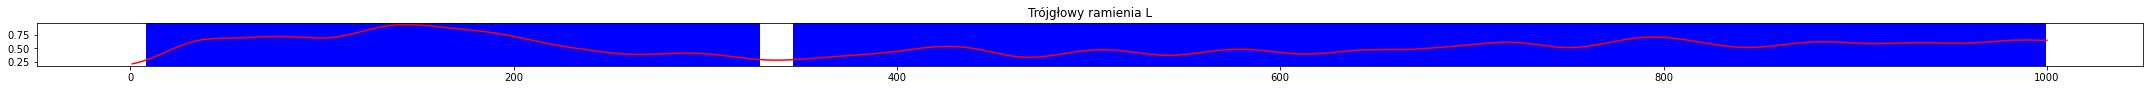

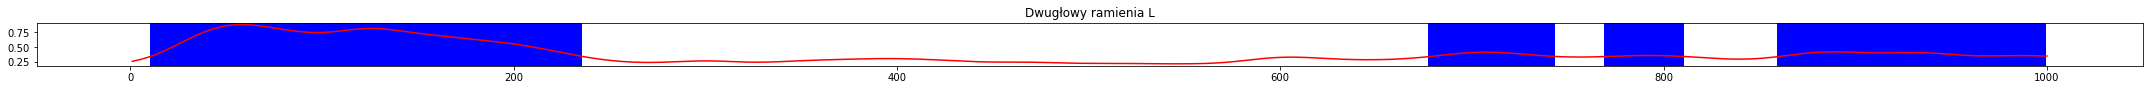

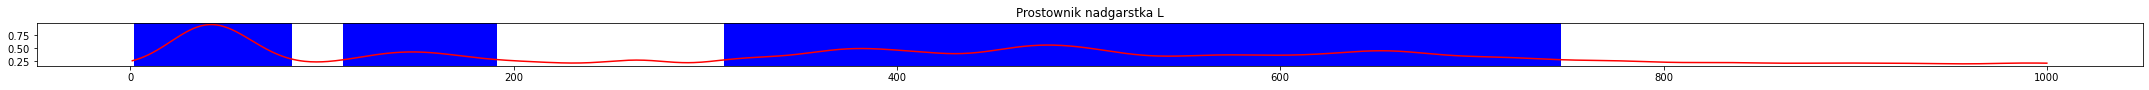

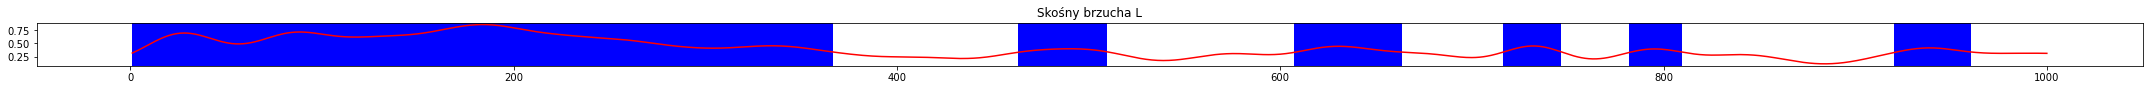

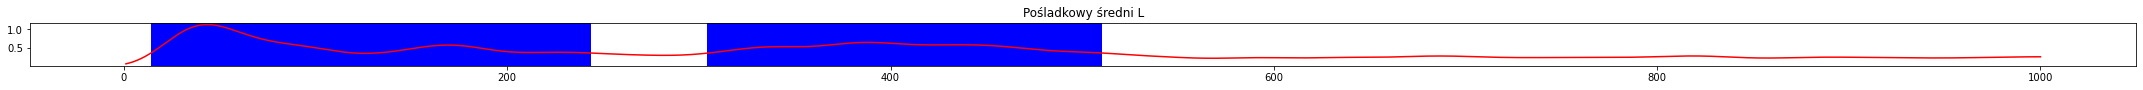

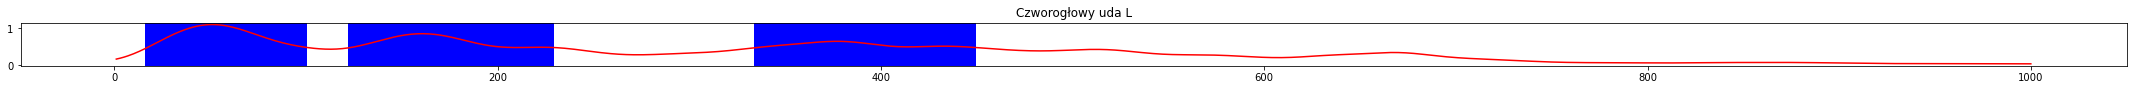

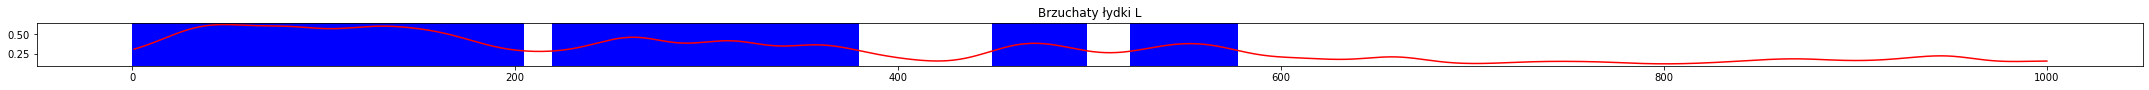

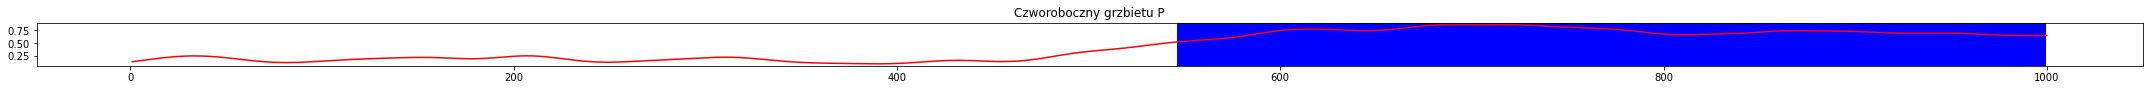

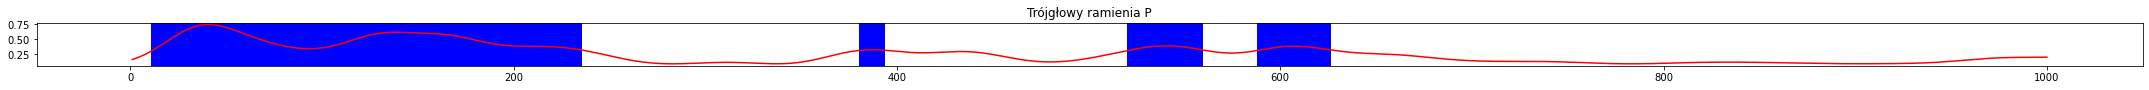

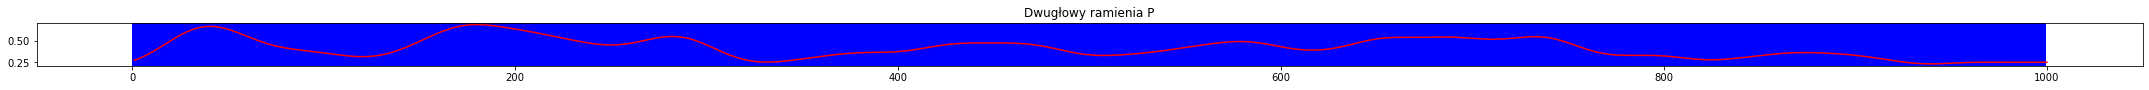

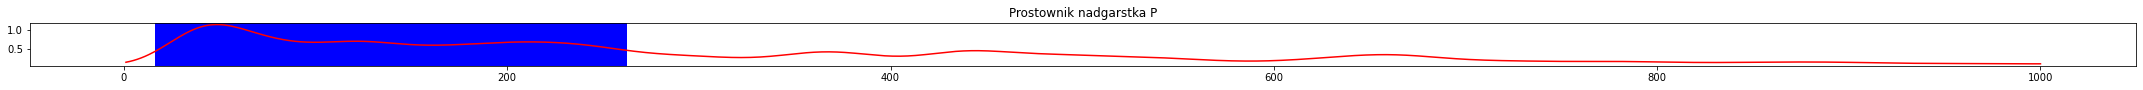

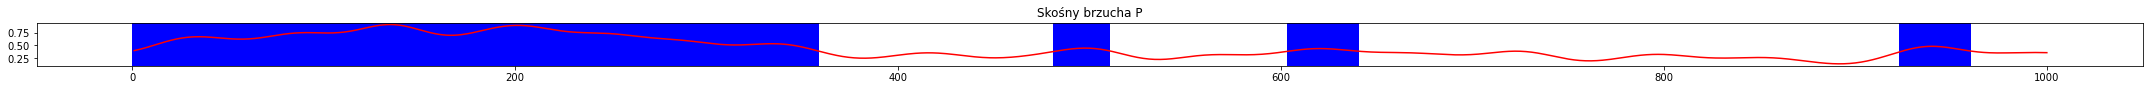

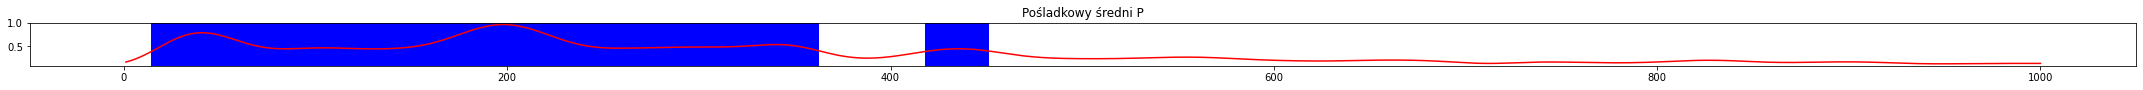

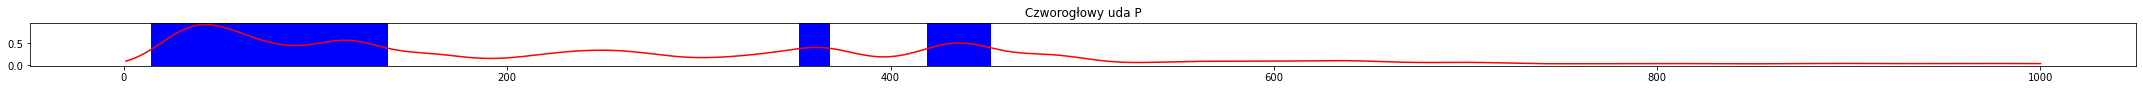

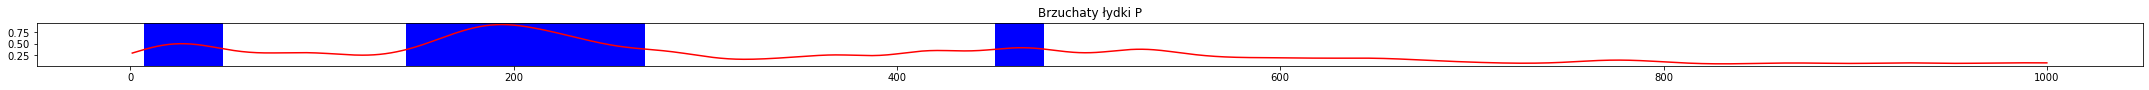

In [55]:
aver_arr_all=onset_offset_average_shifted(data_path, "B0447","4")
print_onset_offset(aver_arr_all,1000, "std", 1.9 , 1000/90 , 1000/80)

Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T01.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T02.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T03.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T04.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T05.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T06.c3d


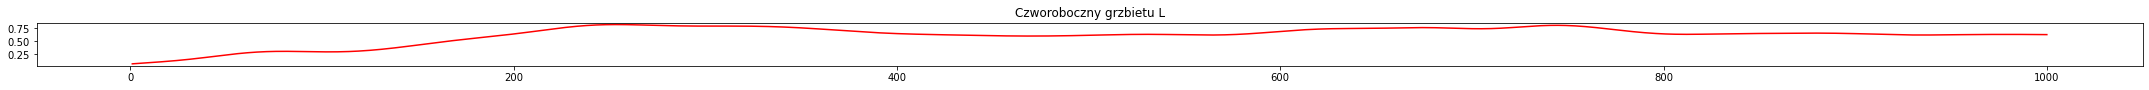

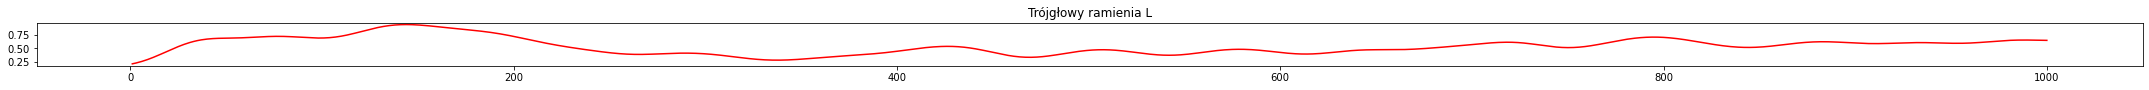

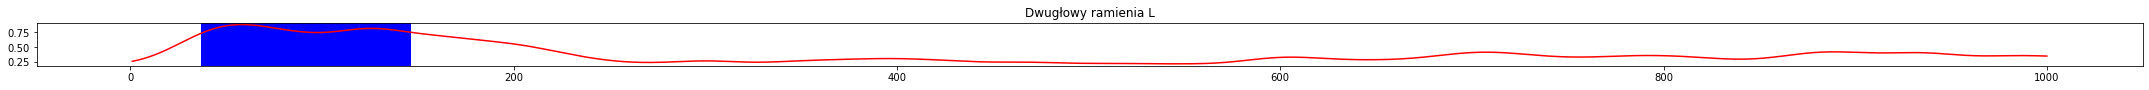

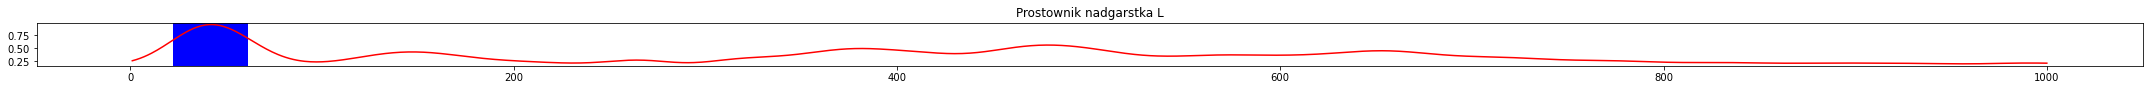

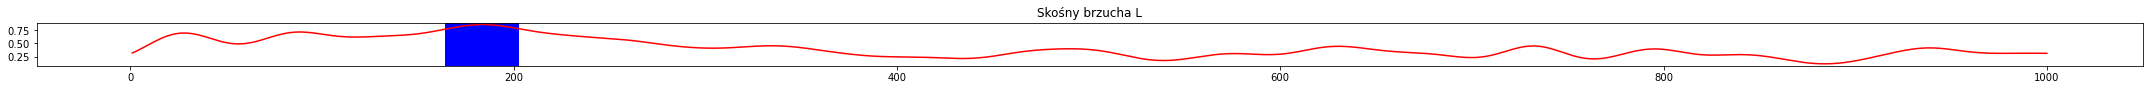

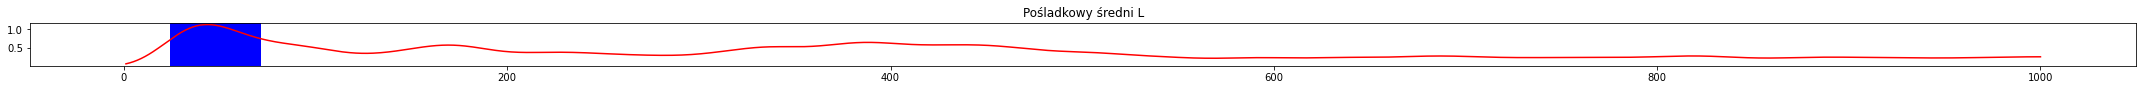

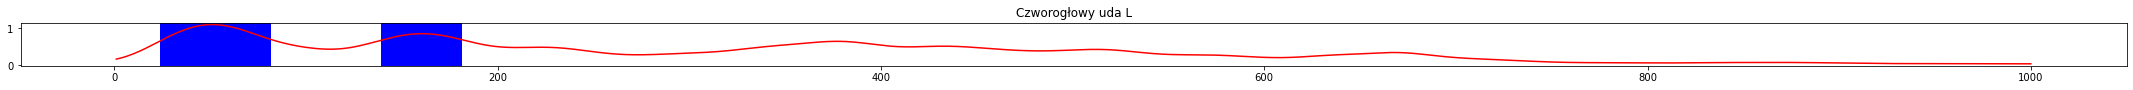

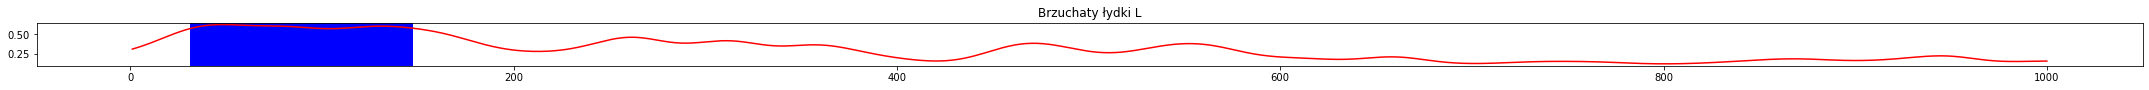

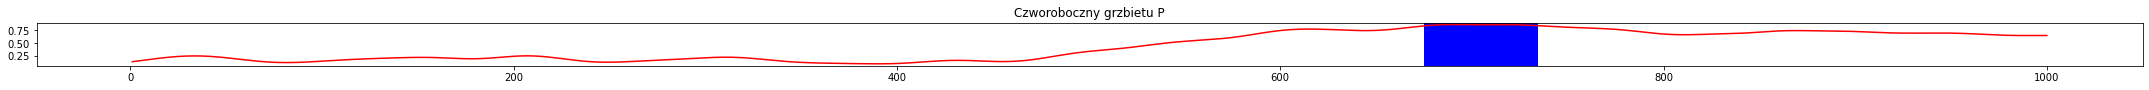

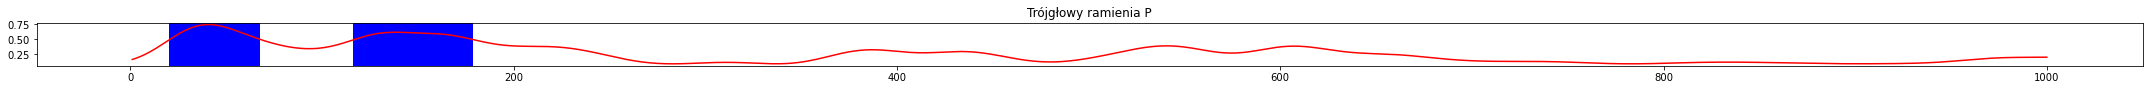

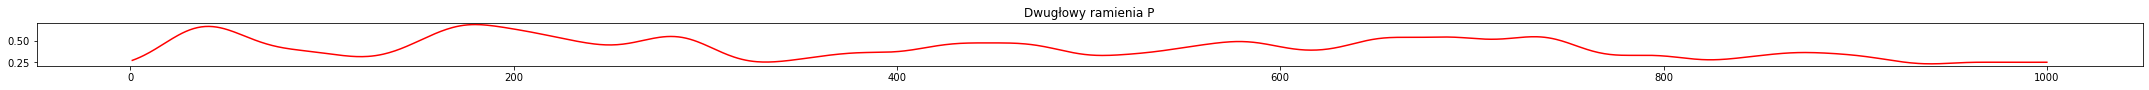

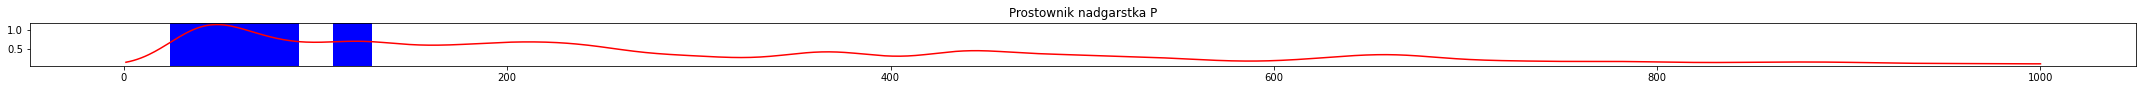

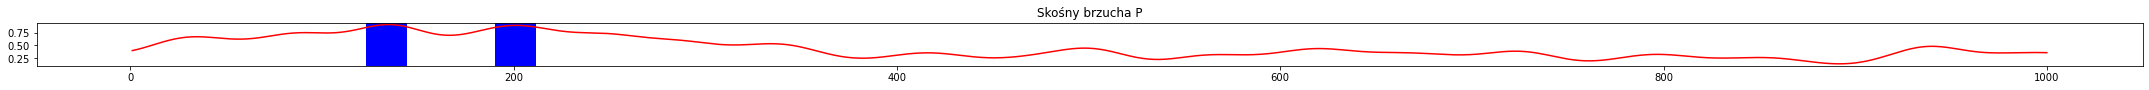

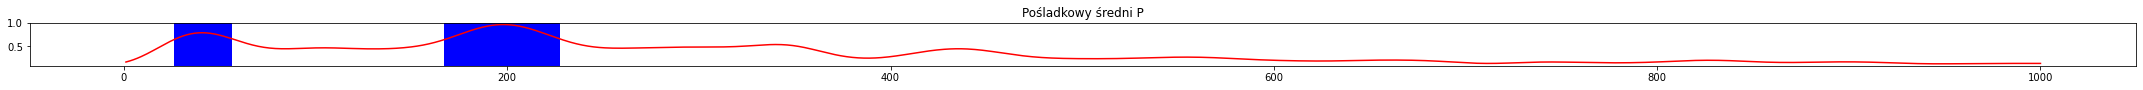

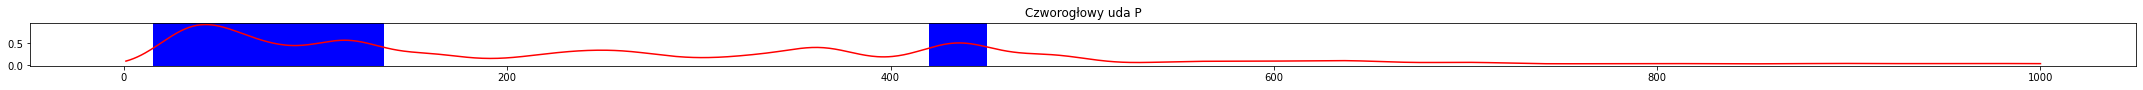

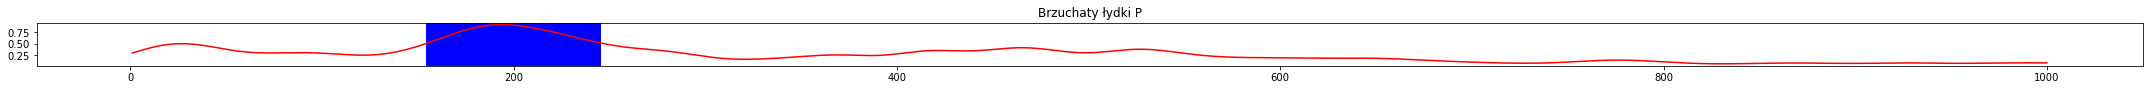

In [56]:
aver_arr_all=onset_offset_average_shifted(data_path, "B0447","4")
print_onset_offset(aver_arr_all,1000, "mean", 1.9 , 1000/90 , 1000/80)

In [57]:
def onset_offset_average_shifted(folder_path, person, exer_num):
    
    muscles_names = ["Czworoboczny grzbietu L","Trójgłowy ramienia L", "Dwugłowy ramienia L", "Prostownik nadgarstka L","Skośny brzucha L", "Pośladkowy średni L","Czworogłowy uda L", "Brzuchaty łydki L","Czworoboczny grzbietu P","Trójgłowy ramienia P", "Dwugłowy ramienia P", "Prostownik nadgarstka P","Skośny brzucha P", "Pośladkowy średni P","Czworogłowy uda P", "Brzuchaty łydki P"]
    cons1="\*\*-E0"
    cons2="-*.c3d"
    path=folder_path+person+cons1+exer_num+cons2
    freq=1000
    aver_arr_all=np.zeros((16,1000))     # średnia danych dla 16 mięśni (każdy plik zawiera 1000 jednostek czasu) 
    
    for file in glob.glob(path,recursive = True):
        if str(file).find('fail')==-1:
            print(file)
            emg_processed=dp.emg_full_preproces(file) 
            #print(type(emg_processed))

            aver_arr=np.zeros((16,1000))  #tabela średnich dla każdego mięśnia dla pojedyńczego pliku
            file_num=0

            p,d=dp.read_labels(file, 1000)  # czytnie eventów (początlki i końce eventów)

            for num in range(16):  # dla kazdego miesnia w tym pliku


                s,k=dp.nowy_czas_analog(p,d,emg_processed[num]) #nowy poczatek i koniec po przesunieciu

                for i in range(len(p)):     #dla każdego eventu robiona jest normalizacja        
                    emg_processed_event=emg_processed[num][(p[i]+s[i].astype(int)):(d[i]+k[i].astype(int))]
                    emg_processed_event2 = (
                    emg_processed_event.meca.normalize(scale=1)                
             )                                           
                    time_normalized=emg_processed_event2.meca.time_normalize(n_frames=1000)                

                    for t in range(1000):   #liczenie średniej
                        aver_arr[num][t]=aver_arr[num][t]+time_normalized.values[t]

                aver_arr[num]=aver_arr[num]/10
                time=np.linspace(1,1000,1000)

                for t2 in range(1000):  #średnia dla wszytskich plików
                    aver_arr_all[file_num][t2]=aver_arr_all[file_num][t2]+time_normalized.values[t2] # tablica zawiera wartości srednie dla wsytzkich plikow
                file_num=file_num+1;

            
    return aver_arr_all     
            
            

In [ ]:
aver_arr_all=dp.compare_events_average_shifted(folder_path, "B0447","4")
dp.print_onset_offset(aver_arr_all,1000, "std", 1.9 , 1000/90 , 1000/80)

Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T01.c3d
Z:\Miecz\\B0447\2020-08-07-B0447-S01\2020-08-07-B0447-S01-E04-T02.c3d
